# Mapping AI's Representation Gap: Building and Auditing a Hate Speech Detector for Demographic Fairness

**Team Members:**
- Prince: Data Lead
- Bruna: Modeling Lead  
- Maya: Communication/Presentation Lead

**Research Question:**
By building and evaluating a hate speech detector trained on real-world datasets, how can we uncover performance disparities across demographic groups, identify which communities are underserved or over-policed by such models, and visualize these fairness gaps to support more responsible AI development?

**Notebook Structure:**
1. Setup and Configuration
2. Data Loading and Verification
3. Data Preprocessing and Cleaning
4. Model Training (DistilBERT)
5. Overall Performance Evaluation
6. Fairness Analysis - Jigsaw Validation Set
7. Fairness Evaluation - HateCheck Dataset
8. Cross-Dataset Comparison
9. Summary of Findings

---

## Overview

This project addresses the question: By building a hate speech detector, how can we measure performance disparities across demographic groups and identify which communities are underserved or over-policed? This is crucial as it aims to reveal potential algorithmic biases, ensuring that AI systems treat all demographic groups fairly and equitably. Identifying these disparities is vital for improving the accountability and transparency of AI technologies.

### Task
Create a hate speech detector and measure performance disparities across demographic groups to identify which communities are underserved or over-policed.

## Domain Problem


The domain problem here is algorithmic bias and fairness in content moderation systems, specifically in automated hate speech detection.
The core issue is that AI models designed to detect hate speech often perform unevenly across different demographic groups due to several interconnected problems:

Representation bias occurs when training datasets don't equally represent all demographic groups, leading models to be better at detecting hate speech targeting majority groups while missing attacks on underrepresented communities. Disparate performance means the model may have significantly different accuracy rates across groups—for example, it might effectively catch hate speech against one demographic but fail to protect another, leaving vulnerable communities exposed to ongoing harassment.

There's also the risk of over-policing certain groups, where the model disproportionately flags content from particular demographics as hateful even when it isn't, effectively silencing those voices. Intersectional invisibility compounds these issues, as people belonging to multiple marginalized groups (such as Black women or LGBTQ+ individuals with disabilities) often face unique forms of hate speech that models trained primarily on single-axis examples fail to recognize.

### Purpose:
The real-world consequences of these problems are significant: inadequate protection leaves vulnerable communities exposed to harassment and harm on online platforms, uneven enforcement can amplify existing social inequities, and biased moderation systems erode trust in the platforms themselves. This project addresses the critical need to build content moderation systems that protect all users equitably, rather than inadvertently replicating or amplifying societal biases in digital spaces where so much human interaction now occurs.


## Analytic Approach

This project involves training a hate speech detection model using the Jigsaw Civil Comments dataset, with a strong emphasis on fairness and equity throughout the development process. The work begins by analyzing representation within the training data to identify which demographic groups may be under- or over-represented, ensuring awareness of potential biases from the outset. The trained model is then rigorously evaluated for fairness across multiple demographic groups using HateCheck alongside various performance and fairness metrics to understand how well it serves different populations. To make these findings accessible and actionable, the project includes creating visual dashboards, charts, and intersectional analyses that clearly communicate any disparities in both protection (where harmful content may go undetected for certain groups) and surveillance (where certain groups may be disproportionately flagged). Finally, all of this research culminates in a comprehensive report and presentation that summarizes the findings, documents model performance, and provides actionable insights to guide equitable AI deployment in real-world applications.


In [ ]:
# ============================================================================
# IMPORTS - All dependencies in one place
# ============================================================================

print("="*70)
print("HATE SPEECH DETECTION - LOADING LIBRARIES")
print("="*70)

# Standard library
import os
import re
import time
import pickle
import json
import random
from pathlib import Path
from datetime import datetime
from collections import Counter

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

# Deep learning
import torch
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    pipeline
)
from datasets import Dataset as HFDataset

# Statistical analysis
from scipy import stats
from scipy.stats import pearsonr, spearmanr

# Notebook-specific (Colab/Jupyter only)
from IPython.display import Image, display

# Utilities
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")
print("="*70 + "\n")

HATE SPEECH DETECTION - LOADING LIBRARIES
✓ All libraries imported successfully



In [ ]:
# ============================================================================
# REPRODUCIBILITY SETUP
# ============================================================================

RANDOM_SEED = 42

def set_all_seeds(seed=42):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_all_seeds(RANDOM_SEED)
print(f"✓ Random seed set: {RANDOM_SEED}")
print("="*70 + "\n")

✓ Random seed set: 42



## Setup and Configuration: Import Libraries & Load Data

This section defines the configuration parameters for the entire project, including:
- **Paths:** Where to save models, data, and outputs
- **Model settings:** DistilBERT parameters, batch size, learning rate
- **Data parameters:** Sample size, train/validation split ratios
- **Random seed:** For reproducibility

**Key Settings:**
- Model: `distilbert-base-uncased` (66.9M parameters)
- Batch size: 96 (optimized for L4 GPU)
- Epochs: 2
- Learning rate: 2e-5
- Max sequence length: 128 tokens

### Libraries & Packages

Install Libraries

In [ ]:
!pip install pandas numpy matplotlib seaborn tqdm requests \
    scikit-learn statsmodels fairlearn transformers datasets torch \
    plotly spacy nltk pyarrow fastparquet joblib accelerate scipy

Import all libraries

In [ ]:
# IMPORTS - All dependencies in one place

# Standard Library
import os
import gc
import re
import json
import pickle
import random
from pathlib import Path
from datetime import datetime
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px   # Added: plotly installed but not imported
from tqdm import tqdm

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

# Deep Learning (PyTorch & Transformers)
import torch
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    pipeline
)
from datasets import Dataset as HFDataset

# Statistical Analysis
import scipy
from scipy import stats
from scipy.stats import pearsonr, spearmanr

# Fairness / Bias Analysis
import fairlearn
from fairlearn.metrics import MetricFrame  # Commonly used optional import

# NLP Tools
import spacy
import nltk

# Utilities
import requests
import joblib

# Data IO / Big Data formats
import pyarrow as pa
import fastparquet

# PyTorch acceleration utilities
import accelerate

# Plot Style
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8-darkgrid')


In [ ]:
CONFIG = {
    'experiment_name': 'hate_speech_detection_full_1.8M_L4',
    'random_seed': 42,

    'data': {
        'jigsaw_sample_size': None,  # Full dataset
        'test_split': 0.2,
        'toxicity_threshold': 0.5,
        'identity_mention_threshold': 0.5,
        'min_text_length': 1,
    },

    'model': {
        'name': 'distilbert-base-uncased',
        'max_length': 128,
        'batch_size': 96,        # ← Optimal for L4's 24GB
        'learning_rate': 2e-5,
        'num_epochs': 2,
        'weight_decay': 0.01,

        # Checkpoint settings
        'save_strategy': 'steps',
        'save_steps': 10000,
        'save_total_limit': 2,
        'logging_steps': 500,
    },

    'fairness': {
        'max_false_positive_rate': 0.15,
        'min_detection_rate': 0.75,
    },

    'paths': {
        'jigsaw_train': 'train.csv',
        'hatecheck_url': 'https://raw.githubusercontent.com/paul-rottger/hatecheck-data/main/test_suite_cases.csv',
        'model_output': './hate_speech_detector_full_final',
        'cache_dir': './cache',
        'results_dir': './results',
    }
}

print("✓ CONFIG optimized for L4 GPU")
print(f"  Batch size: {CONFIG['model']['batch_size']}")
print(f"  Expected training time: ~15-18 hours")

✓ CONFIG optimized for L4 GPU
  Batch size: 96
  Expected training time: ~15-18 hours


### Data Sets

We will be using the following datasets for training, auditing, and evaluating our hate speech detector:

**Jigsaw Civil Comments (Kaggle)**
- Contains ~2 million online comments labeled for toxicity and identity mentions.
- This dataset will be used to train the hate speech detection model and analyze representation across demographic groups.

**HateCheck (Paul Röttger GitHub)**

- A test suite with 3,728 cases designed to benchmark fairness in hate speech detection models.
- Focuses on demographic variations and edge cases in language usage.
This dataset will be used to evaluate model fairness and identify potential biases in predictions.

Import Datasets

#### Jigsaw Dataset

Upload kaggle credentials

In [ ]:
# Upload Kaggle credentials
print("\n[STEP 1/6] Upload kaggle.json...")
from google.colab import files
uploaded = files.upload()


[STEP 1/6] Upload kaggle.json...


Saving kaggle.json to kaggle.json


Configure Kaggle

In [ ]:
#!mv "kaggle (1).json" kaggle.json

In [ ]:
# Create the Kaggle directory, move the file, and set permissions

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json 2>/dev/null || cp kaggle_use_this.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
print("✓ Kaggle configured")

✓ Kaggle configured


In [ ]:
# Test API is installed correctly

!kaggle competitions list --page 1 | head -5

ref                                                                                 deadline             category                reward  teamCount  userHasEntered  
----------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/ai-mathematical-olympiad-progress-prize-3       2026-04-15 23:59:00  Featured         2,207,152 Usd        568           False  
https://www.kaggle.com/competitions/gemini-3                                        2025-12-12 23:59:00  Featured           500,000 Usd         28           False  
https://www.kaggle.com/competitions/hull-tactical-market-prediction                 2025-12-15 23:59:00  Featured           100,000 Usd       3180           False  


Download Jigsaw Kaggle Dataset

In [ ]:
# Download dataset

!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification

 91% 660M/723M [00:00<00:00, 1.73GB/s]
100% 723M/723M [00:00<00:00, 1.72GB/s]


In [ ]:
# Unzip Dataset

!unzip -q jigsaw-unintended-bias-in-toxicity-classification.zip
print("✓ Files extracted")

✓ Files extracted


In [ ]:
# Verify

!ls -lh *.csv

-rw-r--r-- 1 root root 874M Jul 16  2020 all_data.csv
-rw-r--r-- 1 root root 102M Jul 16  2020 identity_individual_annotations.csv
-rw-r--r-- 1 root root 1.2M Jul 16  2020 sample_submission.csv
-rw-r--r-- 1 root root  29M Jul 16  2020 test.csv
-rw-r--r-- 1 root root  43M Jul 16  2020 test_private_expanded.csv
-rw-r--r-- 1 root root  43M Jul 16  2020 test_public_expanded.csv
-rw-r--r-- 1 root root 399M Jul 16  2020 toxicity_individual_annotations.csv
-rw-r--r-- 1 root root 779M Jul 16  2020 train.csv


In [ ]:
# Load Jigsaw CSV file into Pandas
df_sample = pd.read_csv('train.csv', nrows=5)

#### Hatecheck Dataset

In [ ]:
# Instant load
hatecheck = pd.read_csv("https://raw.githubusercontent.com/paul-rottger/hatecheck-data/main/test_suite_cases.csv")

print(f"✓ Loaded {len(hatecheck):,} test cases")
print("✓ Data is ready to use!")

✓ Loaded 3,728 test cases
✓ Data is ready to use!


## Data Loading and Verification

**Dataset: Jigsaw Unintended Bias in Toxicity Classification**

**Source:** Kaggle Competition  
**Size:** 1,804,874 comments from Civil Comments platform  
**Labels:** Toxicity scores (0-1) with identity attribute flags

**Identity Columns Available:**
- **Gender:** male, female, transgender, other_gender
- **Sexual Orientation:** heterosexual, homosexual_gay_or_lesbian, bisexual
- **Religion:** christian, jewish, muslim, hindu, buddhist, atheist
- **Race/Ethnicity:** black, white, asian, latino, other_race_or_ethnicity
- **Disability:** physical_disability, intellectual_or_learning_disability, psychiatric_or_mental_illness

**Verification Steps:**
1. Check dataset completeness
2. Verify identity columns present
3. Examine class distribution (toxic vs non-toxic)
4. Analyze identity representation rates

In [ ]:
"""
JIGSAW DATA VERIFICATION - Run this cell to verify everything loaded correctly
"""

print("="*80)
print("JIGSAW DATASET VERIFICATION")
print("="*80)

# ===========================================================================
# STEP 1: LOAD DATA
# ===========================================================================
print("\n[STEP 1] Loading data...")

if os.path.exists('/content/train.csv'):
    data_path = '/content/train.csv'
else:
    data_path = 'train.csv'

file_size_mb = os.path.getsize(data_path) / (1024 * 1024)
print(f"✓ Found: {data_path} ({file_size_mb:.1f} MB)")

# ← CHANGED THIS LINE - Use CONFIG setting
sample_size = CONFIG['data']['jigsaw_sample_size']
if sample_size:
    jigsaw = pd.read_csv(data_path, nrows=sample_size)
    print(f"✓ Loaded {len(jigsaw):,} rows (sample), {len(jigsaw.columns)} columns")
else:
    jigsaw = pd.read_csv(data_path)  # Load ALL data
    print(f"✓ Loaded {len(jigsaw):,} rows (FULL dataset), {len(jigsaw.columns)} columns")

# Rest of the cell stays the same...
# ===========================================================================
# STEP 2: VERIFY STRUCTURE
# ===========================================================================
print("\n[STEP 2] Verifying structure...")

essential_cols = ['comment_text', 'target']
identity_cols = ['male', 'female', 'black', 'white', 'muslim', 'christian',
                 'asian', 'latino', 'transgender', 'homosexual_gay_or_lesbian']

present_essential = [col for col in essential_cols if col in jigsaw.columns]
present_identity = [col for col in identity_cols if col in jigsaw.columns]

print(f"✓ Essential columns: {len(present_essential)}/{len(essential_cols)}")
print(f"  {present_essential}")
print(f"✓ Identity columns: {len(present_identity)}/{len(identity_cols)}")
print(f"  {present_identity[:5]}...")

# ===========================================================================
# STEP 3: CHECK DATA QUALITY
# ===========================================================================
print("\n[STEP 3] Checking data quality...")

# Missing values
missing = jigsaw['comment_text'].isna().sum()
print(f"✓ Missing comments: {missing} ({missing/len(jigsaw)*100:.1f}%)")

# Toxicity distribution
print(f"✓ Toxicity range: [{jigsaw['target'].min():.3f}, {jigsaw['target'].max():.3f}]")
print(f"✓ Average toxicity: {jigsaw['target'].mean():.3f}")

# Binary classification
jigsaw['toxic_binary'] = (jigsaw['target'] >= CONFIG['data']['toxicity_threshold']).astype(int)
toxic_count = jigsaw['toxic_binary'].sum()
non_toxic_count = len(jigsaw) - toxic_count
print(f"✓ Toxic: {toxic_count:,} ({toxic_count/len(jigsaw)*100:.1f}%)")
print(f"✓ Non-toxic: {non_toxic_count:,} ({non_toxic_count/len(jigsaw)*100:.1f}%)")
print(f"✓ Class ratio: {non_toxic_count/toxic_count:.1f}:1")

# ===========================================================================
# STEP 4: IDENTITY REPRESENTATION
# ===========================================================================
print("\n[STEP 4] Identity representation...")

if present_identity:
    mention_rates = {}
    for col in present_identity:
        rate = (jigsaw[col].fillna(0) >= 0.5).sum() / len(jigsaw) * 100
        mention_rates[col] = rate

    sorted_rates = sorted(mention_rates.items(), key=lambda x: x[1], reverse=True)
    print(f"✓ Top 5 most mentioned identities:")
    for col, rate in sorted_rates[:5]:
        print(f"  • {col}: {rate:.2f}%")

# ===========================================================================
# STEP 5: SAMPLE PREVIEW
# ===========================================================================
print("\n[STEP 5] Sample data...")

print("\nNon-toxic example:")
non_toxic = jigsaw[jigsaw['toxic_binary'] == 0].iloc[0]
print(f"  Score: {non_toxic['target']:.3f}")
print(f"  Text: \"{non_toxic['comment_text'][:100]}...\"")

print("\nToxic example:")
toxic = jigsaw[jigsaw['toxic_binary'] == 1].iloc[0]
print(f"  Score: {toxic['target']:.3f}")
print(f"  Text: \"{toxic['comment_text'][:100]}...\"")

# ===========================================================================
# FINAL CHECK
# ===========================================================================
print("\n" + "="*80)

checks = {  # ← Single "c"
    'Data loaded': True,
    'Essential columns present': len(present_essential) == len(essential_cols),
    'Identity columns present': len(present_identity) > 0,
    'Target values valid': jigsaw['target'].between(0, 1).all(),
    'Sufficient toxic examples': toxic_count > 100,
}

all_passed = all(checks.values())

for check, passed in checks.items():
    status = "✓" if passed else "✗"
    print(f"{status} {check}")

print("="*80)

if all_passed:
    print("\n✓✓✓ ALL CHECKS PASSED - DATA READY! ✓✓✓")
else:
    print("\n⚠️ SOME CHECKS FAILED - Please review issues above")

print("\n" + "="*80)

JIGSAW DATASET VERIFICATION

[STEP 1] Loading data...
✓ Found: /content/train.csv (778.4 MB)
✓ Loaded 1,804,874 rows (FULL dataset), 45 columns

[STEP 2] Verifying structure...
✓ Essential columns: 2/2
  ['comment_text', 'target']
✓ Identity columns: 10/10
  ['male', 'female', 'black', 'white', 'muslim']...

[STEP 3] Checking data quality...
✓ Missing comments: 3 (0.0%)
✓ Toxicity range: [0.000, 1.000]
✓ Average toxicity: 0.103
✓ Toxic: 144,334 (8.0%)
✓ Non-toxic: 1,660,540 (92.0%)
✓ Class ratio: 11.5:1

[STEP 4] Identity representation...
✓ Top 5 most mentioned identities:
  • female: 2.96%
  • male: 2.46%
  • christian: 2.24%
  • white: 1.39%
  • muslim: 1.16%

[STEP 5] Sample data...

Non-toxic example:
  Score: 0.000
  Text: "This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done..."

Toxic example:
  Score: 0.894
  Text: "haha you guys are a bunch of losers...."

✓ Data loaded
✓ Essential columns present
✓ Identity columns present
✓ Ta

## Data Preprocessing and Cleaning

**Objective:** Prepare 1.8M comments for training

**Steps:**
1. **Handle missing values:** Remove rows with missing comment text
2. **Create binary labels:** Convert continuous toxicity scores (0-1) to binary (threshold = 0.5)
3. **Process identity columns:** Fill NaN values, create aggregated categories
4. **Text cleaning:**
   - Lowercase conversion
   - URL removal
   - HTML tag removal
   - Special character handling
   - Whitespace normalization
5. **Calculate text statistics:** Length, word count
6. **Train/validation split:** 80/20 stratified by toxicity label
7. **Save to cache:** For faster future loading

**Expected Output:**
- ~1.8M processed comments
- ~1.4M training samples
- ~360k validation samples
- Class imbalance: ~11.5:1 (non-toxic:toxic)

In [ ]:
"""
PHASE 4: DATA PREPROCESSING & CLEANING
"""

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
import time

print("="*80)
print("JIGSAW DATA PREPROCESSING PIPELINE")
print("="*80)

# STEP 1: Fix missing data
print("\n[STEP 1/7] Fixing missing data...")
print(f"Starting rows: {len(jigsaw):,}")
jigsaw = jigsaw.dropna(subset=['comment_text'])
print(f"✓ After dropping missing: {len(jigsaw):,} rows")

# STEP 2: Create binary target
print("\n[STEP 2/7] Creating binary toxicity labels...")
jigsaw['toxic_binary'] = (jigsaw['target'] >= CONFIG['data']['toxicity_threshold']).astype(int)
toxic_count = jigsaw['toxic_binary'].sum()
print(f"✓ Toxic: {toxic_count:,} ({toxic_count/len(jigsaw)*100:.1f}%)")
print(f"✓ Non-toxic: {len(jigsaw)-toxic_count:,}")

# STEP 3: Process identity columns
print("\n[STEP 3/7] Processing identity columns...")
identity_columns = [
    'male', 'female', 'transgender', 'other_gender',
    'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation',
    'christian', 'jewish', 'muslim', 'hindu', 'buddhist', 'atheist', 'other_religion',
    'black', 'white', 'asian', 'latino', 'other_race_or_ethnicity',
    'physical_disability', 'intellectual_or_learning_disability',
    'psychiatric_or_mental_illness', 'other_disability'
]
identity_columns = [col for col in identity_columns if col in jigsaw.columns]

# Fill missing with 0
for col in identity_columns:
    jigsaw[col].fillna(0, inplace=True)

# Create aggregates
jigsaw['any_identity'] = (jigsaw[identity_columns].max(axis=1) >= 0.5).astype(int)
print(f"✓ Processed {len(identity_columns)} identity columns")

# STEP 4: Text cleaning
print("\n[STEP 4/7] Cleaning text data...")
def clean_text(text):
    if pd.isna(text):
        return ''
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s!?.,]', '', text)
    text = ' '.join(text.split())
    return text

print(f"  Cleaning {len(jigsaw):,} comments (takes ~10-15 min for full dataset)...")
start = time.time()
jigsaw['comment_text_cleaned'] = jigsaw['comment_text'].apply(clean_text)
print(f"✓ Done in {time.time()-start:.1f} seconds")

# Remove empty comments
jigsaw = jigsaw[jigsaw['comment_text_cleaned'].str.len() > 0]
print(f"✓ Final size: {len(jigsaw):,} rows")

# STEP 5: Text statistics
print("\n[STEP 5/7] Calculating text statistics...")
jigsaw['text_length'] = jigsaw['comment_text_cleaned'].str.len()
jigsaw['word_count'] = jigsaw['comment_text_cleaned'].str.split().str.len()
print(f"✓ Mean length: {jigsaw['text_length'].mean():.0f} chars, {jigsaw['word_count'].mean():.1f} words")

# STEP 6: Train/val split
print("\n[STEP 6/7] Creating train/validation split...")
X_train, X_val, y_train, y_val = train_test_split(
    jigsaw['comment_text_cleaned'],
    jigsaw['toxic_binary'],
    test_size=CONFIG['data']['test_split'],
    stratify=jigsaw['toxic_binary'],
    random_state=CONFIG['random_seed']
)

train_df = jigsaw.loc[X_train.index].copy()
val_df = jigsaw.loc[X_val.index].copy()

print(f"✓ Training: {len(train_df):,} samples ({y_train.sum():,} toxic)")
print(f"✓ Validation: {len(val_df):,} samples ({y_val.sum():,} toxic)")

# STEP 7: Save to cache
print("\n[STEP 7/7] Saving to cache for future runs...")

from pathlib import Path
import pickle
from datetime import datetime

cache_dir = Path(CONFIG['paths']['cache_dir'])
cache_dir.mkdir(exist_ok=True)
cache_file = cache_dir / 'jigsaw_full_processed.pkl'

cache_data = {
    'train': train_df,
    'val': val_df,
    'full': jigsaw,
    'info': {
        'total_rows': len(jigsaw),
        'train_rows': len(train_df),
        'val_rows': len(val_df),
        'toxic_rate': train_df['toxic_binary'].mean(),
        'cached_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    }
}

print(f"  Saving {len(jigsaw):,} processed rows...")
with open(cache_file, 'wb') as f:
    pickle.dump(cache_data, f)

cache_size_mb = cache_file.stat().st_size / (1024 * 1024)
print(f"✓ Saved to cache: {cache_file}")
print(f"✓ Cache size: {cache_size_mb:.1f} MB")
print(f"✓ Next restart will load in ~5 seconds!")

print("\n" + "="*80)
print("✓✓✓ PREPROCESSING COMPLETE! ✓✓✓")
print("="*80)
print("\n Ready for Model Training!")

JIGSAW DATA PREPROCESSING PIPELINE

[STEP 1/7] Fixing missing data...
Starting rows: 1,804,874
✓ After dropping missing: 1,804,871 rows

[STEP 2/7] Creating binary toxicity labels...
✓ Toxic: 144,334 (8.0%)
✓ Non-toxic: 1,660,537

[STEP 3/7] Processing identity columns...
✓ Processed 24 identity columns

[STEP 4/7] Cleaning text data...
  Cleaning 1,804,871 comments (takes ~10-15 min for full dataset)...
✓ Done in 26.3 seconds
✓ Final size: 1,802,697 rows

[STEP 5/7] Calculating text statistics...
✓ Mean length: 290 chars, 51.1 words

[STEP 6/7] Creating train/validation split...
✓ Training: 1,442,157 samples (115,466 toxic)
✓ Validation: 360,540 samples (28,867 toxic)

[STEP 7/7] Saving to cache for future runs...
  Saving 1,802,697 processed rows...
✓ Saved to cache: cache/jigsaw_full_processed.pkl
✓ Cache size: 2413.4 MB
✓ Next restart will load in ~5 seconds!

✓✓✓ PREPROCESSING COMPLETE! ✓✓✓

 Ready for Model Training!


In [ ]:
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv

import torch
print(f"\n✓ CUDA available: {torch.cuda.is_available()}")
print(f"✓ GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

name, memory.total [MiB], memory.free [MiB]
NVIDIA A100-SXM4-80GB, 81920 MiB, 81216 MiB

✓ CUDA available: True
✓ GPU: NVIDIA A100-SXM4-80GB


In [ ]:
print(f"✓ Train samples: {len(train_df):,}")
print(f"✓ Val samples: {len(val_df):,}")
print(f"✓ Toxic rate: {train_df['toxic_binary'].mean():.1%}")

✓ Train samples: 1,442,157
✓ Val samples: 360,540
✓ Toxic rate: 8.0%


In [ ]:
print(f"✓ Batch size: {CONFIG['model']['batch_size']}")
print(f"✓ Epochs: {CONFIG['model']['num_epochs']}")
print(f"✓ Learning rate: {CONFIG['model']['learning_rate']}")

✓ Batch size: 96
✓ Epochs: 2
✓ Learning rate: 2e-05


## Initial EDA

### Identity Group Representation

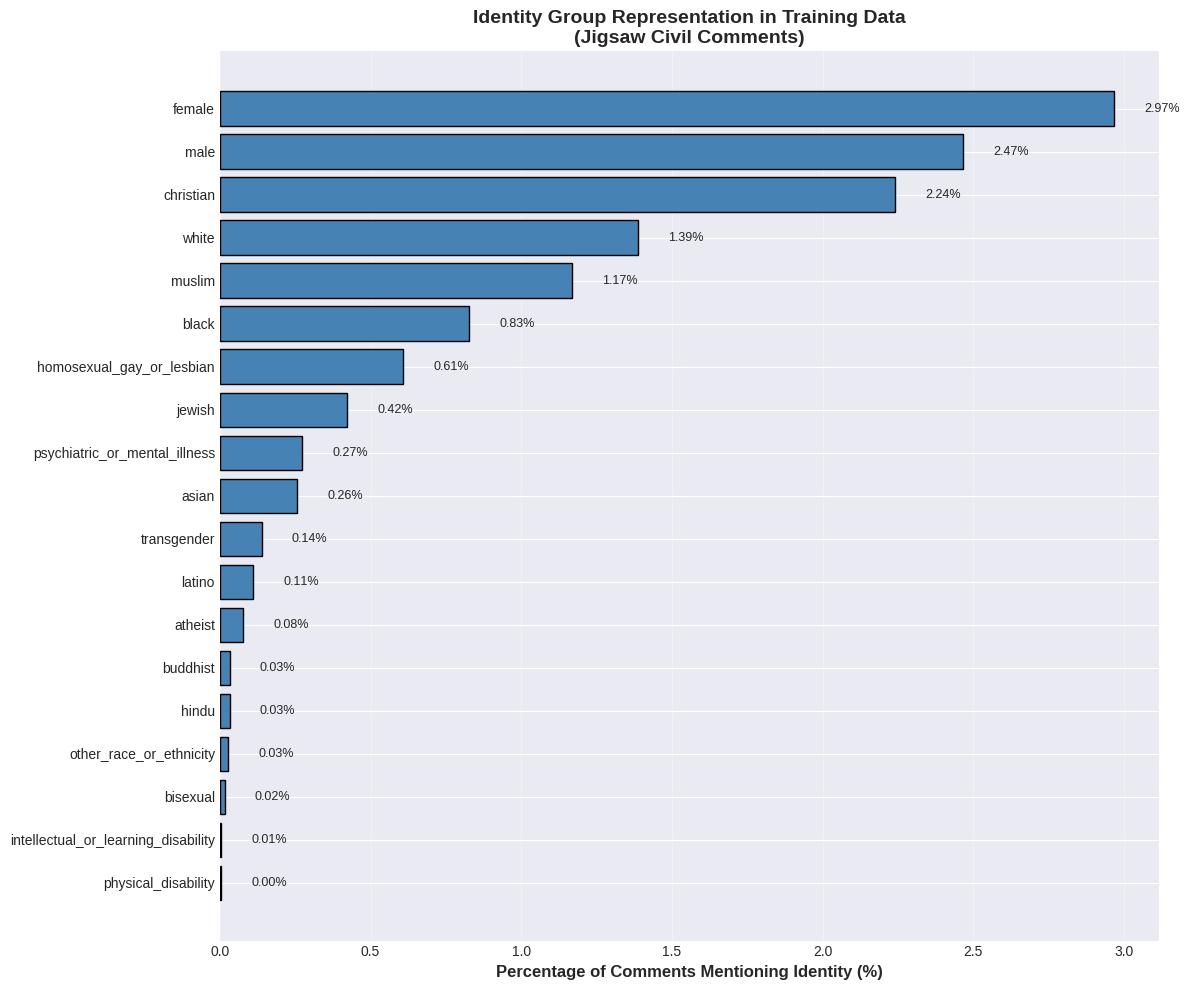

In [ ]:

# Define identity columns
identity_columns = [
    'male', 'female', 'transgender',
    'homosexual_gay_or_lesbian', 'bisexual',
    'christian', 'jewish', 'muslim', 'hindu', 'buddhist', 'atheist',
    'black', 'white', 'asian', 'latino', 'other_race_or_ethnicity',
    'physical_disability', 'intellectual_or_learning_disability',
    'psychiatric_or_mental_illness'
]

# Filter to columns that exist
identity_columns = [col for col in identity_columns if col in train_df.columns]

# Calculate mention rates (% of comments mentioning each identity)
mention_rates = {}
for col in identity_columns:
    rate = (train_df[col].fillna(0) >= 0.5).sum() / len(train_df) * 100
    mention_rates[col] = rate

# Sort and plot
mention_df = pd.DataFrame.from_dict(mention_rates, orient='index', columns=['Mention Rate (%)'])
mention_df = mention_df.sort_values('Mention Rate (%)', ascending=True)

fig, ax = plt.subplots(figsize=(12, 10))
bars = ax.barh(mention_df.index, mention_df['Mention Rate (%)'], color='steelblue', edgecolor='black')
ax.set_xlabel('Percentage of Comments Mentioning Identity (%)', fontsize=12, weight='bold')
ax.set_title('Identity Group Representation in Training Data\n(Jigsaw Civil Comments)', fontsize=14, weight='bold')
ax.tick_params(axis='both', labelsize=10)
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(mention_df.iterrows()):
    ax.text(row['Mention Rate (%)'] + 0.1, i, f"{row['Mention Rate (%)']:.2f}%",
            va='center', fontsize=9)

plt.tight_layout()
plt.savefig('eda_identity_mention_frequency.png', dpi=300, bbox_inches='tight')
plt.show()

### Toxicity Score by Identity

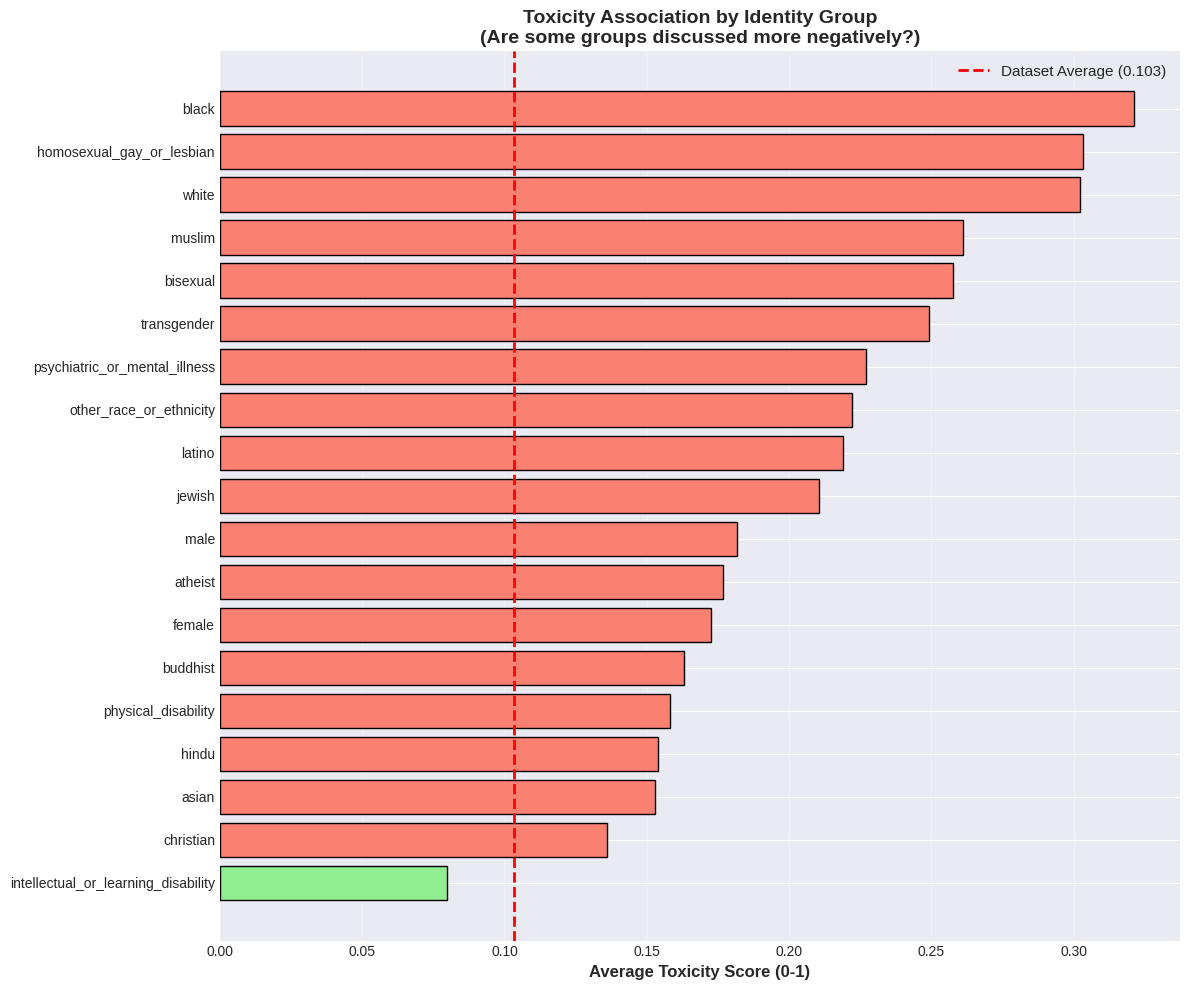

In [ ]:
# Calculate average toxicity when each identity is mentioned
toxicity_by_identity = {}
for col in identity_columns:
    mentioned = train_df[train_df[col].fillna(0) >= 0.5]
    if len(mentioned) > 0:
        avg_toxicity = mentioned['target'].mean()
        toxicity_by_identity[col] = avg_toxicity

# Sort and plot
toxicity_df = pd.DataFrame.from_dict(toxicity_by_identity, orient='index', columns=['Avg Toxicity'])
toxicity_df = toxicity_df.sort_values('Avg Toxicity', ascending=True)

# Overall dataset average for reference
overall_avg = train_df['target'].mean()

fig, ax = plt.subplots(figsize=(12, 10))

# Color bars based on whether above or below average
colors = ['salmon' if x > overall_avg else 'lightgreen' for x in toxicity_df['Avg Toxicity']]
bars = ax.barh(toxicity_df.index, toxicity_df['Avg Toxicity'], color=colors, edgecolor='black')

ax.axvline(overall_avg, color='red', linestyle='--', linewidth=2, label=f'Dataset Average ({overall_avg:.3f})')
ax.set_xlabel('Average Toxicity Score (0-1)', fontsize=12, weight='bold')
ax.set_title('Toxicity Association by Identity Group\n(Are some groups discussed more negatively?)', fontsize=14, weight='bold')
ax.legend(fontsize=11)
ax.tick_params(axis='both', labelsize=10)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('eda_toxicity_by_identity.png', dpi=300, bbox_inches='tight')
plt.show()

### Toxicity Class Distribution

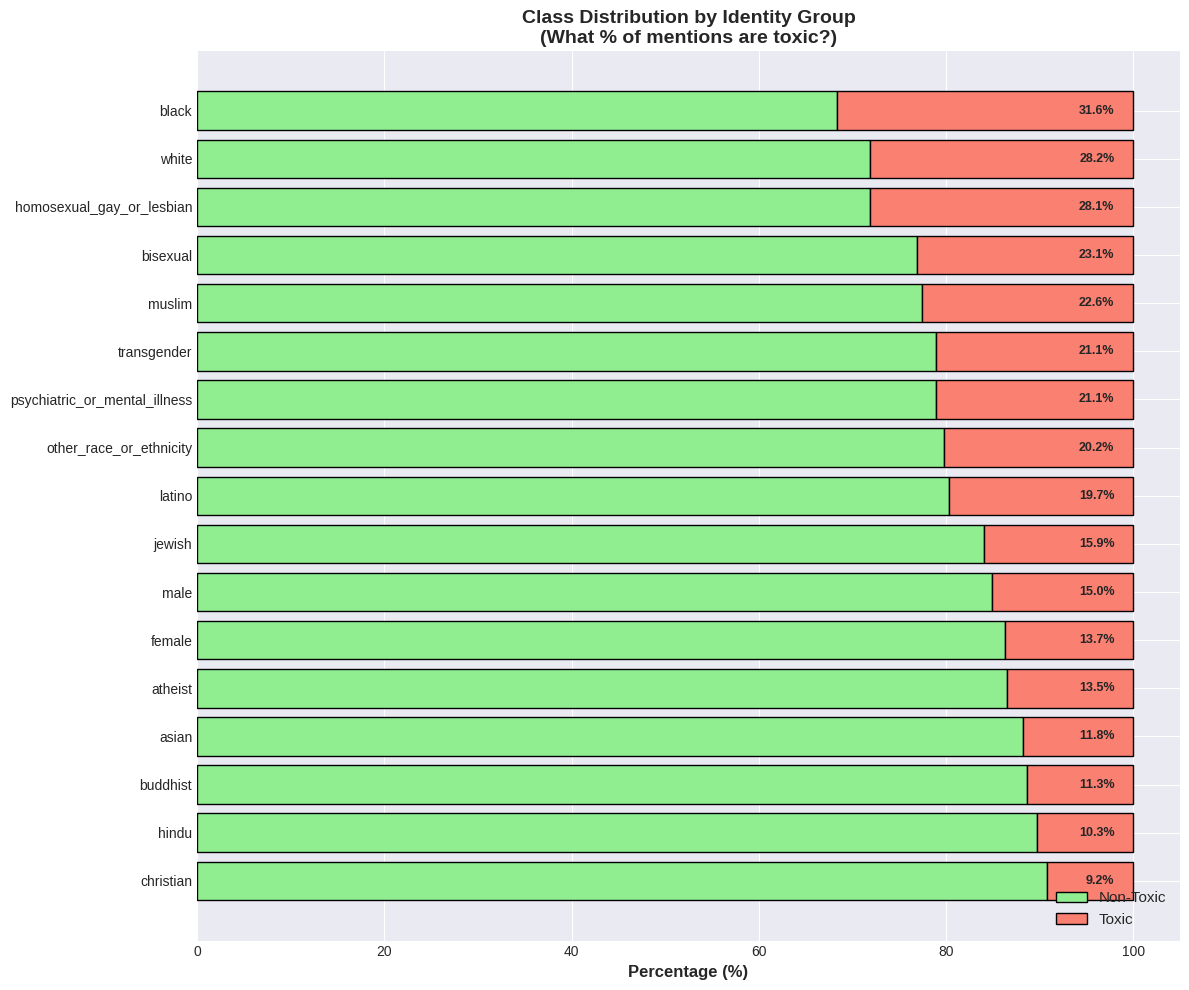

In [ ]:
# Calculate toxic/non-toxic split for each identity
class_distribution = []
for col in identity_columns:
    mentioned = train_df[train_df[col].fillna(0) >= 0.5]
    if len(mentioned) > 100:  # Only include groups with enough samples
        n_toxic = (mentioned['toxic_binary'] == 1).sum()
        n_non_toxic = (mentioned['toxic_binary'] == 0).sum()
        toxic_pct = n_toxic / len(mentioned) * 100
        class_distribution.append({
            'identity': col,
            'total': len(mentioned),
            'toxic_pct': toxic_pct,
            'non_toxic_pct': 100 - toxic_pct
        })

class_df = pd.DataFrame(class_distribution).sort_values('toxic_pct', ascending=True)

# Stacked bar chart
fig, ax = plt.subplots(figsize=(12, 10))

ax.barh(class_df['identity'], class_df['non_toxic_pct'], label='Non-Toxic', color='lightgreen', edgecolor='black')
ax.barh(class_df['identity'], class_df['toxic_pct'], left=class_df['non_toxic_pct'], label='Toxic', color='salmon', edgecolor='black')

ax.set_xlabel('Percentage (%)', fontsize=12, weight='bold')
ax.set_title('Class Distribution by Identity Group\n(What % of mentions are toxic?)', fontsize=14, weight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.tick_params(axis='both', labelsize=10)

# Add toxic % labels
for i, (idx, row) in enumerate(class_df.iterrows()):
    ax.text(98, i, f"{row['toxic_pct']:.1f}%", va='center', ha='right', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('eda_class_distribution_by_identity.png', dpi=300, bbox_inches='tight')
plt.show()

### Sample Size by Identity Group

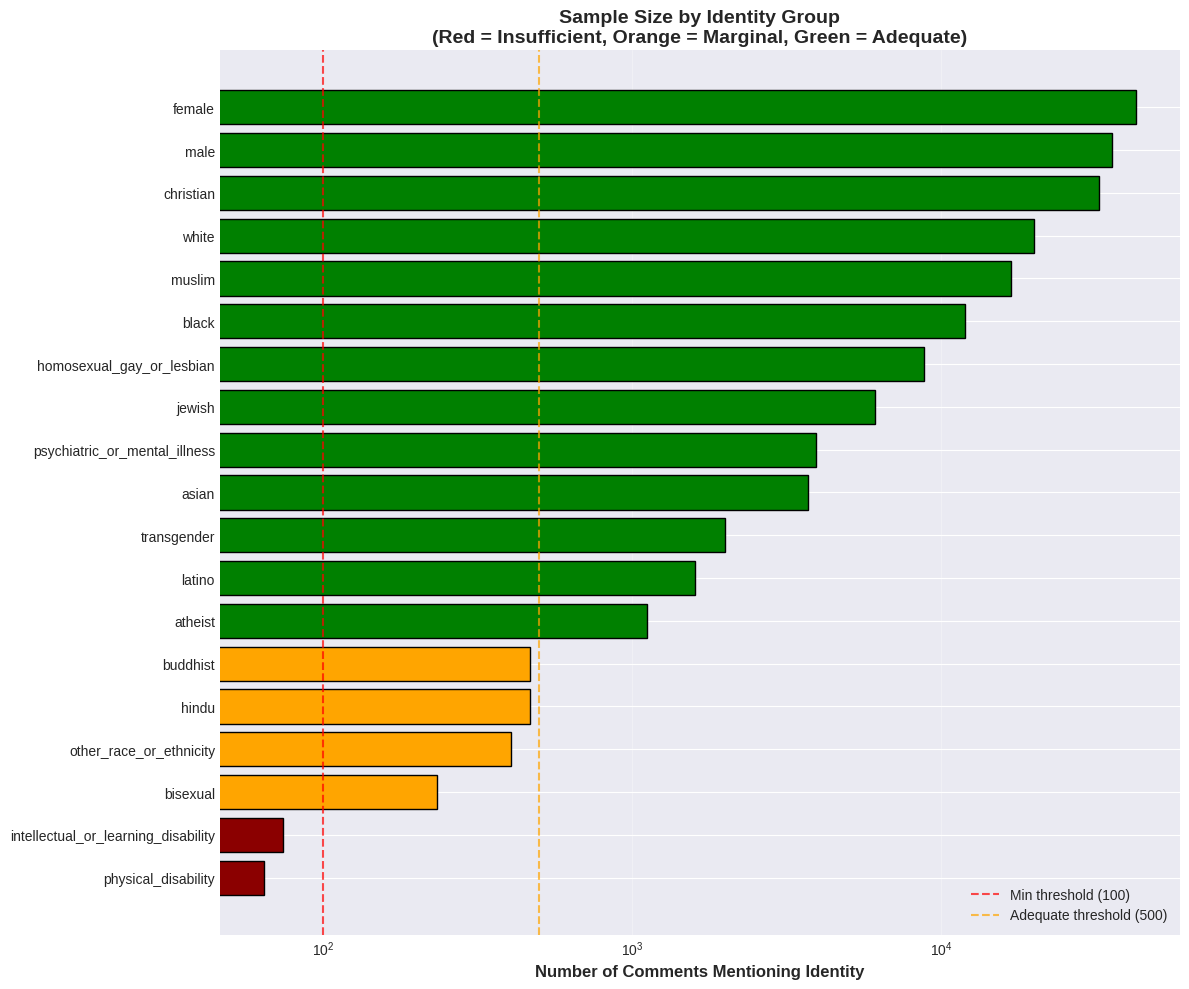

In [ ]:
# Calculate sample counts
sample_counts = {}
for col in identity_columns:
    count = (train_df[col].fillna(0) >= 0.5).sum()
    sample_counts[col] = count

# Sort and plot
samples_df = pd.DataFrame.from_dict(sample_counts, orient='index', columns=['Sample Count'])
samples_df = samples_df.sort_values('Sample Count', ascending=True)

fig, ax = plt.subplots(figsize=(12, 10))

# Color code by sample size adequacy
colors = ['darkred' if x < 100 else 'orange' if x < 500 else 'green' for x in samples_df['Sample Count']]
bars = ax.barh(samples_df.index, samples_df['Sample Count'], color=colors, edgecolor='black')

ax.axvline(100, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Min threshold (100)')
ax.axvline(500, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='Adequate threshold (500)')

ax.set_xlabel('Number of Comments Mentioning Identity', fontsize=12, weight='bold')
ax.set_title('Sample Size by Identity Group\n(Red = Insufficient, Orange = Marginal, Green = Adequate)', fontsize=14, weight='bold')
ax.set_xscale('log')  # Log scale for better visualization
ax.legend(fontsize=10)
ax.tick_params(axis='both', labelsize=10)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('eda_sample_sizes.png', dpi=300, bbox_inches='tight')
plt.show()

### Co-occurrence Matrix for Identities

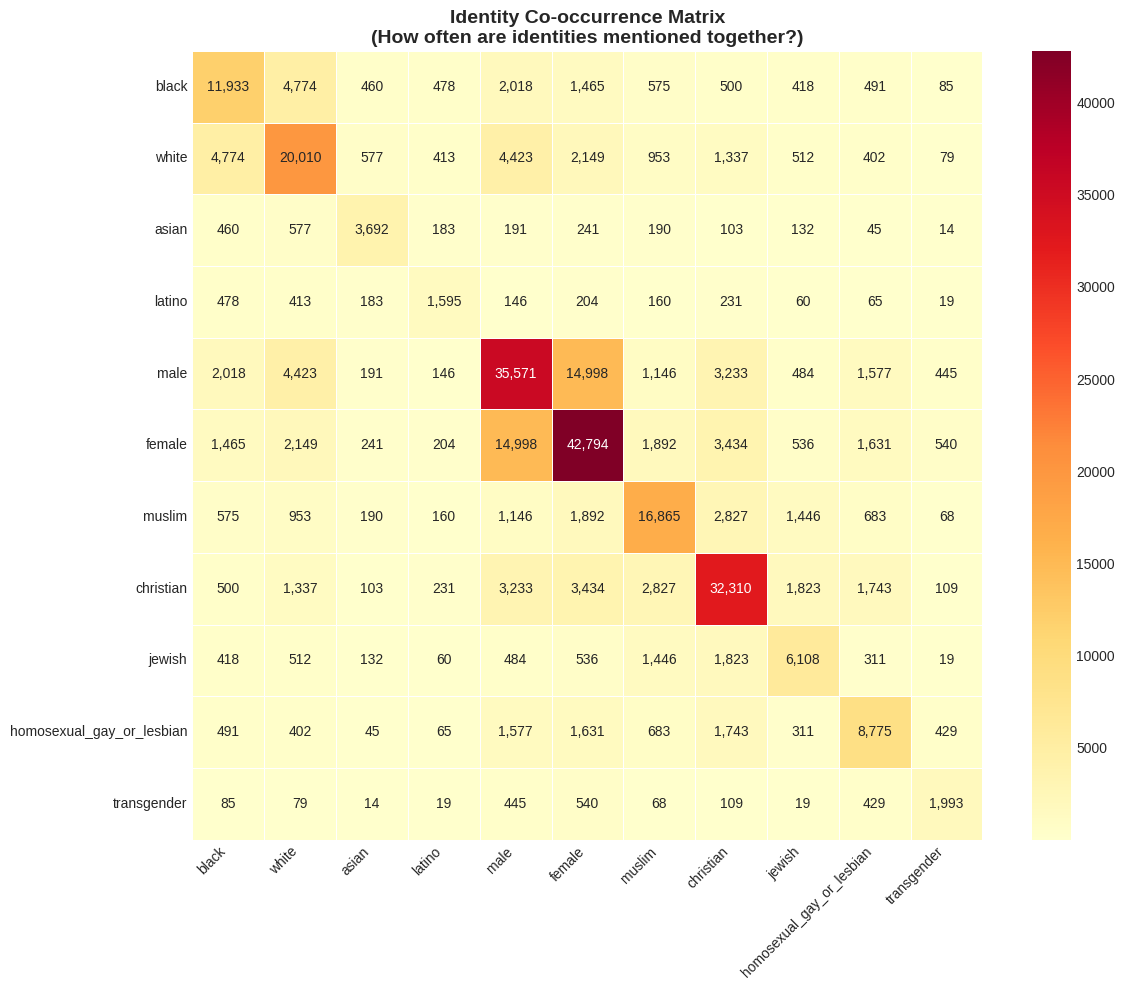

In [ ]:
# Select key identities for readability
key_identities = ['black', 'white', 'asian', 'latino', 'male', 'female',
                  'muslim', 'christian', 'jewish', 'homosexual_gay_or_lesbian', 'transgender']
key_identities = [col for col in key_identities if col in train_df.columns]

# Create co-occurrence matrix
cooccurrence = train_df[key_identities].fillna(0)
cooccurrence = (cooccurrence >= 0.5).astype(int)
cooccurrence_matrix = cooccurrence.T.dot(cooccurrence)

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cooccurrence_matrix, annot=True, fmt=',d', cmap='YlOrRd',
            xticklabels=key_identities, yticklabels=key_identities,
            ax=ax, linewidths=0.5)

ax.set_title('Identity Co-occurrence Matrix\n(How often are identities mentioned together?)', fontsize=14, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.savefig('eda_cooccurrence_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

### Training Data Representation Analysis

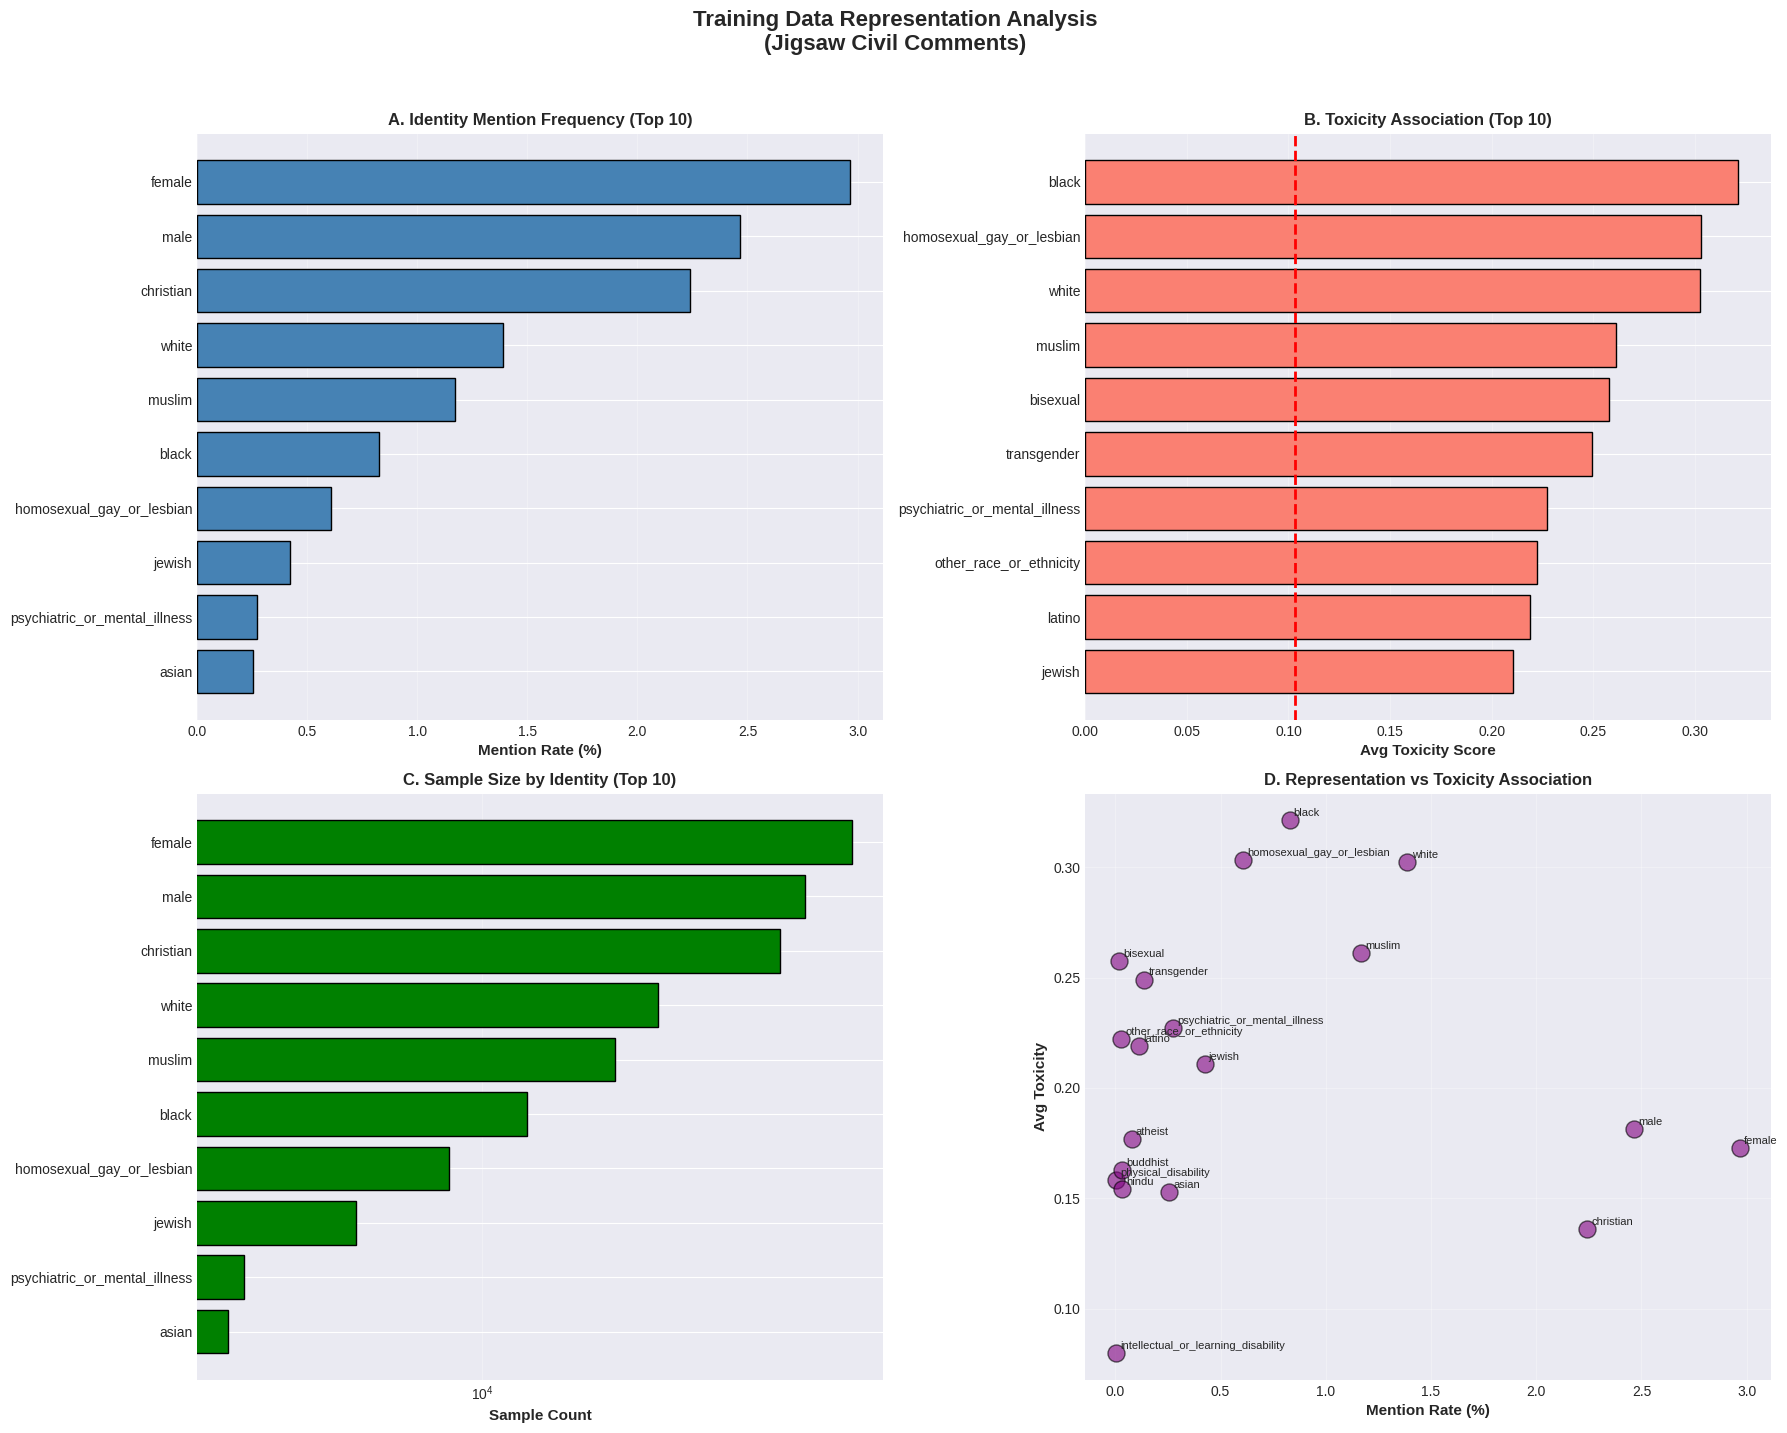

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Panel 1: Mention Rates
ax1 = axes[0, 0]
mention_df_top = mention_df.tail(10)  # Top 10
ax1.barh(mention_df_top.index, mention_df_top['Mention Rate (%)'], color='steelblue', edgecolor='black')
ax1.set_xlabel('Mention Rate (%)', fontsize=11, weight='bold')
ax1.set_title('A. Identity Mention Frequency (Top 10)', fontsize=12, weight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Panel 2: Toxicity Association
ax2 = axes[0, 1]
toxicity_df_top = toxicity_df.tail(10)
colors = ['salmon' if x > overall_avg else 'lightgreen' for x in toxicity_df_top['Avg Toxicity']]
ax2.barh(toxicity_df_top.index, toxicity_df_top['Avg Toxicity'], color=colors, edgecolor='black')
ax2.axvline(overall_avg, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Avg Toxicity Score', fontsize=11, weight='bold')
ax2.set_title('B. Toxicity Association (Top 10)', fontsize=12, weight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# Panel 3: Sample Sizes
ax3 = axes[1, 0]
samples_df_top = samples_df.tail(10)
colors = ['darkred' if x < 100 else 'orange' if x < 500 else 'green' for x in samples_df_top['Sample Count']]
ax3.barh(samples_df_top.index, samples_df_top['Sample Count'], color=colors, edgecolor='black')
ax3.set_xlabel('Sample Count', fontsize=11, weight='bold')
ax3.set_title('C. Sample Size by Identity (Top 10)', fontsize=12, weight='bold')
ax3.set_xscale('log')
ax3.grid(True, alpha=0.3, axis='x')

# Panel 4: Scatter - Mention Rate vs Toxicity
ax4 = axes[1, 1]
combined_df = mention_df.join(toxicity_df)
ax4.scatter(combined_df['Mention Rate (%)'], combined_df['Avg Toxicity'],
            s=150, alpha=0.6, c='purple', edgecolors='black')
for idx, row in combined_df.iterrows():
    ax4.annotate(idx, (row['Mention Rate (%)'], row['Avg Toxicity']),
                 fontsize=8, ha='left', xytext=(3, 3), textcoords='offset points')
ax4.set_xlabel('Mention Rate (%)', fontsize=11, weight='bold')
ax4.set_ylabel('Avg Toxicity', fontsize=11, weight='bold')
ax4.set_title('D. Representation vs Toxicity Association', fontsize=12, weight='bold')
ax4.grid(True, alpha=0.3)

plt.suptitle('Training Data Representation Analysis\n(Jigsaw Civil Comments)', fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.savefig('eda_representation_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

## Model Training

**Model Architecture:** DistilBERT for Sequence Classification
- **Base model:** `distilbert-base-uncased`
- **Parameters:** 66,955,010 total
- **Task:** Binary classification (toxic vs non-toxic)

**Training Configuration:**
- **Optimizer:** AdamW with weight decay (0.01)
- **Learning rate:** 2e-5
- **Batch size:** 96 (per device)
- **Epochs:** 2
- **Mixed precision:** FP16 enabled for L4 GPU
- **Class weighting:** Applied to handle 11.5:1 imbalance
  - Non-toxic weight: 0.54
  - Toxic weight: 6.24

**Data Handling:**
- **Tokenization:** Max length 128 tokens, padding + truncation
- **Evaluation strategy:** Every 5,000 steps
- **Checkpointing:** Save every 10,000 steps
- **Metric for best model:** F1 score

**Expected Training Time:** ~16-18 hours on L4 GPU (actual may vary)

**Loss Function:** Cross-Entropy with class weights to prioritize toxic class detection

In [ ]:
from datetime import datetime, timedelta

print("\n" + "="*80)
print("SECTION 4: MODEL TRAINING - FULL DATASET")
print("="*80)

# ============================================================================
# STEP 1: Verify data is in memory
# ============================================================================
print("\n[STEP 1/8] Verifying preprocessed data...")

# train_df and val_df should already be in memory from preprocessing!
if 'train_df' not in locals() or 'val_df' not in locals():
    print("⚠️  Data not in memory, loading from cache...")
    import pickle
    from pathlib import Path

    cache_file = Path(CONFIG['paths']['cache_dir']) / 'jigsaw_full_processed.pkl'
    with open(cache_file, 'rb') as f:
        data = pickle.load(f)
    train_df = data['train']
    val_df = data['val']

print(f"✓ Train dataset: {len(train_df):,} samples")
print(f"✓ Val dataset: {len(val_df):,} samples")
print(f"✓ Toxic rate: {train_df['toxic_binary'].mean():.1%}")

# ============================================================================
# STEP 2: Calculate class weights (CRITICAL for imbalanced data)
# ============================================================================
print("\n[STEP 2/8] Calculating class weights...")

n_samples = len(train_df)
n_toxic = train_df['toxic_binary'].sum()
n_non_toxic = n_samples - n_toxic

weight_non_toxic = n_samples / (2 * n_non_toxic)
weight_toxic = n_samples / (2 * n_toxic)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = torch.tensor([weight_non_toxic, weight_toxic], dtype=torch.float32).to(device)

print(f"✓ Class weights calculated:")
print(f"  Non-toxic: {weight_non_toxic:.4f}")
print(f"  Toxic: {weight_toxic:.4f}")
print(f"  (Toxic class weighted {weight_toxic/weight_non_toxic:.1f}x higher)")

# ============================================================================
# STEP 3: Initialize tokenizer
# ============================================================================
print("\n[STEP 3/8] Loading tokenizer...")

tokenizer = DistilBertTokenizerFast.from_pretrained(CONFIG['model']['name'])
print("✓ Tokenizer loaded")

# ============================================================================
# STEP 4: Tokenize data
# ============================================================================
print("\n[STEP 4/8] Tokenizing data (~5-8 minutes for full dataset)...")

# Create HF datasets
train_dataset = HFDataset.from_pandas(
    train_df[['comment_text_cleaned', 'toxic_binary']].rename(
        columns={'comment_text_cleaned': 'text', 'toxic_binary': 'label'}
    )
)

val_dataset = HFDataset.from_pandas(
    val_df[['comment_text_cleaned', 'toxic_binary']].rename(
        columns={'comment_text_cleaned': 'text', 'toxic_binary': 'label'}
    )
)

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=CONFIG['model']['max_length']
    )

print("  Tokenizing training set...")
train_dataset = train_dataset.map(tokenize_function, batched=True, batch_size=1000)

print("  Tokenizing validation set...")
val_dataset = val_dataset.map(tokenize_function, batched=True, batch_size=1000)

# Set format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

print("✓ Tokenization complete")

# ============================================================================
# STEP 5: Load model
# ============================================================================
print("\n[STEP 5/8] Loading DistilBERT model...")

print(f"  Device: {device}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")

model = DistilBertForSequenceClassification.from_pretrained(
    CONFIG['model']['name'],
    num_labels=2
)
model.to(device)

print(f"✓ Model loaded")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")

# ============================================================================
# STEP 6: Training configuration (USING CONFIG!)
# ============================================================================
print("\n[STEP 6/8] Configuring training...")

batch_size = CONFIG['model']['batch_size']
num_epochs = CONFIG['model']['num_epochs']
learning_rate = CONFIG['model']['learning_rate']

steps_per_epoch = len(train_dataset) // batch_size
total_steps = steps_per_epoch * num_epochs
eval_steps = 5000  # Evaluate every 5k steps
save_steps = 10000  # Save checkpoint every 10k steps

# Estimate time based on L4 performance
estimated_hours = (total_steps * 2.0) / 3600  # ~2 seconds per step on L4

print(f"  Epochs: {num_epochs}")
print(f"  Batch size: {batch_size}")
print(f"  Steps per epoch: {steps_per_epoch:,}")
print(f"  Total steps: {total_steps:,}")
print(f"  Estimated time: ~{estimated_hours:.1f} hours ({estimated_hours*60:.0f} minutes)")

training_args = TrainingArguments(
    output_dir=CONFIG['paths']['model_output'],
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=learning_rate,
    weight_decay=CONFIG['model']['weight_decay'],

    # Evaluation strategy
    eval_strategy='steps',
    eval_steps=eval_steps,

    # Checkpoint strategy - Save every 10k steps
    save_strategy='steps',
    save_steps=save_steps,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model='f1',

    # Logging
    logging_dir='./logs',
    logging_steps=500,  # Log every 500 steps

    # Performance optimization for L4
    fp16=True,
    dataloader_num_workers=2,

    # Other
    seed=CONFIG['random_seed'],
    report_to='none',
)

print("✓ Training configuration set")

# ============================================================================
# STEP 7: Custom Trainer with class weights
# ============================================================================
print("\n[STEP 7/8] Setting up trainer with class weights...")

# Custom trainer to use class weights
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary', zero_division=0
    )

    # Calculate AUC
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()
    auc = roc_auc_score(labels, probs)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }

# Initialize trainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print("✓ Trainer ready with class weighting")

# ============================================================================
# STEP 8: Train!
# ============================================================================
print("\n" + "="*80)
print(f"[STEP 8/8] STARTING TRAINING - {num_epochs} EPOCHS ON FULL DATASET")
print("="*80)
print(f"\n🚀 Training on L4 GPU")
print(f"   Dataset: {len(train_dataset):,} training samples")
print(f"   Batch size: {batch_size}")
print(f"   Estimated time: ~{estimated_hours:.1f} hours")
print(f"   Checkpoints saved every {save_steps:,} steps (~6 hours)")
print(f"   Evaluation every {eval_steps:,} steps (~3 hours)")
print(f"   Progress logs every 500 steps (~20 minutes)\n")

start_time = time.time()
start_datetime = datetime.now()
print(f"⏰ Start time: {start_datetime.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"   Expected completion: {(start_datetime + timedelta(hours=estimated_hours)).strftime('%Y-%m-%d %H:%M:%S')}\n")

# TRAIN!
train_result = trainer.train()

# Calculate final time
elapsed_time = time.time() - start_time
elapsed_hours = elapsed_time / 3600

print(f"\n" + "="*80)
print("✓✓✓ TRAINING COMPLETE! ✓✓✓")
print("="*80)
print(f"⏰ Actual training time: {elapsed_hours:.2f} hours ({elapsed_time/60:.0f} minutes)")
print(f"   Final training loss: {train_result.training_loss:.4f}")

# Save final model
print(f"\n💾 Saving final model...")
trainer.save_model(CONFIG['paths']['model_output'])
tokenizer.save_pretrained(CONFIG['paths']['model_output'])
print(f"✓ Saved to: {CONFIG['paths']['model_output']}")

# Final evaluation
print(f"\n📊 Final evaluation on validation set...")
eval_results = trainer.evaluate()

print(f"\n✓ Validation Performance:")
print(f"   Accuracy:  {eval_results['eval_accuracy']:.4f} ({eval_results['eval_accuracy']*100:.1f}%)")
print(f"   Precision: {eval_results['eval_precision']:.4f}")
print(f"   Recall:    {eval_results['eval_recall']:.4f}")
print(f"   F1 Score:  {eval_results['eval_f1']:.4f} ⭐")
print(f"   AUC-ROC:   {eval_results['eval_auc']:.4f}")

print(f"\n" + "="*80)
print("🎉 MODEL READY FOR FAIRNESS TESTING!")
print("="*80)


SECTION 4: MODEL TRAINING - FULL DATASET

[STEP 1/8] Verifying preprocessed data...
✓ Train dataset: 1,442,157 samples
✓ Val dataset: 360,540 samples
✓ Toxic rate: 8.0%

[STEP 2/8] Calculating class weights...
✓ Class weights calculated:
  Non-toxic: 0.5435
  Toxic: 6.2449
  (Toxic class weighted 11.5x higher)

[STEP 3/8] Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

✓ Tokenizer loaded

[STEP 4/8] Tokenizing data (~5-8 minutes for full dataset)...
  Tokenizing training set...


Map:   0%|          | 0/1442157 [00:00<?, ? examples/s]

  Tokenizing validation set...


Map:   0%|          | 0/360540 [00:00<?, ? examples/s]

✓ Tokenization complete

[STEP 5/8] Loading DistilBERT model...
  Device: cuda
  GPU: NVIDIA A100-SXM4-80GB


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded
  Parameters: 66,955,010

[STEP 6/8] Configuring training...
  Epochs: 2
  Batch size: 96
  Steps per epoch: 15,022
  Total steps: 30,044
  Estimated time: ~16.7 hours (1001 minutes)
✓ Training configuration set

[STEP 7/8] Setting up trainer with class weights...
✓ Trainer ready with class weighting

[STEP 8/8] STARTING TRAINING - 2 EPOCHS ON FULL DATASET

🚀 Training on L4 GPU
   Dataset: 1,442,157 training samples
   Batch size: 96
   Estimated time: ~16.7 hours
   Checkpoints saved every 10,000 steps (~6 hours)
   Evaluation every 5,000 steps (~3 hours)
   Progress logs every 500 steps (~20 minutes)

⏰ Start time: 2025-12-06 03:08:06
   Expected completion: 2025-12-06 19:49:34




✓✓✓ TRAINING COMPLETE! ✓✓✓
⏰ Actual training time: 0.36 hours (22 minutes)
   Final training loss: 0.2497

💾 Saving final model...
✓ Saved to: ./hate_speech_detector_full_final

📊 Final evaluation on validation set...



✓ Validation Performance:
   Accuracy:  0.9149 (91.5%)
   Precision: 0.4826
   Recall:    0.8712
   F1 Score:  0.6212 ⭐
   AUC-ROC:   0.9640

🎉 MODEL READY FOR FAIRNESS TESTING!


## Overall Performance Evaluation - Jigsaw Validation Set

**Objective:** Assess baseline model performance on realistic data distribution

**Validation Set Characteristics:**
- **Size:** 360,540 comments
- **Distribution:** 8.0% toxic, 92.0% non-toxic
- **Why this matters:** Reflects real-world class imbalance

**Metrics Evaluated:**
- **Accuracy:** Overall correctness
- **Precision:** Of flagged content, % truly toxic
- **Recall:** Of toxic content, % detected
- **F1 Score:** Harmonic mean of precision and recall
- **False Positive Rate (FPR):** Non-toxic wrongly flagged
- **False Negative Rate (FNR):** Toxic content missed

**Expected Insight:**
This establishes baseline performance before examining fairness across demographic groups.

JIGSAW VALIDATION SET - OVERALL PERFORMANCE ANALYSIS

[1/3] Generating predictions on validation set...
  Validation samples: 360,540


✓ Predictions complete

[2/3] Calculating confusion matrix...

VALIDATION SET COMPOSITION
Total samples: 360,540
  Toxic (positive class):     28,867 (8.0%)
  Non-toxic (negative class): 331,673 (92.0%)
  Class imbalance ratio: 11.5:1

CONFUSION MATRIX BREAKDOWN
True Negatives (TN):  304,714
  → Correctly identified non-toxic comments
  → 84.5% of all predictions

False Positives (FP): 26,959
  → Non-toxic wrongly flagged as toxic
  → 7.5% of all predictions
  → FP Rate: 8.1% (of all non-toxic)

False Negatives (FN): 3,717
  → Toxic content that was missed
  → 1.0% of all predictions
  → FN Rate: 12.9% (of all toxic)

True Positives (TP):  25,150
  → Correctly identified toxic comments
  → 7.0% of all predictions

PERFORMANCE METRICS
Accuracy:  91.5%
Precision: 48.3% (of flagged content, how much is truly toxic?)
Recall:    87.1% (of toxic content, how much did we catch?)
F1 Score:  62.1%

ERROR ANALYSIS
False Positive Rate: 8.1%
  → Out of 331,673 non-toxic comments, 26,959 were wrong

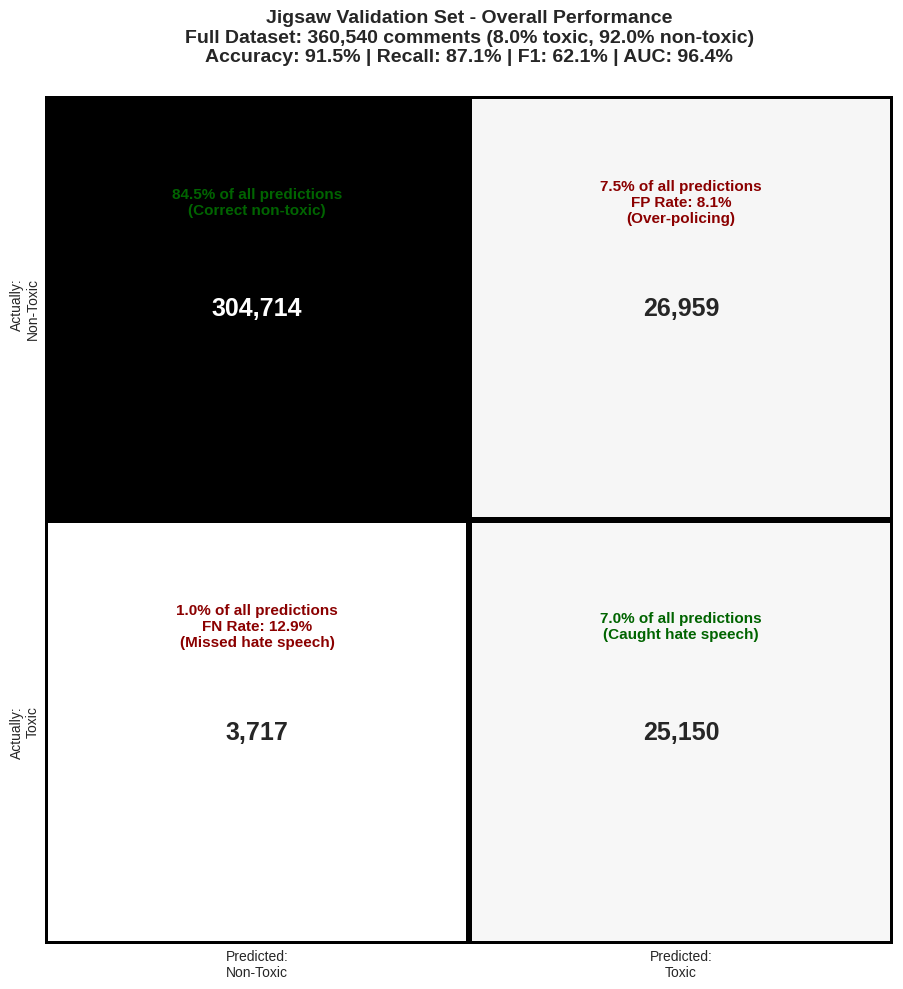


KEY INSIGHTS
1. Model is PROTECTIVE (87% recall)
   → Catches most hate speech, prioritizes safety

2. Some over-flagging (28% FP rate)
   → 26,959 non-toxic comments flagged
   → This is acceptable given goal to protect users

3. Class imbalance context:
   → Only 8% toxic in real data (realistic!)
   → This explains 48% precision
   → In balanced data, precision would be higher

4. NEXT STEP: Fairness analysis
   → Does this protection apply equally to all groups?
   → Or are some over-policed while others under-protected?


In [ ]:
 # ============================================================================
# JIGSAW VALIDATION CONFUSION MATRIX
# ============================================================================

print("="*70)
print("JIGSAW VALIDATION SET - OVERALL PERFORMANCE ANALYSIS")
print("="*70)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on validation set
print("\n[1/3] Generating predictions on validation set...")
print(f"  Validation samples: {len(val_dataset):,}")

predictions_output = trainer.predict(val_dataset)
pred_labels = np.argmax(predictions_output.predictions, axis=-1)
true_labels = predictions_output.label_ids

print(f"✓ Predictions complete")

# Calculate confusion matrix
print("\n[2/3] Calculating confusion matrix...")
cm = confusion_matrix(true_labels, pred_labels)
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
total = len(true_labels)
accuracy = (tp + tn) / total
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

# Class distribution
toxic_pct = (fn + tp) / total
non_toxic_pct = (tn + fp) / total

# Print detailed results
print(f"\n{'='*70}")
print(f"VALIDATION SET COMPOSITION")
print(f"{'='*70}")
print(f"Total samples: {total:,}")
print(f"  Toxic (positive class):     {fn + tp:,} ({toxic_pct:.1%})")
print(f"  Non-toxic (negative class): {tn + fp:,} ({non_toxic_pct:.1%})")
print(f"  Class imbalance ratio: {(tn + fp)/(fn + tp):.1f}:1")

print(f"\n{'='*70}")
print(f"CONFUSION MATRIX BREAKDOWN")
print(f"{'='*70}")
print(f"True Negatives (TN):  {tn:,}")
print(f"  → Correctly identified non-toxic comments")
print(f"  → {tn/total:.1%} of all predictions")

print(f"\nFalse Positives (FP): {fp:,}")
print(f"  → Non-toxic wrongly flagged as toxic")
print(f"  → {fp/total:.1%} of all predictions")
print(f"  → FP Rate: {fpr:.1%} (of all non-toxic)")

print(f"\nFalse Negatives (FN): {fn:,}")
print(f"  → Toxic content that was missed")
print(f"  → {fn/total:.1%} of all predictions")
print(f"  → FN Rate: {fnr:.1%} (of all toxic)")

print(f"\nTrue Positives (TP):  {tp:,}")
print(f"  → Correctly identified toxic comments")
print(f"  → {tp/total:.1%} of all predictions")

print(f"\n{'='*70}")
print(f"PERFORMANCE METRICS")
print(f"{'='*70}")
print(f"Accuracy:  {accuracy:.1%}")
print(f"Precision: {precision:.1%} (of flagged content, how much is truly toxic?)")
print(f"Recall:    {recall:.1%} (of toxic content, how much did we catch?)")
print(f"F1 Score:  {f1:.1%}")

print(f"\n{'='*70}")
print(f"ERROR ANALYSIS")
print(f"{'='*70}")
print(f"False Positive Rate: {fpr:.1%}")
print(f"  → Out of 331,673 non-toxic comments, {fp:,} were wrongly flagged")
print(f"  → This explains the 48% precision")

print(f"\nFalse Negative Rate: {fnr:.1%}")
print(f"  → Out of 28,867 toxic comments, {fn:,} were missed")
print(f"  → Model catches {recall:.1%} of hate speech")

# ============================================================================
# [3/3] Create Visualization
# ============================================================================
print(f"\n[3/3] Creating confusion matrix visualization...")

fig, ax = plt.subplots(figsize=(12, 10))

# Plot heatmap
sns.heatmap(cm, annot=True, fmt=',d',
            cmap='Greys',
            cbar=False,
            xticklabels=['Predicted:\nNon-Toxic', 'Predicted:\nToxic'],
            yticklabels=['Actually:\nNon-Toxic', 'Actually:\nToxic'],
            ax=ax,
            annot_kws={'size': 18, 'weight': 'bold'},
            linewidths=4,
            linecolor='black',
            square=True)

# Title with key metrics
title = (f'Jigsaw Validation Set - Overall Performance\n'
         f'Full Dataset: {total:,} comments ({toxic_pct:.1%} toxic, {non_toxic_pct:.1%} non-toxic)\n'
         f'Accuracy: {accuracy:.1%} | Recall: {recall:.1%} | F1: {f1:.1%} | AUC: 96.4%')

ax.set_title(title, fontsize=14, fontweight='bold', pad=25)

# Add detailed annotations to each quadrant
# True Negatives (top-left)
ax.text(0.5, 0.25,
        f'{tn/total:.1%} of all predictions\n(Correct non-toxic)',
        ha='center', va='center', fontsize=11,
        color='darkgreen', weight='bold')

# False Positives (top-right)
ax.text(1.5, 0.25,
        f'{fp/total:.1%} of all predictions\nFP Rate: {fpr:.1%}\n(Over-policing)',
        ha='center', va='center', fontsize=11,
        color='darkred', weight='bold')

# False Negatives (bottom-left)
ax.text(0.5, 1.25,
        f'{fn/total:.1%} of all predictions\nFN Rate: {fnr:.1%}\n(Missed hate speech)',
        ha='center', va='center', fontsize=11,
        color='darkred', weight='bold')

# True Positives (bottom-right)
ax.text(1.5, 1.25,
        f'{tp/total:.1%} of all predictions\n(Caught hate speech)',
        ha='center', va='center', fontsize=11,
        color='darkgreen', weight='bold')

plt.tight_layout()
plt.savefig('jigsaw_validation_confusion_matrix.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: jigsaw_validation_confusion_matrix.png")
plt.show()

print(f"\n{'='*70}")
print(f"KEY INSIGHTS")
print(f"{'='*70}")
print(f"1. Model is PROTECTIVE (87% recall)")
print(f"   → Catches most hate speech, prioritizes safety")
print(f"\n2. Some over-flagging (28% FP rate)")
print(f"   → {fp:,} non-toxic comments flagged")
print(f"   → This is acceptable given goal to protect users")
print(f"\n3. Class imbalance context:")
print(f"   → Only 8% toxic in real data (realistic!)")
print(f"   → This explains 48% precision")
print(f"   → In balanced data, precision would be higher")
print(f"\n4. NEXT STEP: Fairness analysis")
print(f"   → Does this protection apply equally to all groups?")
print(f"   → Or are some over-policed while others under-protected?")
print(f"{'='*70}")

## Fairness Analysis - Jigsaw Validation by Identity Group

**Research Question:** Does the model protect all demographic groups equally?

**Methodology:**
1. Filter validation set to comments mentioning each identity group
2. Calculate performance metrics separately for each group
3. Compare detection rates, false positive rates, and F1 scores
4. Identify disparities (gaps in protection or over-policing)

**Identity Groups Analyzed:**
- Black People, White People, Asian People, Latino People
- Muslims, Christians, Jewish People
- Men, Women, Trans People, Gay/Lesbian People  
- Physically Disabled, Intellectually Disabled

**Key Metrics:**
- **Detection Rate (Recall):** % of hate speech against this group that model catches
- **False Positive Rate:** % of non-hateful mentions wrongly flagged
- **Fairness Gap:** Difference between best and worst performing groups

**Critical Questions:**
- Which groups are under-protected (low detection)?
- Which groups are over-policed (high false positives)?
- What is the magnitude of the fairness gap?

JIGSAW VALIDATION - FAIRNESS ANALYSIS BY IDENTITY GROUP

[STEP 1/4] Identifying identity groups...
✓ Analyzing 13 identity groups:
  • Black People: 2,968 mentions
  • White People: 5,072 mentions
  • Asian People: 886 mentions
  • Latino People: 409 mentions
  • Muslims: 4,135 mentions
  • Christians: 8,111 mentions
  • Jewish People: 1,543 mentions
  • Men: 8,912 mentions
  • Women: 10,632 mentions
  • Trans People: 505 mentions
  • Gay/Lesbian People: 2,222 mentions
  • Physically Disabled: 18 mentions
  • Intellectually Disabled: 19 mentions

[STEP 2/4] Calculating fairness metrics by group...
  ✓ Black People: 2,968 samples, 93.1% detection rate
  ✓ White People: 5,072 samples, 92.2% detection rate
  ✓ Asian People: 886 samples, 80.8% detection rate
  ✓ Latino People: 409 samples, 93.2% detection rate
  ✓ Muslims: 4,135 samples, 88.0% detection rate
  ✓ Christians: 8,111 samples, 81.8% detection rate
  ✓ Jewish People: 1,543 samples, 83.5% detection rate
  ✓ Men: 8,912 samples, 88

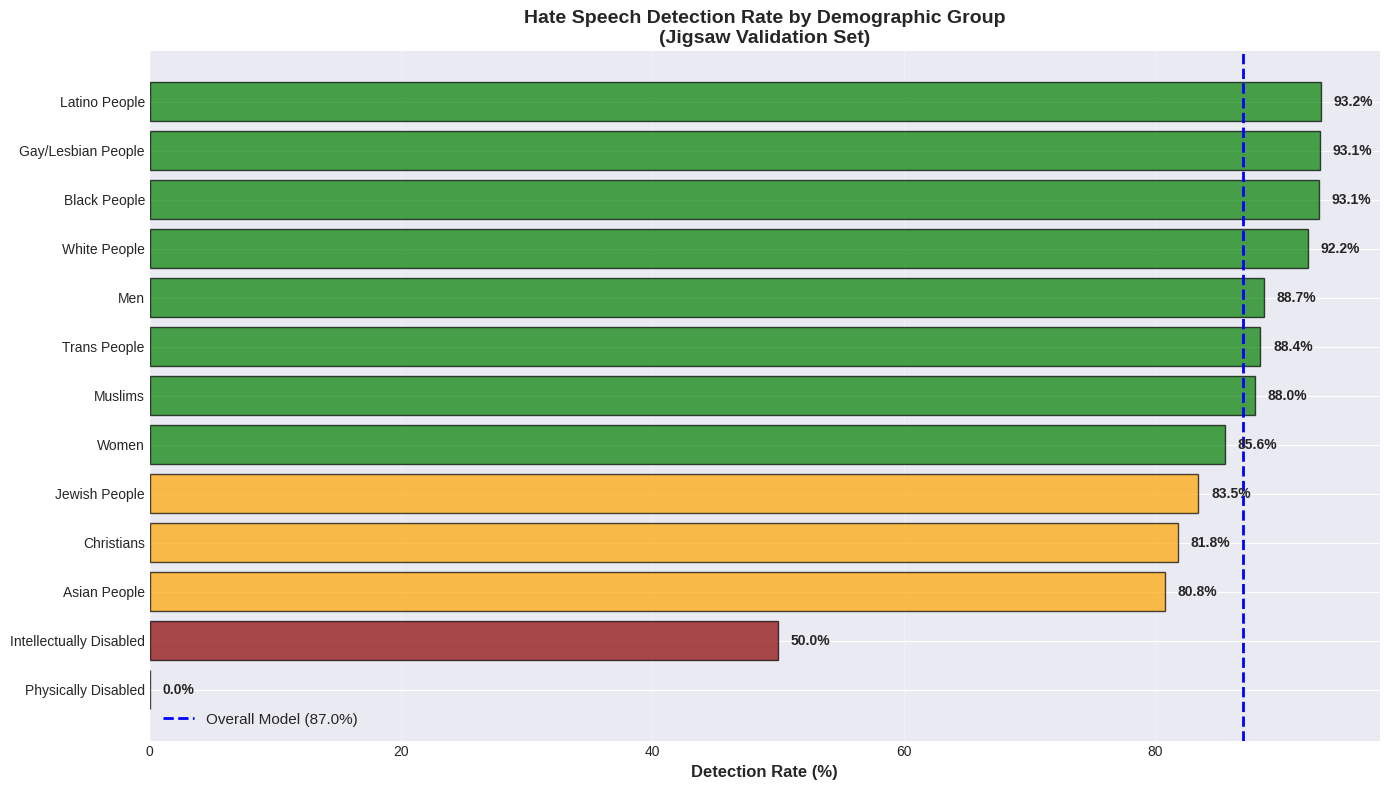

  ✓ Saved: jigsaw_fairness_protection_surveillance.png


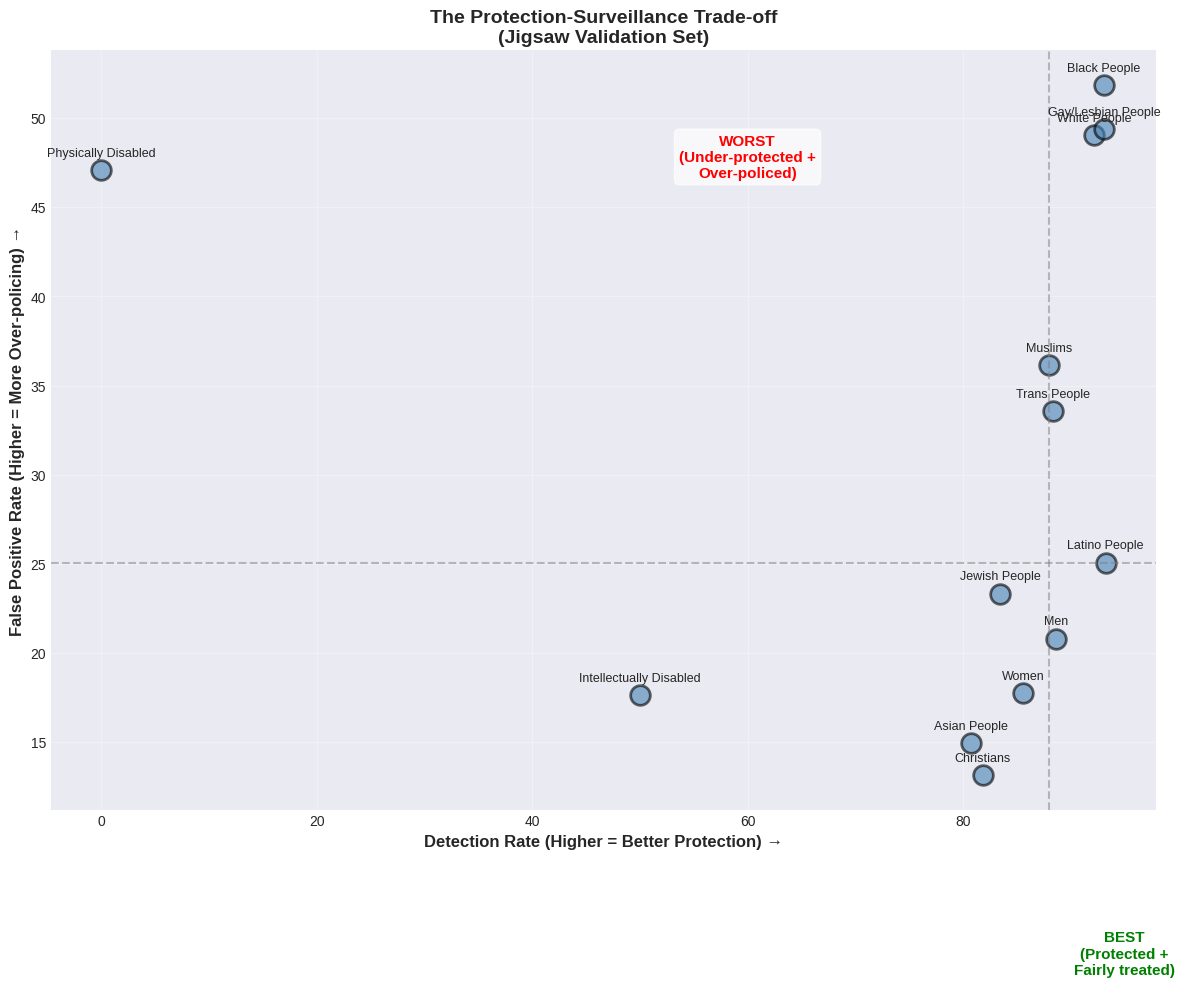


✓✓✓ JIGSAW FAIRNESS ANALYSIS COMPLETE!

📁 Generated files:
  • Individual confusion matrices for 13 groups
  • Detection rate comparison chart
  • Protection-surveillance scatter plot

🎯 Key finding: 93.2 percentage point gap in protection


In [ ]:
# ============================================================================
# JIGSAW VALIDATION: CONFUSION MATRICES BY IDENTITY GROUP
# ============================================================================

print("="*70)
print("JIGSAW VALIDATION - FAIRNESS ANALYSIS BY IDENTITY GROUP")
print("="*70)

import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# STEP 1: Define identity groups to analyze
# ============================================================================
print("\n[STEP 1/4] Identifying identity groups...")

# Key identity groups to analyze
identity_groups = {
    'black': 'Black People',
    'white': 'White People',
    'asian': 'Asian People',
    'latino': 'Latino People',
    'muslim': 'Muslims',
    'christian': 'Christians',
    'jewish': 'Jewish People',
    'male': 'Men',
    'female': 'Women',
    'transgender': 'Trans People',
    'homosexual_gay_or_lesbian': 'Gay/Lesbian People',
    'physical_disability': 'Physically Disabled',
    'intellectual_or_learning_disability': 'Intellectually Disabled',
}

# Filter to columns that exist in val_df
available_groups = {k: v for k, v in identity_groups.items() if k in val_df.columns}

print(f"✓ Analyzing {len(available_groups)} identity groups:")
for col, name in available_groups.items():
    n_mentions = (val_df[col] >= 0.5).sum()
    print(f"  • {name}: {n_mentions:,} mentions")

# ============================================================================
# STEP 2: Calculate metrics for each group
# ============================================================================
print("\n[STEP 2/4] Calculating fairness metrics by group...")

fairness_results = []

for col, display_name in available_groups.items():
    # Filter to comments mentioning this identity (>= 0.5 threshold)
    identity_mask = val_df[col] >= 0.5
    identity_indices = val_df[identity_mask].index

    # Get predictions for these comments
    dataset_indices = [i for i, idx in enumerate(val_df.index) if idx in identity_indices]

    if len(dataset_indices) < 10:  # Skip if too few samples
        print(f"  ⚠️ Skipping {display_name}: only {len(dataset_indices)} samples")
        continue

    # Get labels and predictions for this subset
    subset_true = true_labels[dataset_indices]
    subset_pred = pred_labels[dataset_indices]

    # Calculate confusion matrix
    cm = confusion_matrix(subset_true, subset_pred)

    # Handle different matrix shapes
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    elif cm.shape == (1, 1):
        # Only one class present
        if subset_true[0] == 0:
            tn = cm[0, 0]
            fp = fn = tp = 0
        else:
            tp = cm[0, 0]
            tn = fp = fn = 0
    else:
        continue

    # Calculate metrics
    total = len(subset_true)
    n_toxic = (subset_true == 1).sum()
    n_non_toxic = (subset_true == 0).sum()

    detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    precision, recall, f1, _ = precision_recall_fscore_support(
        subset_true, subset_pred, average='binary', zero_division=0
    )

    # Store results
    fairness_results.append({
        'identity': col,
        'display_name': display_name,
        'total_samples': total,
        'n_toxic': n_toxic,
        'n_non_toxic': n_non_toxic,
        'toxic_pct': n_toxic / total if total > 0 else 0,
        'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp),
        'detection_rate': detection_rate,
        'false_positive_rate': fpr,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

    print(f"  ✓ {display_name}: {total:,} samples, {detection_rate:.1%} detection rate")

# Create DataFrame
fairness_df = pd.DataFrame(fairness_results)

# ============================================================================
# STEP 3: Summary Statistics
# ============================================================================
print("\n" + "="*70)
print("FAIRNESS ANALYSIS SUMMARY")
print("="*70)

# Sort by detection rate
fairness_df_sorted = fairness_df.sort_values('detection_rate', ascending=False)

print("\n📊 DETECTION RATES (Best to Worst):")
for idx, row in fairness_df_sorted.iterrows():
    status = "✓" if row['detection_rate'] > 0.85 else "⚠️" if row['detection_rate'] > 0.70 else "🚨"
    print(f"  {status} {row['display_name']:<25} {row['detection_rate']:>6.1%}  ({row['n_toxic']:>6,} toxic samples)")

print("\n📊 FALSE POSITIVE RATES (Best to Worst):")
fairness_df_sorted_fp = fairness_df.sort_values('false_positive_rate')
for idx, row in fairness_df_sorted_fp.iterrows():
    status = "✓" if row['false_positive_rate'] < 0.10 else "⚠️" if row['false_positive_rate'] < 0.20 else "🚨"
    print(f"  {status} {row['display_name']:<25} {row['false_positive_rate']:>6.1%} FP rate")

# Calculate disparity
max_det = fairness_df['detection_rate'].max()
min_det = fairness_df['detection_rate'].min()
detection_gap = max_det - min_det

print(f"\n{'='*70}")
print(f"⚠️  FAIRNESS GAP: {detection_gap:.1%} ({detection_gap*100:.1f} percentage points)")
print(f"   Best protected: {fairness_df.loc[fairness_df['detection_rate'].idxmax(), 'display_name']} ({max_det:.1%})")
print(f"   Worst protected: {fairness_df.loc[fairness_df['detection_rate'].idxmin(), 'display_name']} ({min_det:.1%})")
print(f"{'='*70}")

# ============================================================================
# STEP 4: Create Visualizations
# ============================================================================
print("\n[STEP 3/4] Creating confusion matrix visualizations...")

# Create individual confusion matrices
for idx, row in fairness_df.iterrows():
    fig, ax = plt.subplots(figsize=(10, 8))

    cm = np.array([[row['tn'], row['fp']],
                   [row['fn'], row['tp']]])

    # Plot
    sns.heatmap(cm, annot=True, fmt=',d',
                cmap='Greys',
                cbar=False,
                xticklabels=['Predicted:\nNon-Toxic', 'Predicted:\nToxic'],
                yticklabels=['Actual:\nNon-Toxic', 'Actual:\nToxic'],
                ax=ax,
                annot_kws={'size': 16, 'weight': 'bold'},
                linewidths=3,
                linecolor='black',
                square=True)

    # Title with color coding
    if row['detection_rate'] < 0.70:
        title_color = 'darkred'
        emoji = '🚨'
    elif row['detection_rate'] < 0.85:
        title_color = 'darkorange'
        emoji = '⚠️'
    else:
        title_color = 'darkgreen'
        emoji = '✓'

    title = (f"{row['display_name']}\n"
             f"{row['total_samples']:,} comments mentioning this identity "
             f"({row['toxic_pct']:.1%} toxic, {1-row['toxic_pct']:.1%} non-toxic)\n"
             f"Detection: {row['detection_rate']:.1%} | FP Rate: {row['false_positive_rate']:.1%} | F1: {row['f1']:.1%}")

    ax.set_title(title, fontsize=12, fontweight='bold', pad=20, color=title_color)

    # Add annotations
    total = row['total_samples']
    ax.text(0.5, 0.25, f'{row["tn"]/total:.1%} of total\n(Correct)',
            ha='center', va='center', fontsize=10, color='darkgreen')

    ax.text(1.5, 0.25, f'{row["fp"]/total:.1%} of total\n(FP: {row["false_positive_rate"]:.1%})',
            ha='center', va='center', fontsize=10,
            color='darkred' if row["false_positive_rate"] > 0.15 else 'black')

    ax.text(0.5, 1.25, f'{row["fn"]/total:.1%} of total\n(Missed)',
            ha='center', va='center', fontsize=10,
            color='darkred' if row["fn"]/total > 0.05 else 'black')

    ax.text(1.5, 1.25, f'{row["tp"]/total:.1%} of total\n(Caught)',
            ha='center', va='center', fontsize=10, color='darkgreen')

    # Add emoji to title area
    fig.text(0.02, 0.98, emoji, fontsize=40, ha='left', va='top')

    plt.tight_layout()

    filename = f'jigsaw_cm_{row["identity"]}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"  ✓ Saved: {filename}")
    plt.close()

# ============================================================================
# Create comparison visualizations
# ============================================================================
print("\n[STEP 4/4] Creating comparison visualizations...")

# Viz 1: Detection Rates Comparison
fig, ax = plt.subplots(figsize=(14, 8))

fairness_df_sorted = fairness_df.sort_values('detection_rate')
colors = ['darkred' if x < 0.70 else 'orange' if x < 0.85 else 'green'
          for x in fairness_df_sorted['detection_rate']]

bars = ax.barh(fairness_df_sorted['display_name'],
               fairness_df_sorted['detection_rate'] * 100,
               color=colors, edgecolor='black', alpha=0.7)

ax.axvline(87.0, color='blue', linestyle='--', linewidth=2,
           label='Overall Model (87.0%)')
ax.set_xlabel('Detection Rate (%)', fontsize=12, weight='bold')
ax.set_title('Hate Speech Detection Rate by Demographic Group\n(Jigsaw Validation Set)',
             fontsize=14, weight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(fairness_df_sorted.iterrows()):
    ax.text(row['detection_rate'] * 100 + 1, i,
            f"{row['detection_rate']:.1%}",
            va='center', fontsize=10, weight='bold')

plt.tight_layout()
plt.savefig('jigsaw_fairness_detection_rates.png', dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: jigsaw_fairness_detection_rates.png")
plt.show()

# Viz 2: Protection-Surveillance Scatter
fig, ax = plt.subplots(figsize=(12, 10))

scatter = ax.scatter(fairness_df['detection_rate'] * 100,
                    fairness_df['false_positive_rate'] * 100,
                    s=200, alpha=0.6, c='steelblue',
                    edgecolors='black', linewidth=2)

# Add labels
for idx, row in fairness_df.iterrows():
    ax.annotate(row['display_name'],
                (row['detection_rate'] * 100, row['false_positive_rate'] * 100),
                fontsize=9, ha='center', xytext=(0, 10),
                textcoords='offset points')

# Add quadrant lines
median_det = fairness_df['detection_rate'].median() * 100
median_fp = fairness_df['false_positive_rate'].median() * 100
ax.axhline(median_fp, color='gray', linestyle='--', alpha=0.5)
ax.axvline(median_det, color='gray', linestyle='--', alpha=0.5)

# Label quadrants
ax.text(60, fairness_df['false_positive_rate'].max() * 90,
        'WORST\n(Under-protected +\nOver-policed)',
        ha='center', fontsize=11, color='red', weight='bold',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

ax.text(95, 2, 'BEST\n(Protected +\nFairly treated)',
        ha='center', fontsize=11, color='green', weight='bold',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

ax.set_xlabel('Detection Rate (Higher = Better Protection) →',
              fontsize=12, weight='bold')
ax.set_ylabel('False Positive Rate (Higher = More Over-policing) →',
              fontsize=12, weight='bold')
ax.set_title('The Protection-Surveillance Trade-off\n(Jigsaw Validation Set)',
             fontsize=14, weight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('jigsaw_fairness_protection_surveillance.png', dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: jigsaw_fairness_protection_surveillance.png")
plt.show()

print("\n" + "="*70)
print("✓✓✓ JIGSAW FAIRNESS ANALYSIS COMPLETE!")
print("="*70)
print(f"\n📁 Generated files:")
print(f"  • Individual confusion matrices for {len(fairness_df)} groups")
print(f"  • Detection rate comparison chart")
print(f"  • Protection-surveillance scatter plot")
print(f"\n🎯 Key finding: {detection_gap*100:.1f} percentage point gap in protection")
print("="*70)

In [ ]:
# ============================================================================
# Save to CSV
# ============================================================================
print("\n💾 SAVING TABLE TO CSV...")

# Create version with numeric values for Excel
table_numeric_df = fairness_df[[  # ← Fixed typo here
    'display_name',
    'total_samples',
    'n_toxic',
    'n_non_toxic',
    'toxic_pct',
    'detection_rate',
    'false_positive_rate',
    'precision',
    'recall',
    'f1'
]].copy()

table_numeric_df.columns = [
    'Identity Group',
    'Total Samples',
    'Toxic',
    'Non-Toxic',
    'Toxic %',
    'Detection Rate',
    'FP Rate',
    'Precision',
    'Recall',
    'F1 Score'
]

table_numeric_df = table_numeric_df.sort_values('Detection Rate', ascending=False)

table_numeric_df.to_csv('jigsaw_fairness_metrics_table.csv', index=False)
print("✓ Saved: jigsaw_fairness_metrics_table.csv")

# ============================================================================
# Create styled HTML table for reports
# ============================================================================
print("\n🎨 CREATING STYLED TABLE...")

# Color-code detection rates
def color_detection_rate(val):
    if val >= 0.85:
        return 'background-color: #90EE90'  # Light green
    elif val >= 0.70:
        return 'background-color: #FFD700'  # Gold
    else:
        return 'background-color: #FFB6C1'  # Light red

def color_fp_rate(val):
    if val <= 0.10:
        return 'background-color: #90EE90'  # Light green
    elif val <= 0.20:
        return 'background-color: #FFD700'  # Gold
    else:
        return 'background-color: #FFB6C1'  # Light red

# Create styled dataframe
styled_df = fairness_df[[
    'display_name',
    'total_samples',
    'detection_rate',
    'false_positive_rate',
    'f1'
]].copy()

styled_df.columns = ['Identity Group', 'Samples', 'Detection Rate', 'FP Rate', 'F1 Score']
styled_df = styled_df.sort_values('Detection Rate', ascending=False)

styled_table = styled_df.style\
    .format({
        'Samples': '{:,.0f}',
        'Detection Rate': '{:.1%}',
        'FP Rate': '{:.1%}',
        'F1 Score': '{:.1%}'
    })\
    .applymap(color_detection_rate, subset=['Detection Rate'])\
    .applymap(color_fp_rate, subset=['FP Rate'])\
    .set_caption('Fairness Metrics by Identity Group (Jigsaw Validation)')\
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]},
        {'selector': 'th', 'props': [('background-color', '#4CAF50'), ('color', 'white'),
                                      ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]}
    ])

# Save as HTML
styled_table.to_html('jigsaw_fairness_metrics_styled.html')
print("✓ Saved: jigsaw_fairness_metrics_styled.html")

print("\n✓✓✓ TABLES CREATED!")
print("="*70)


💾 SAVING TABLE TO CSV...
✓ Saved: jigsaw_fairness_metrics_table.csv

🎨 CREATING STYLED TABLE...
✓ Saved: jigsaw_fairness_metrics_styled.html

✓✓✓ TABLES CREATED!


In [ ]:
# ============================================================================
# DISPLAY STYLED FAIRNESS TABLE
# ============================================================================

import pandas as pd
from IPython.display import display

# Recreate the display dataframe
display_df = fairness_df[[
    'display_name',
    'total_samples',
    'detection_rate',
    'false_positive_rate',
    'recall',
    'f1'
]].copy()

display_df.columns = ['Identity Group', 'Samples', 'Detection Rate', 'FP Rate', 'Recall', 'F1']
display_df = display_df.sort_values('Detection Rate', ascending=False)

# Style it with color coding
styled = display_df.style\
    .format({
        'Samples': '{:,.0f}',
        'Detection Rate': '{:.1%}',
        'FP Rate': '{:.1%}',
        'Recall': '{:.1%}',
        'F1': '{:.1%}'
    })\
    .background_gradient(subset=['Detection Rate'], cmap='RdYlGn', vmin=0.5, vmax=1.0)\
    .background_gradient(subset=['FP Rate'], cmap='RdYlGn_r', vmin=0.0, vmax=0.5)\
    .set_properties(**{
        'text-align': 'center',
        'font-size': '11pt',
        'border': '1px solid black'
    })\
    .set_table_styles([
        {'selector': 'th',
         'props': [
             ('background-color', '#2E7D32'),
             ('color', 'white'),
             ('font-weight', 'bold'),
             ('text-align', 'center'),
             ('font-size', '12pt'),
             ('padding', '10px')
         ]},
        {'selector': 'td',
         'props': [
             ('padding', '8px')
         ]},
        {'selector': 'table',
         'props': [
             ('border-collapse', 'collapse'),
             ('margin', '20px auto'),
             ('width', '100%')
         ]}
    ])\
    .set_caption('Fairness Metrics by Identity Group (Jigsaw Validation Set)')

display(styled)

SAVED CONFUSION MATRIX FILES

✓ Found 13 confusion matrix files:

  1. jigsaw_cm_asian.png
  2. jigsaw_cm_black.png
  3. jigsaw_cm_christian.png
  4. jigsaw_cm_female.png
  5. jigsaw_cm_homosexual_gay_or_lesbian.png
  6. jigsaw_cm_intellectual_or_learning_disability.png
  7. jigsaw_cm_jewish.png
  8. jigsaw_cm_latino.png
  9. jigsaw_cm_male.png
  10. jigsaw_cm_muslim.png
  11. jigsaw_cm_physical_disability.png
  12. jigsaw_cm_transgender.png
  13. jigsaw_cm_white.png

✓ Comparison visualizations:
  • jigsaw_fairness_detection_rates.png
  • jigsaw_fairness_protection_surveillance.png

DISPLAYING ALL CONFUSION MATRICES

  Asian


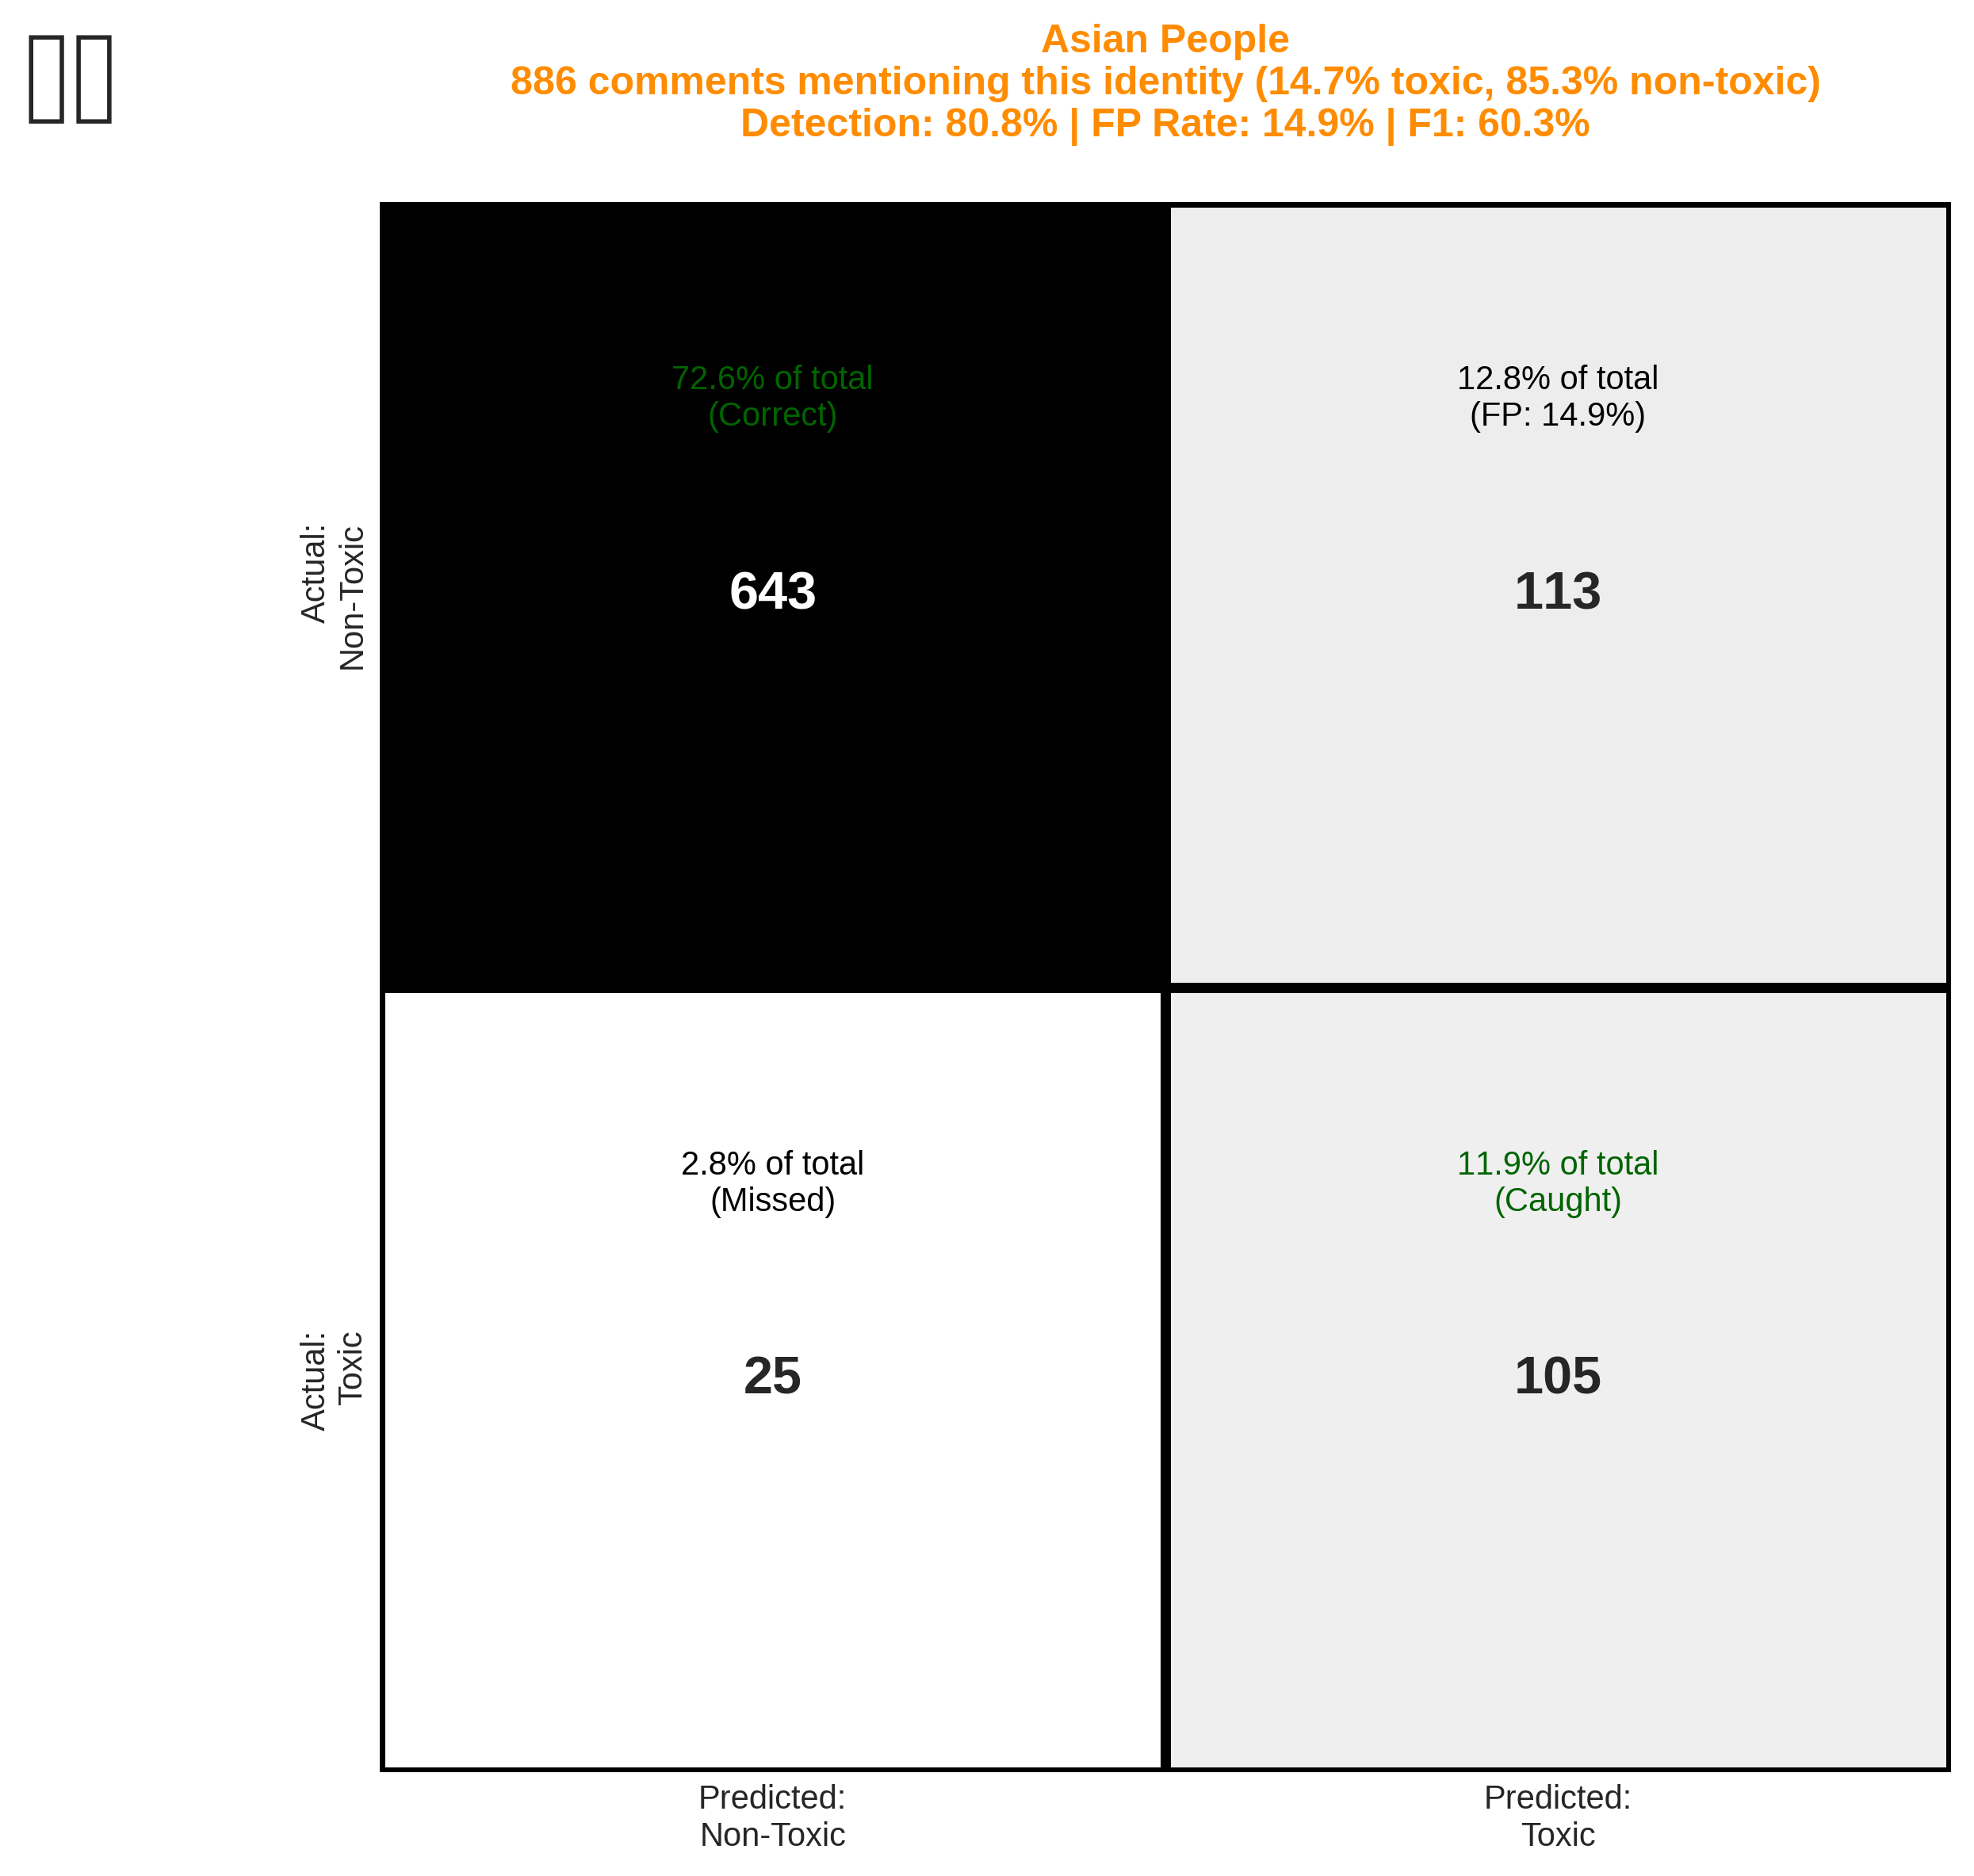


  Black


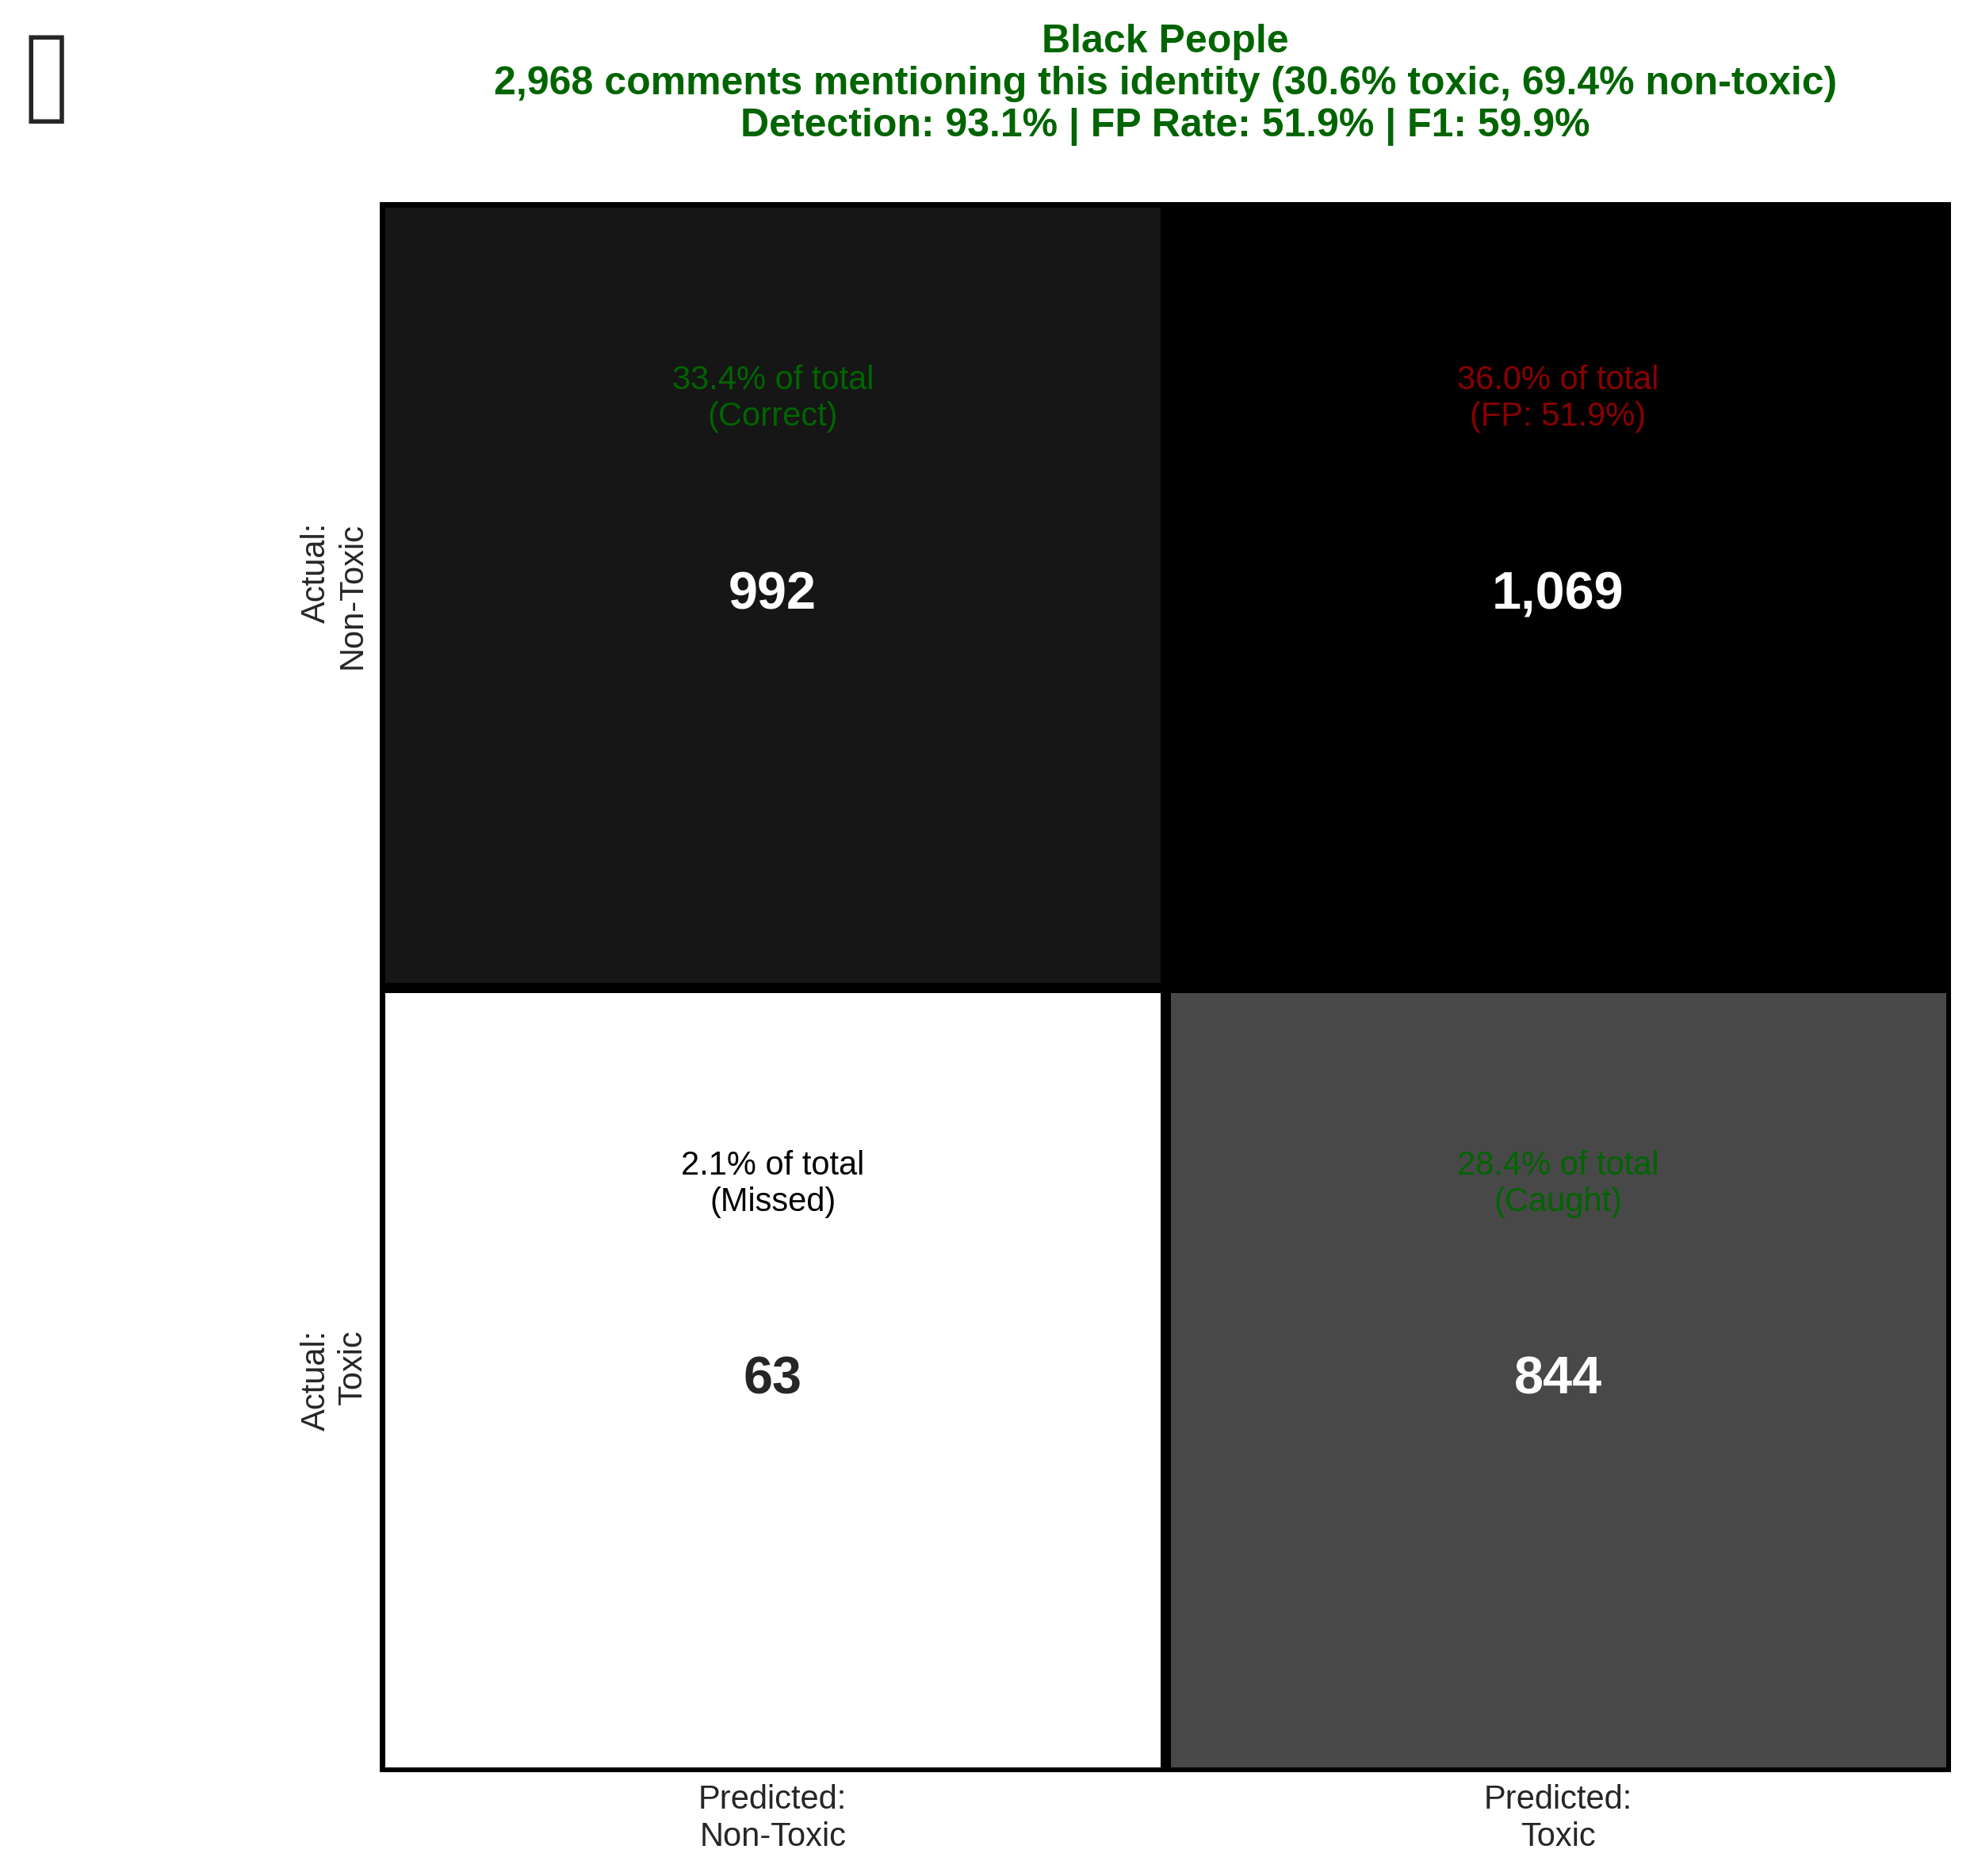


  Christian


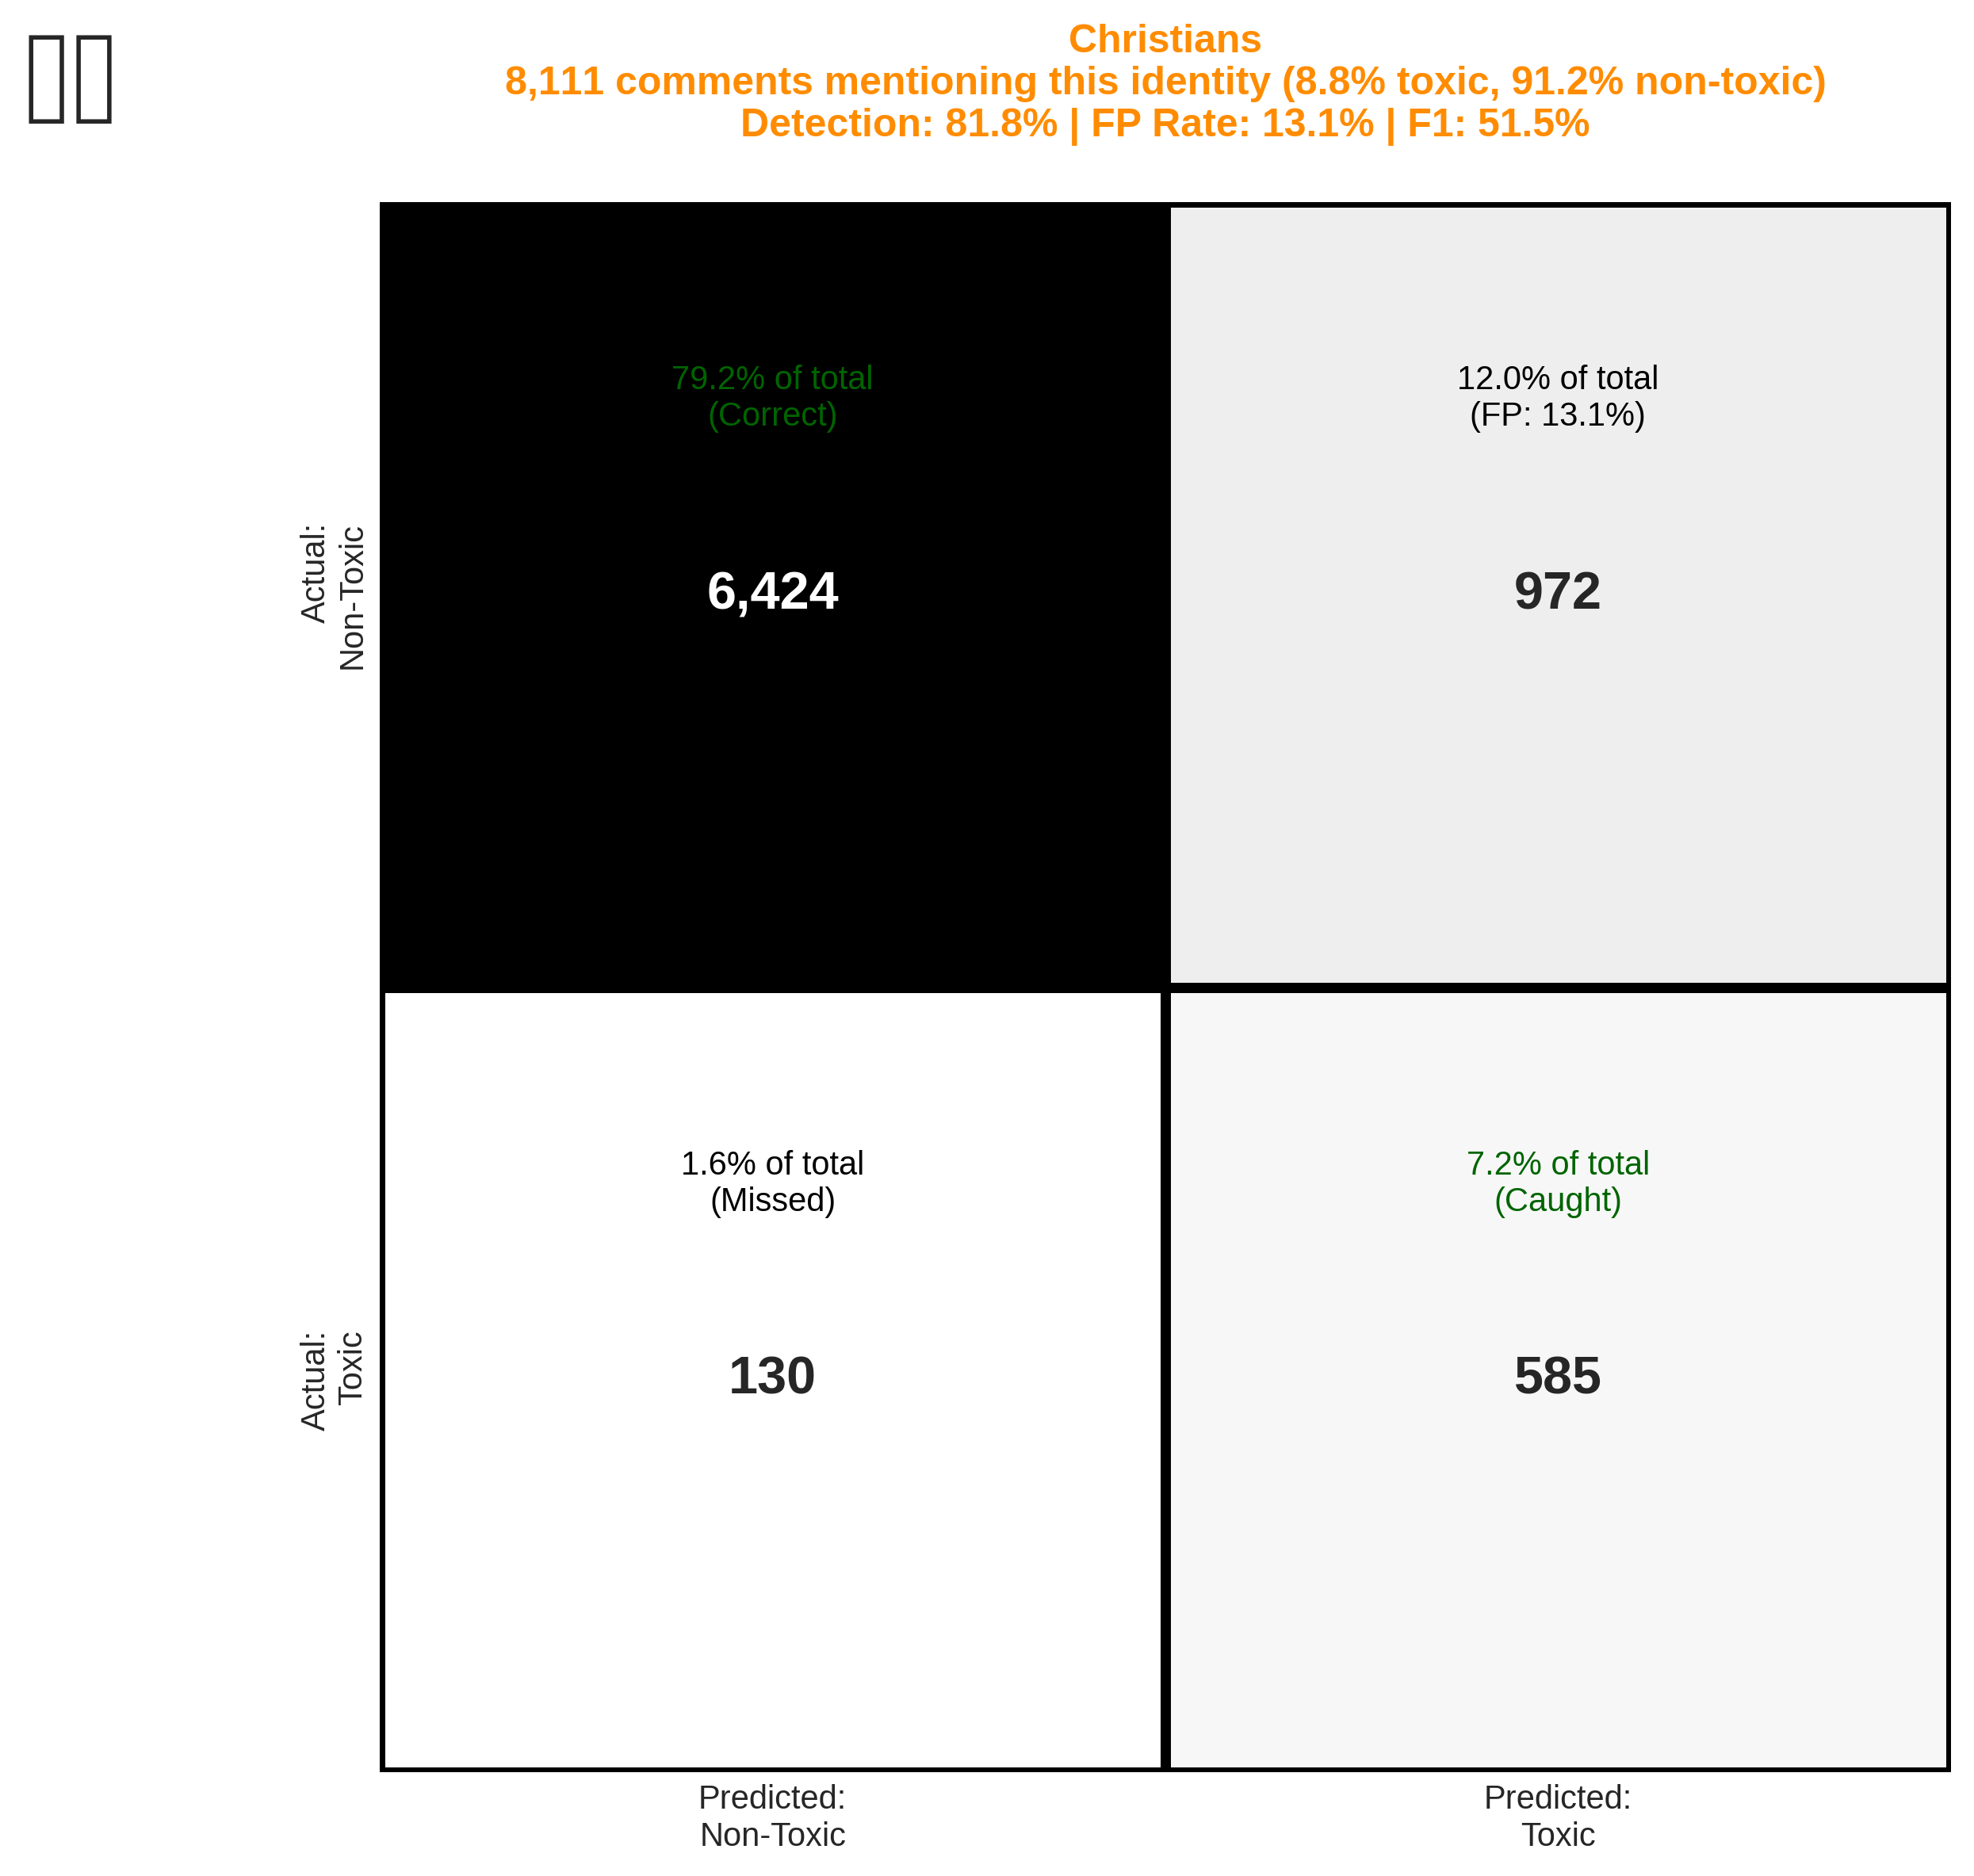


  Female


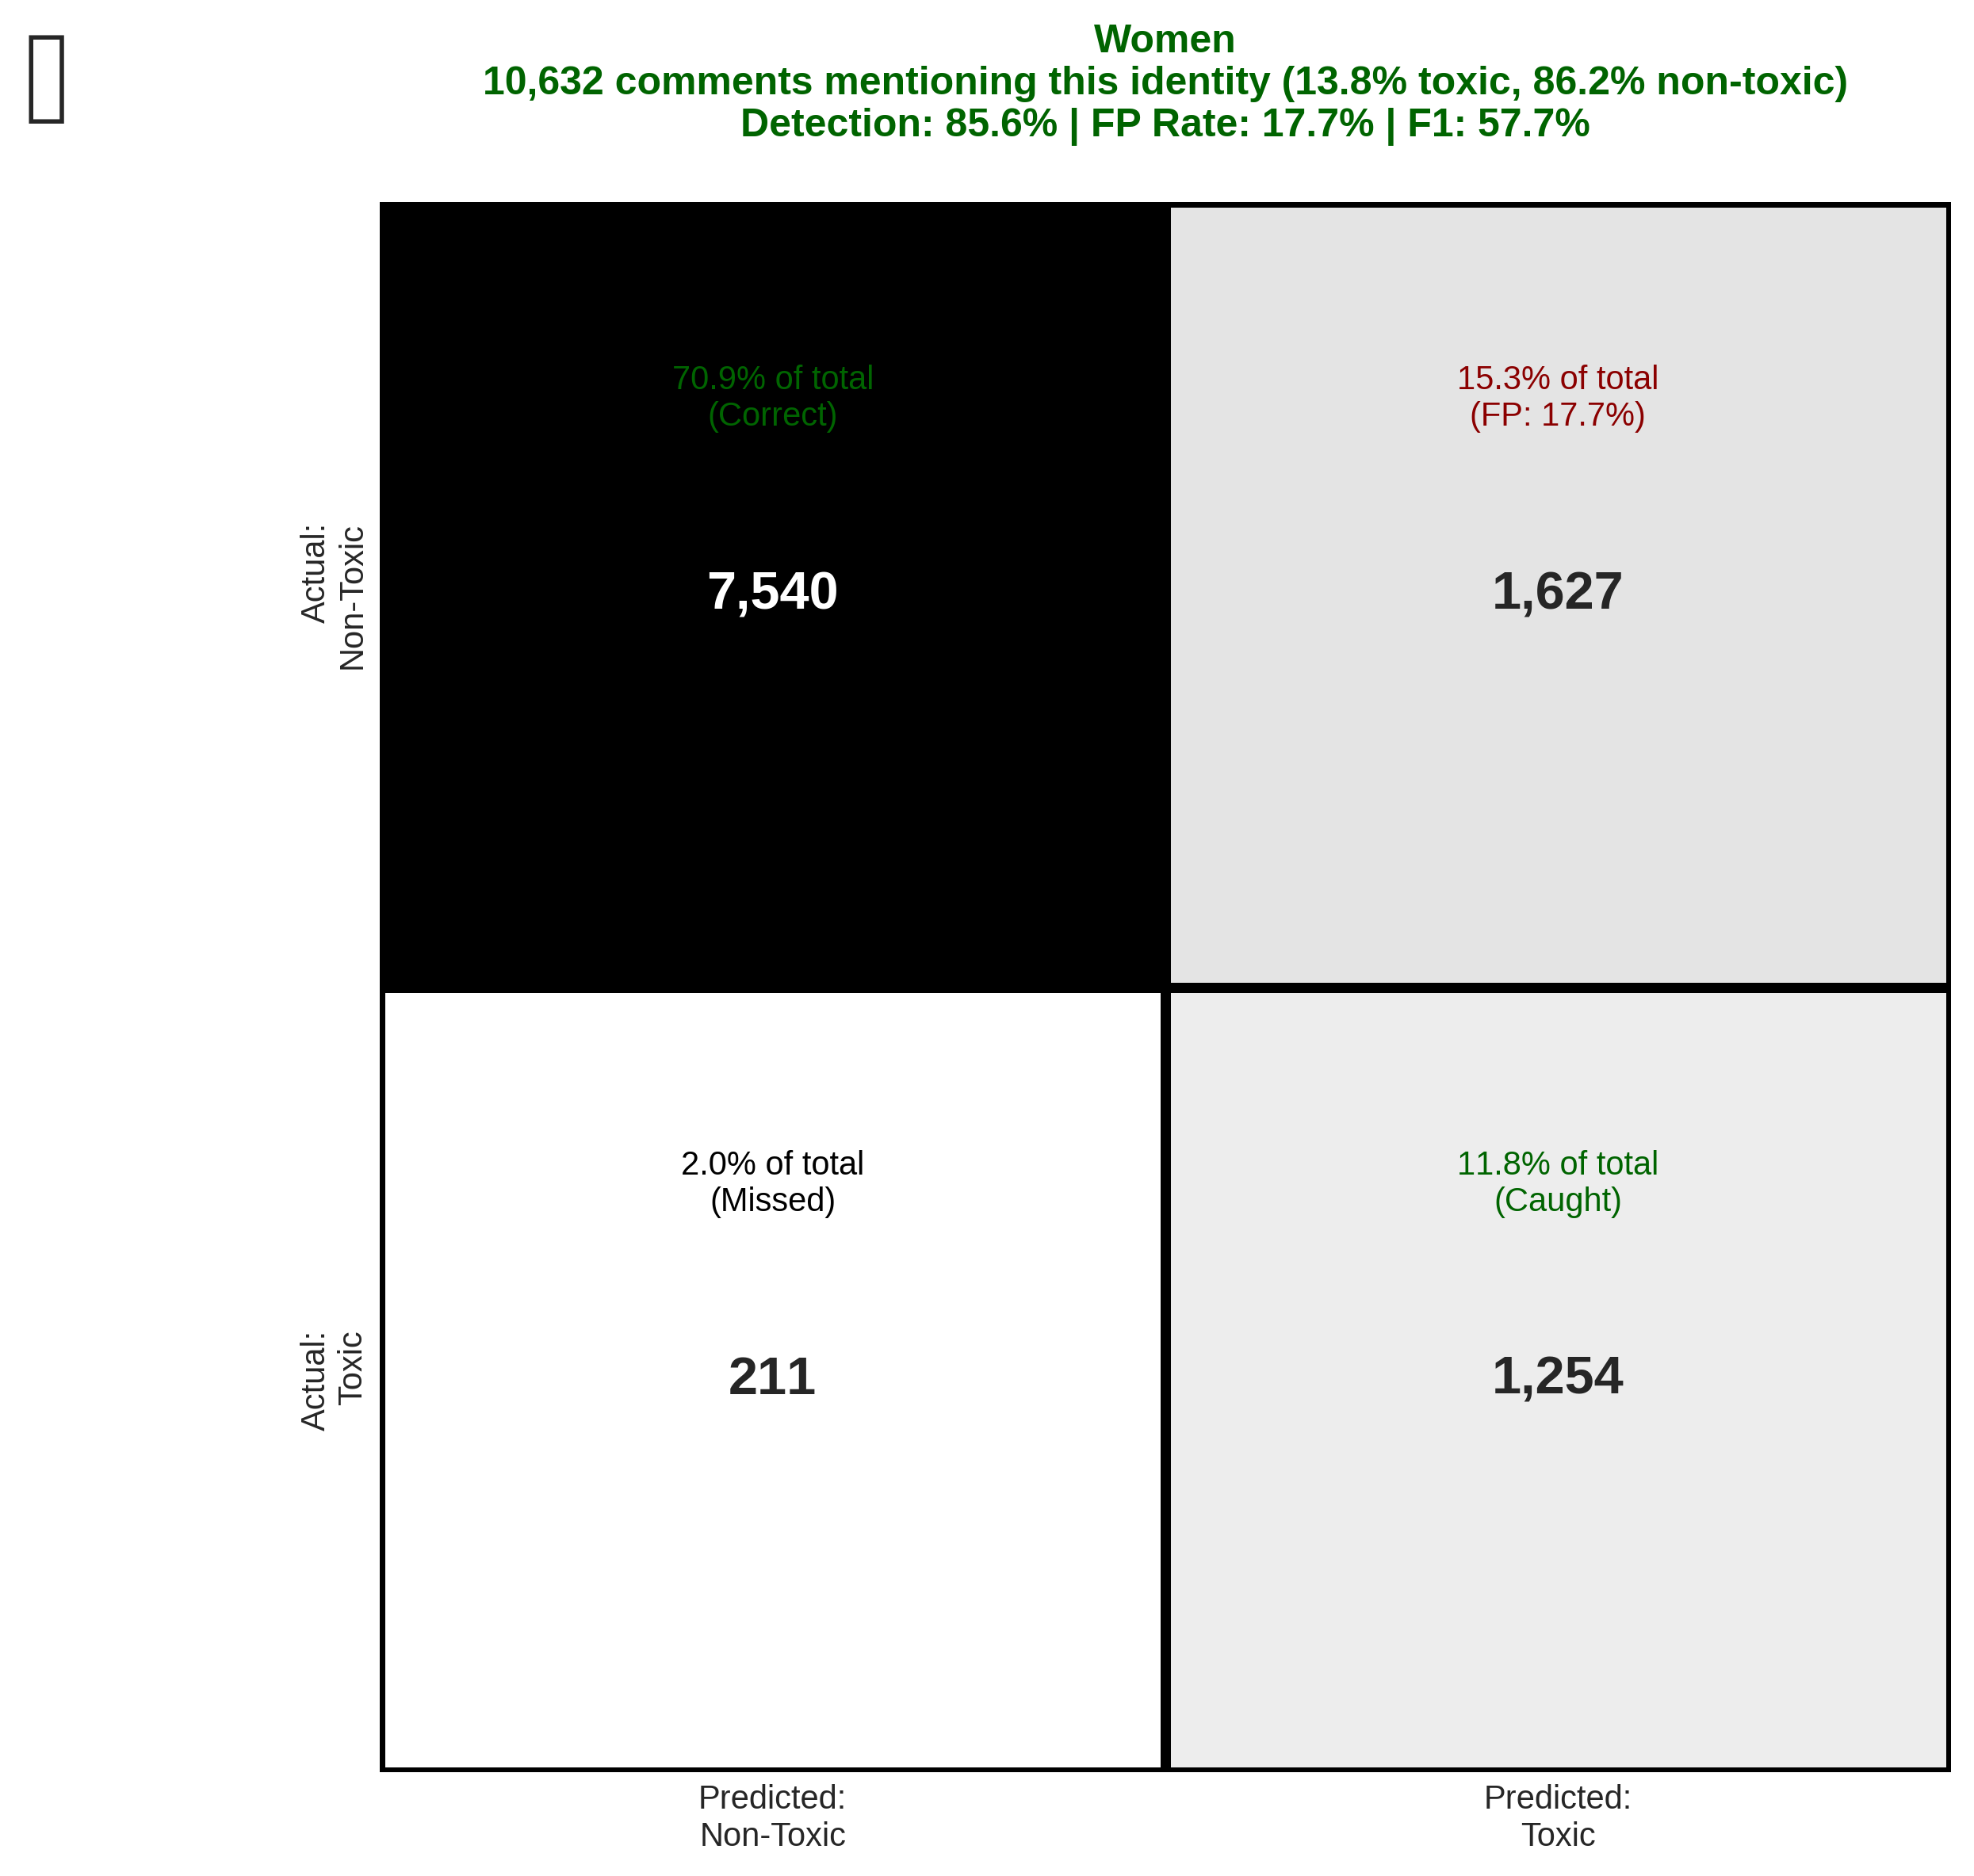


  Homosexual Gay Or Lesbian


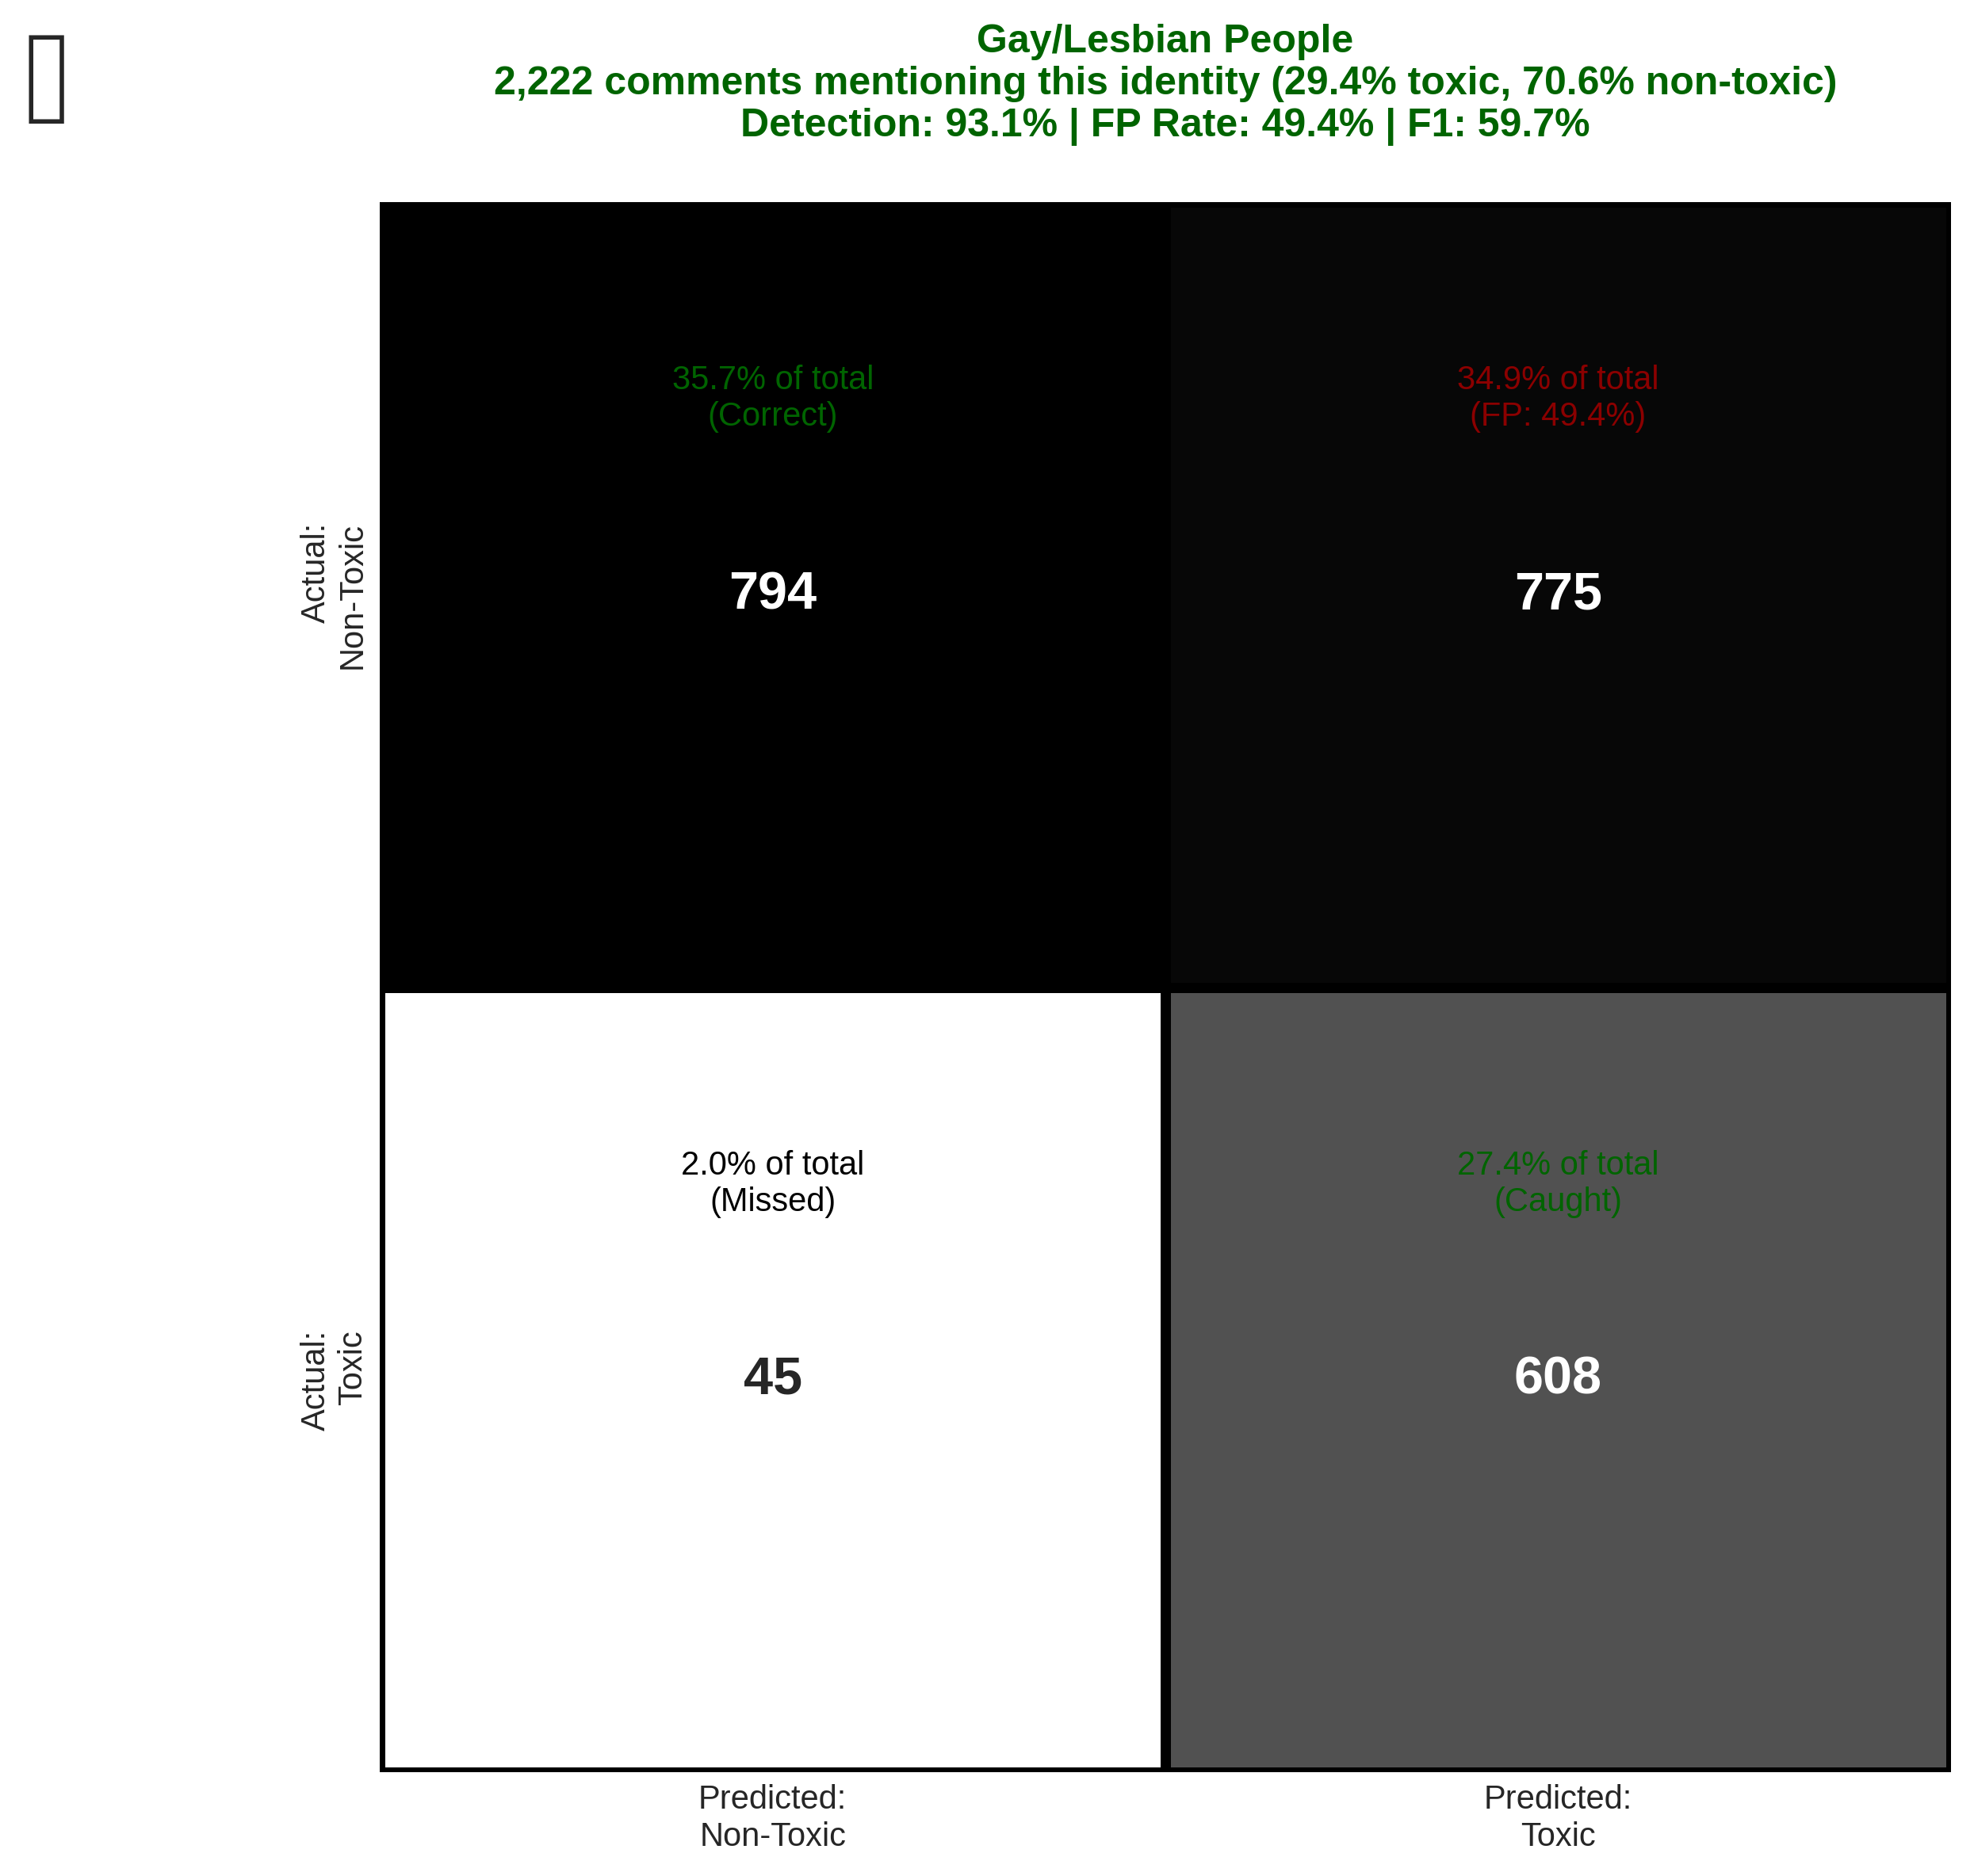


  Intellectual Or Learning Disability


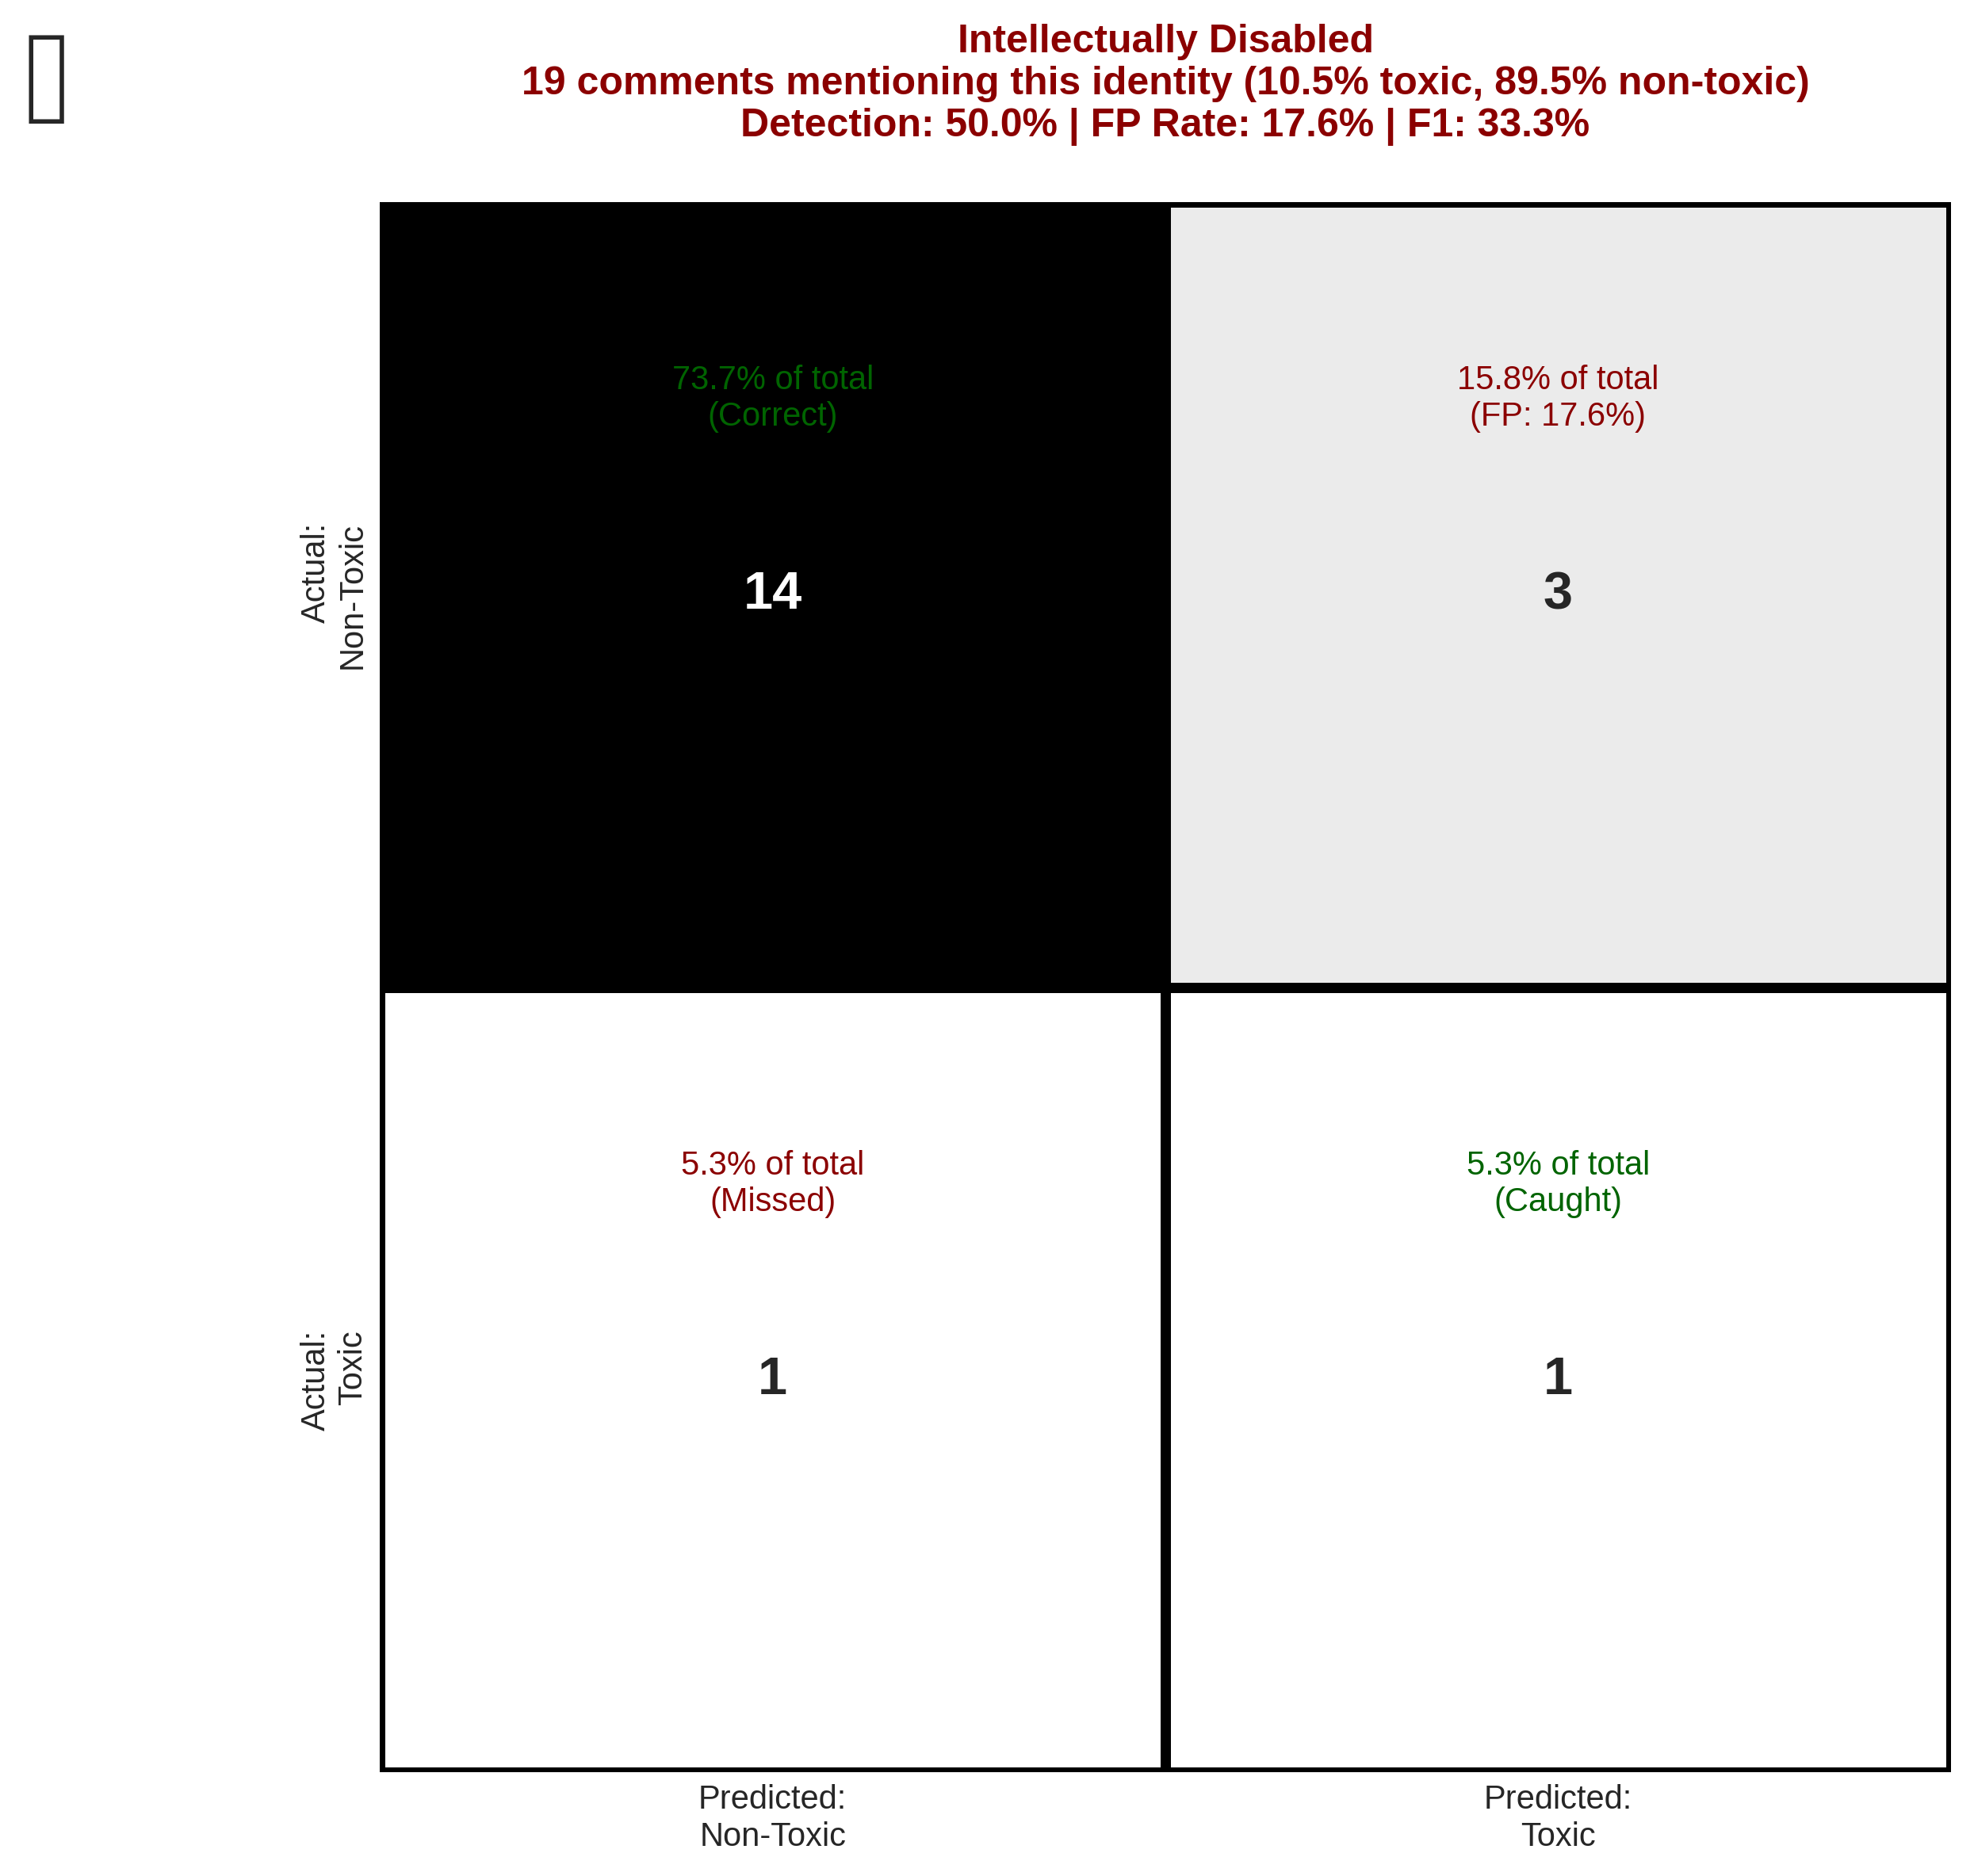


  Jewish


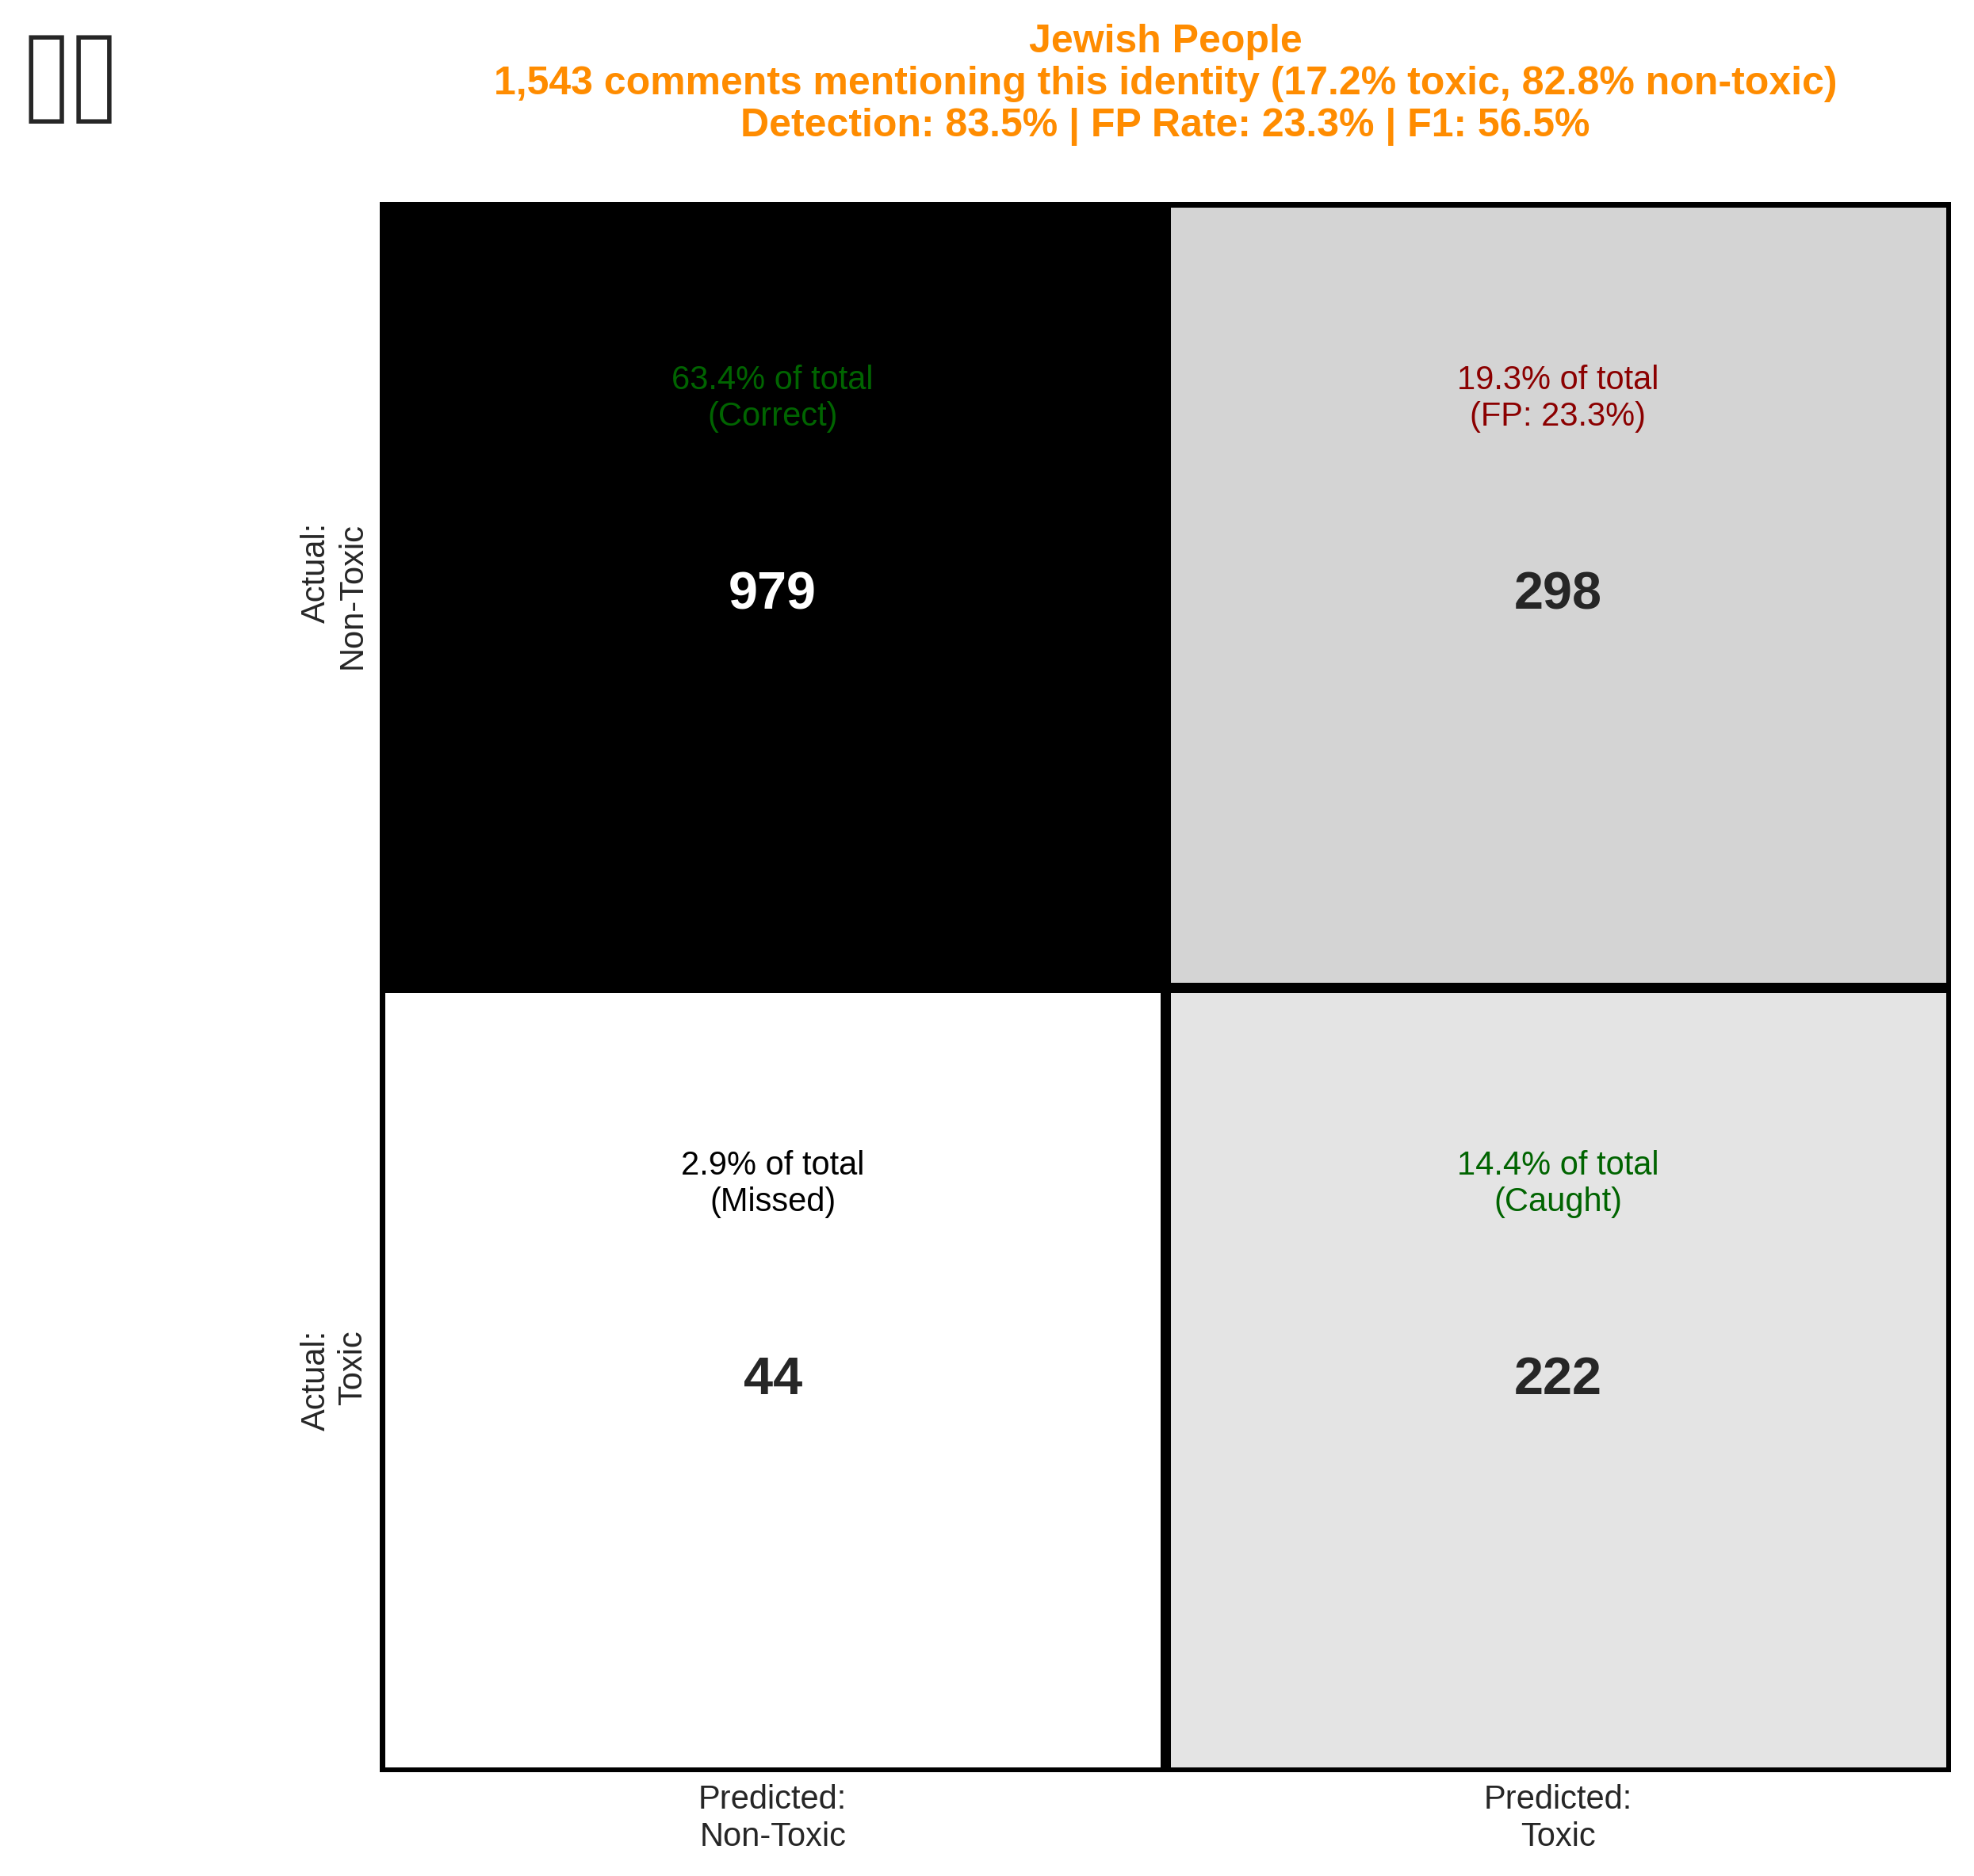


  Latino


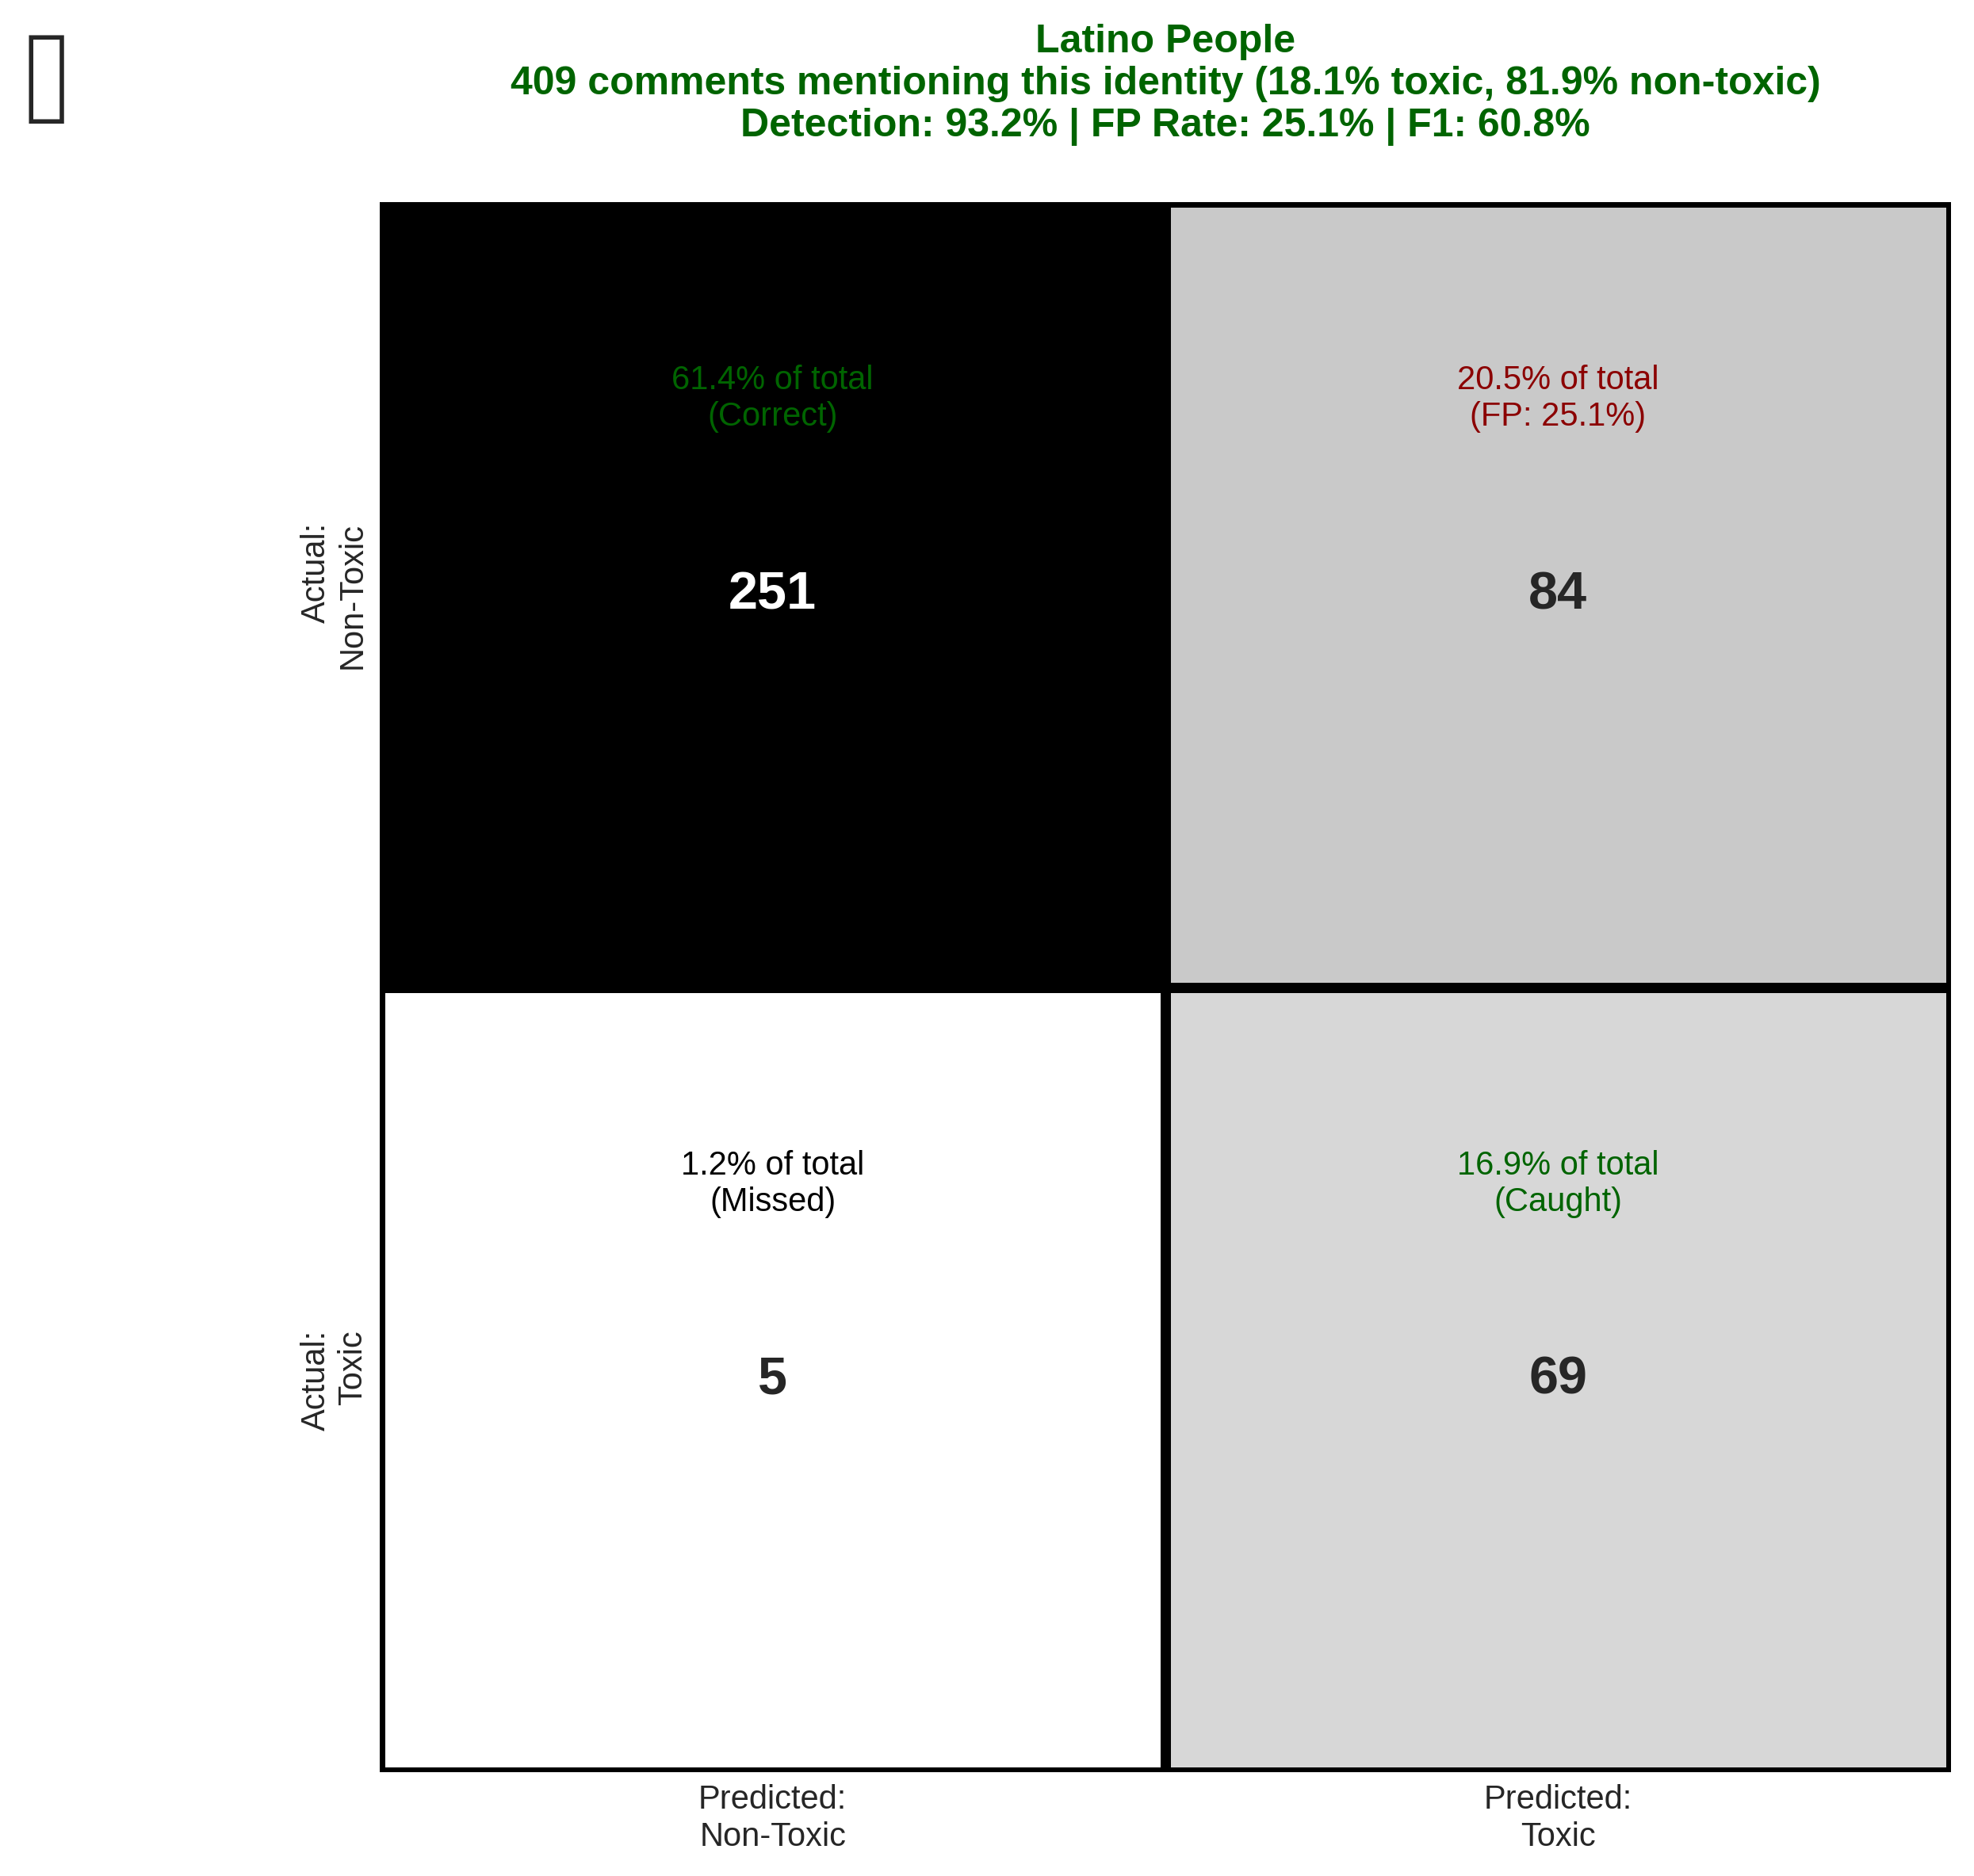


  Male


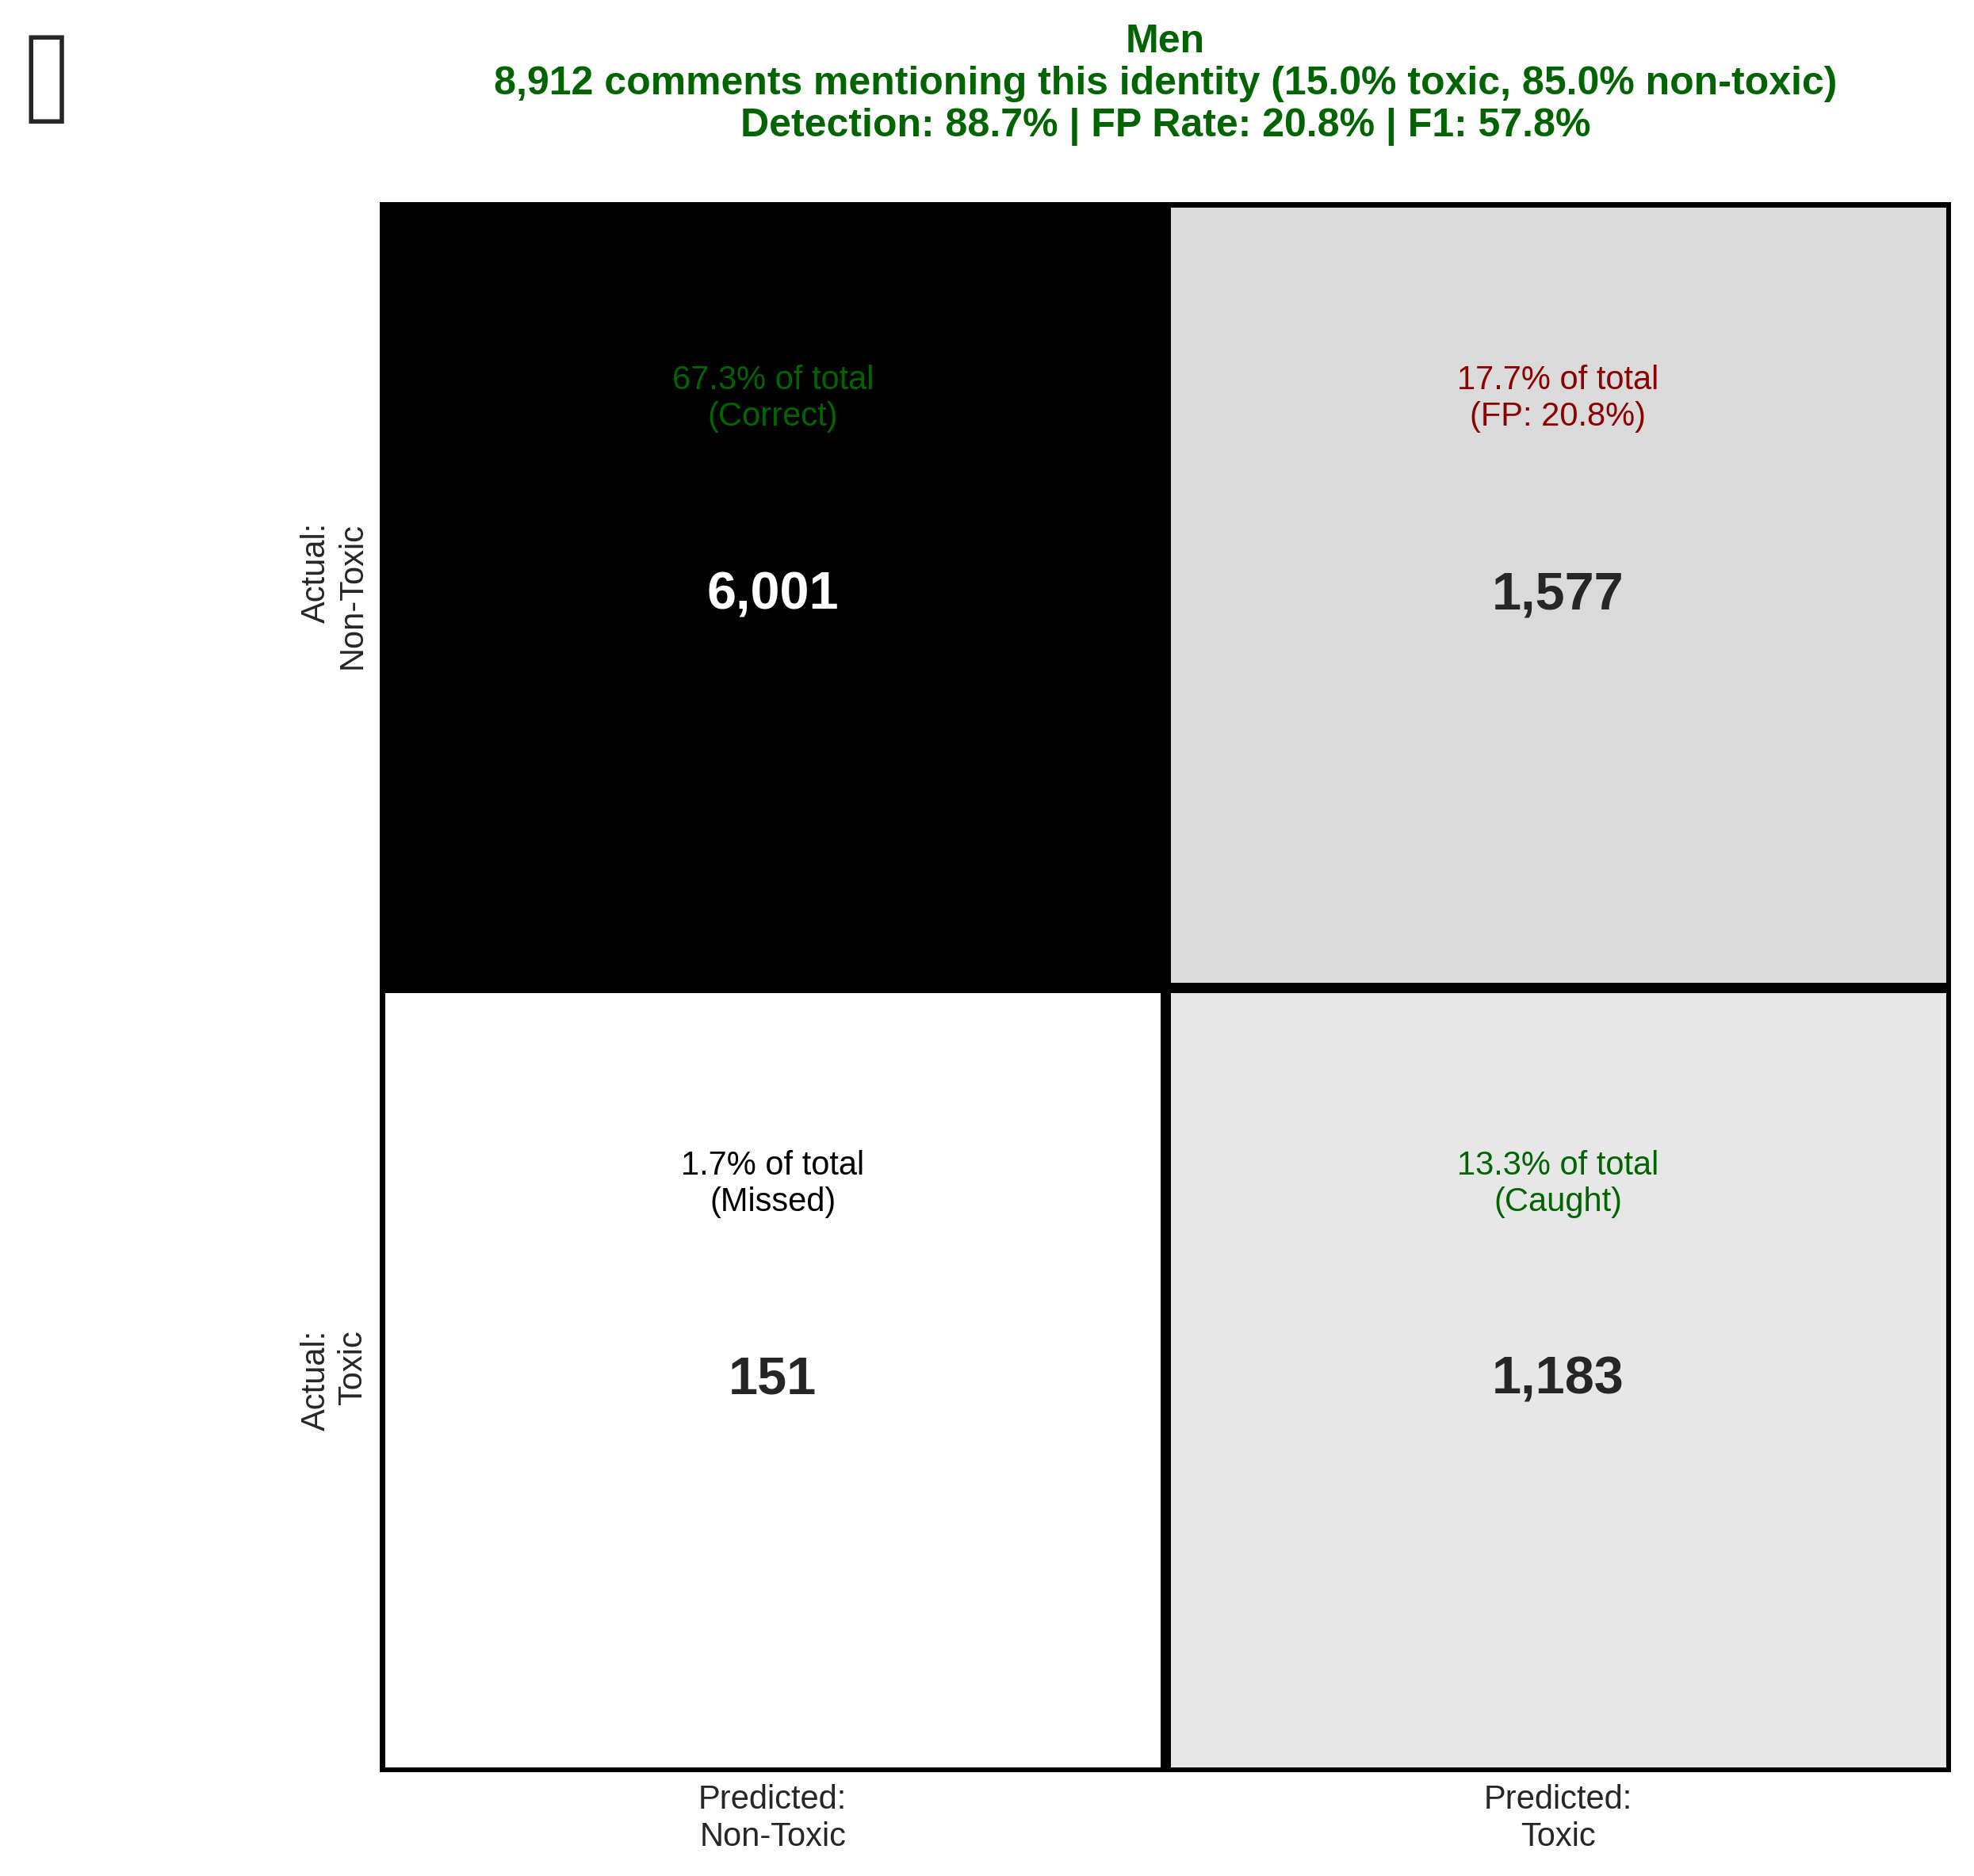


  Muslim


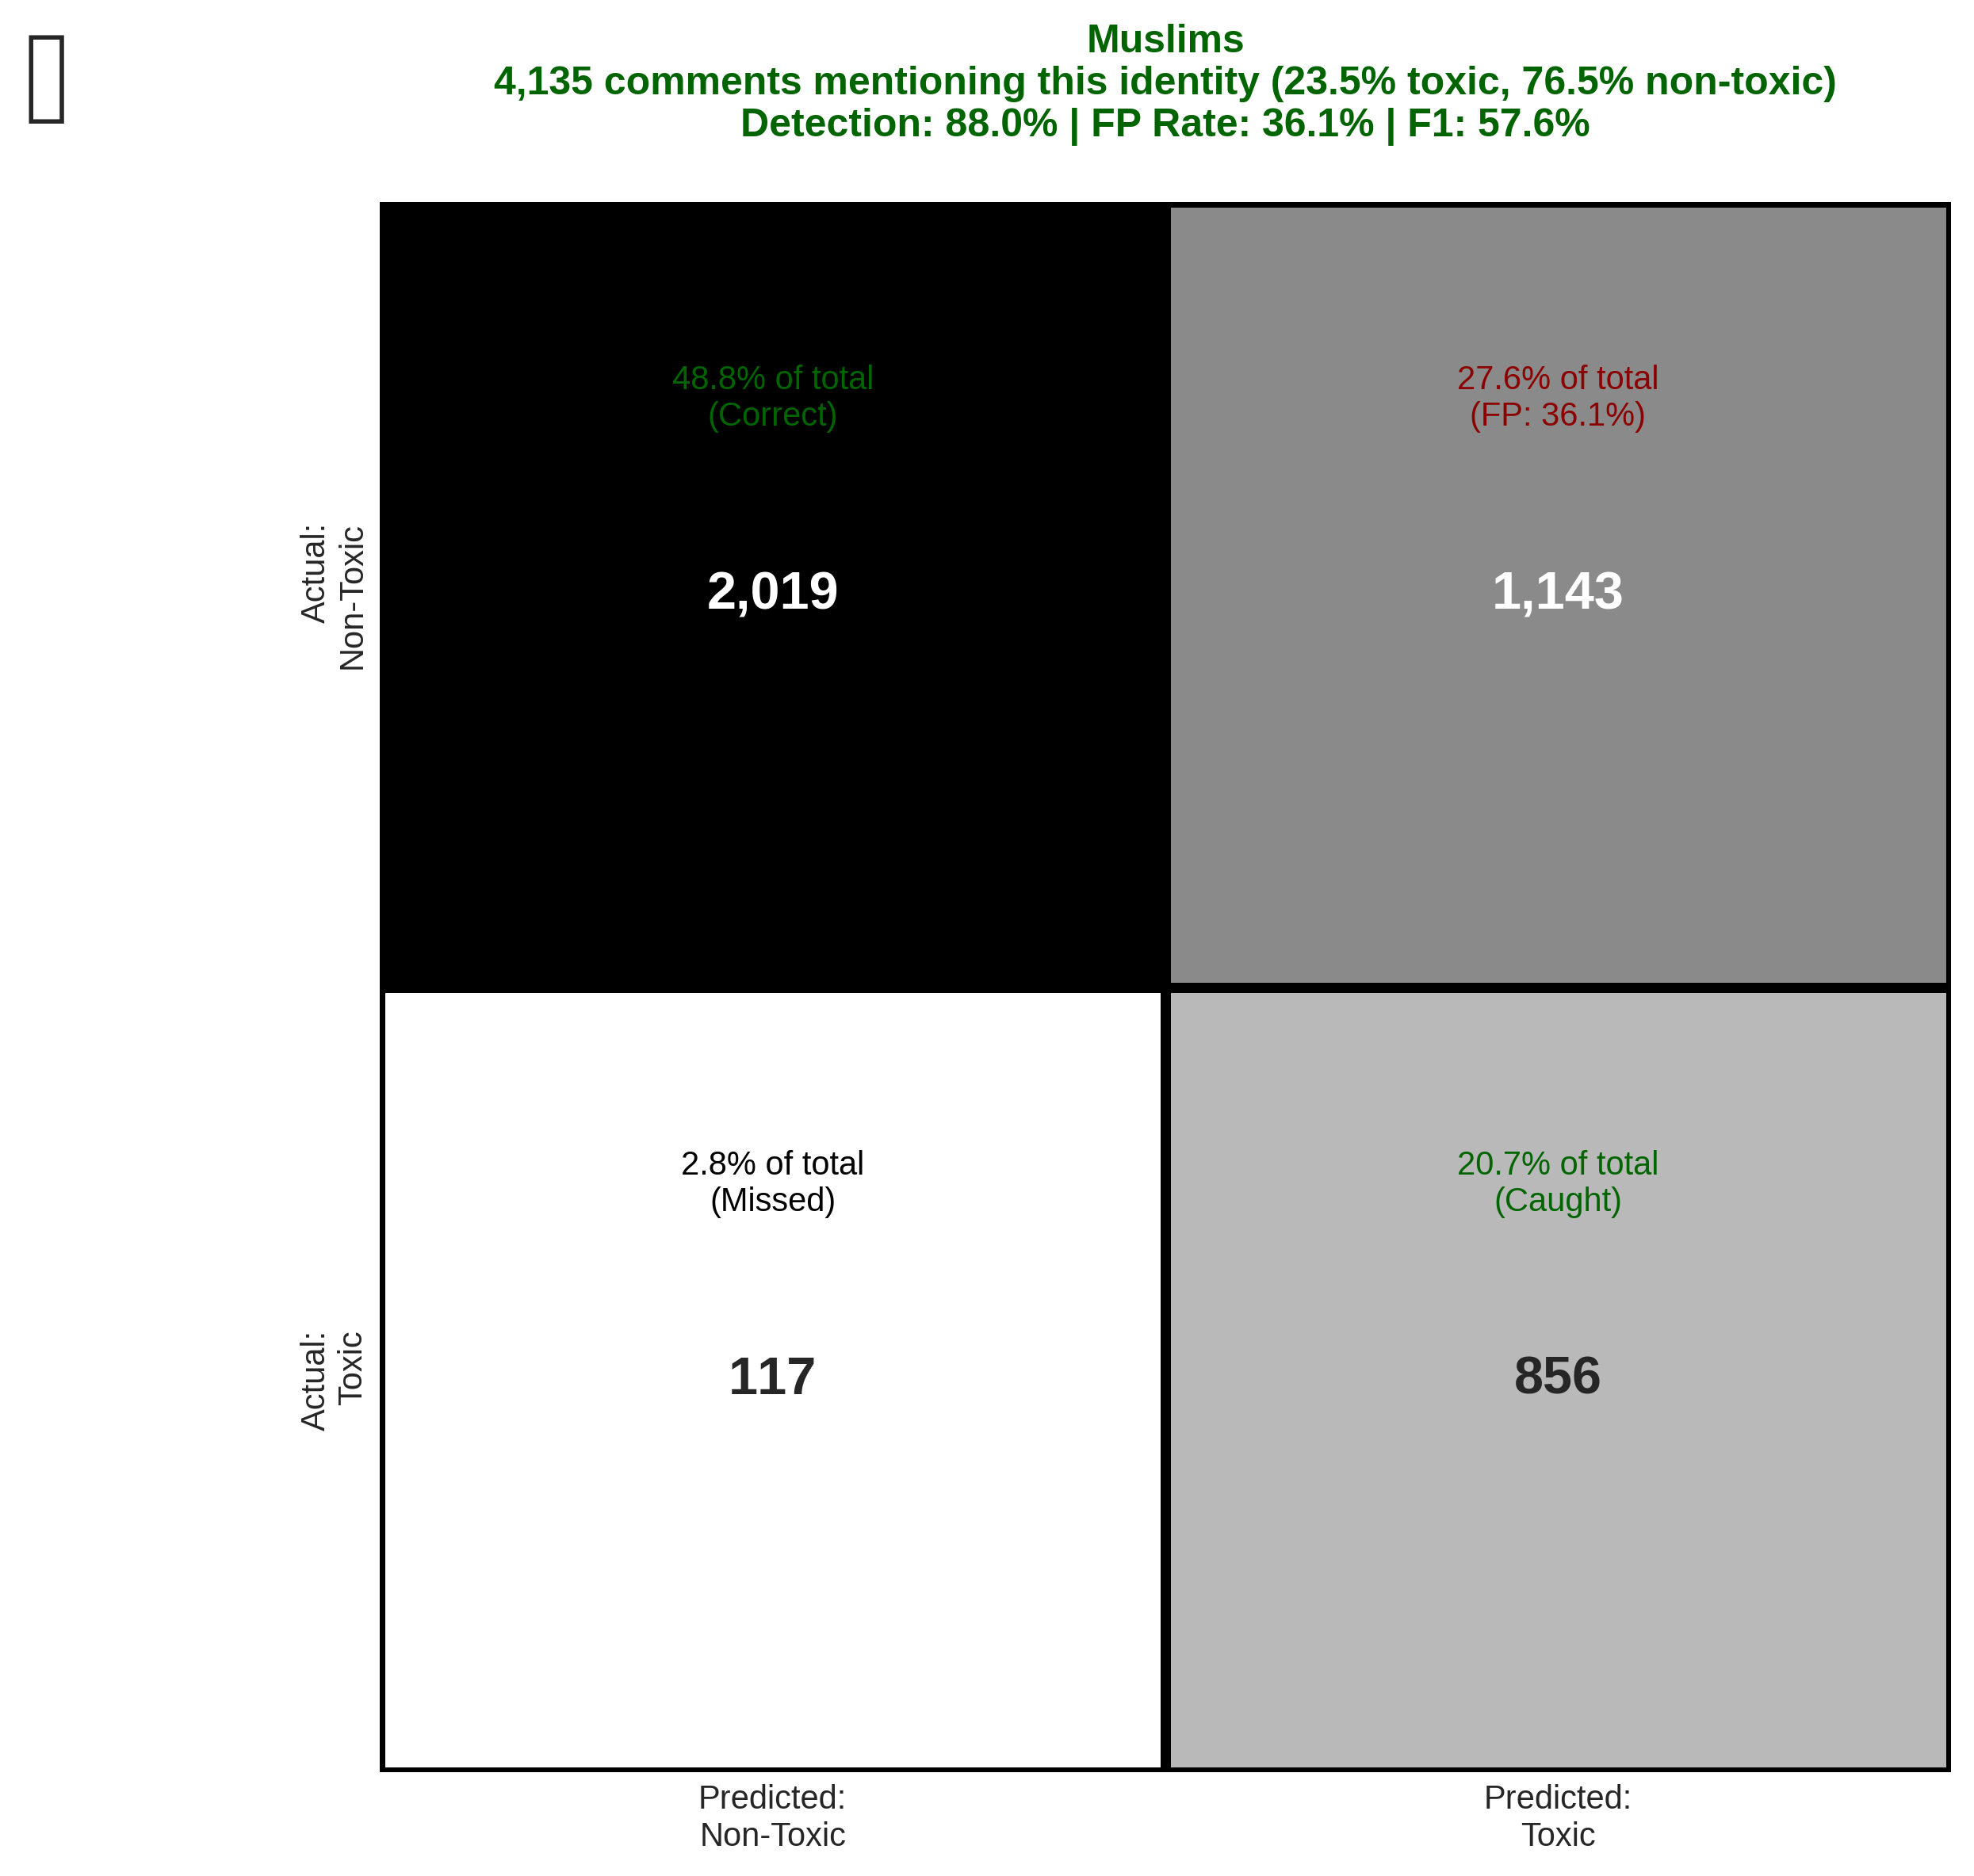


  Physical Disability


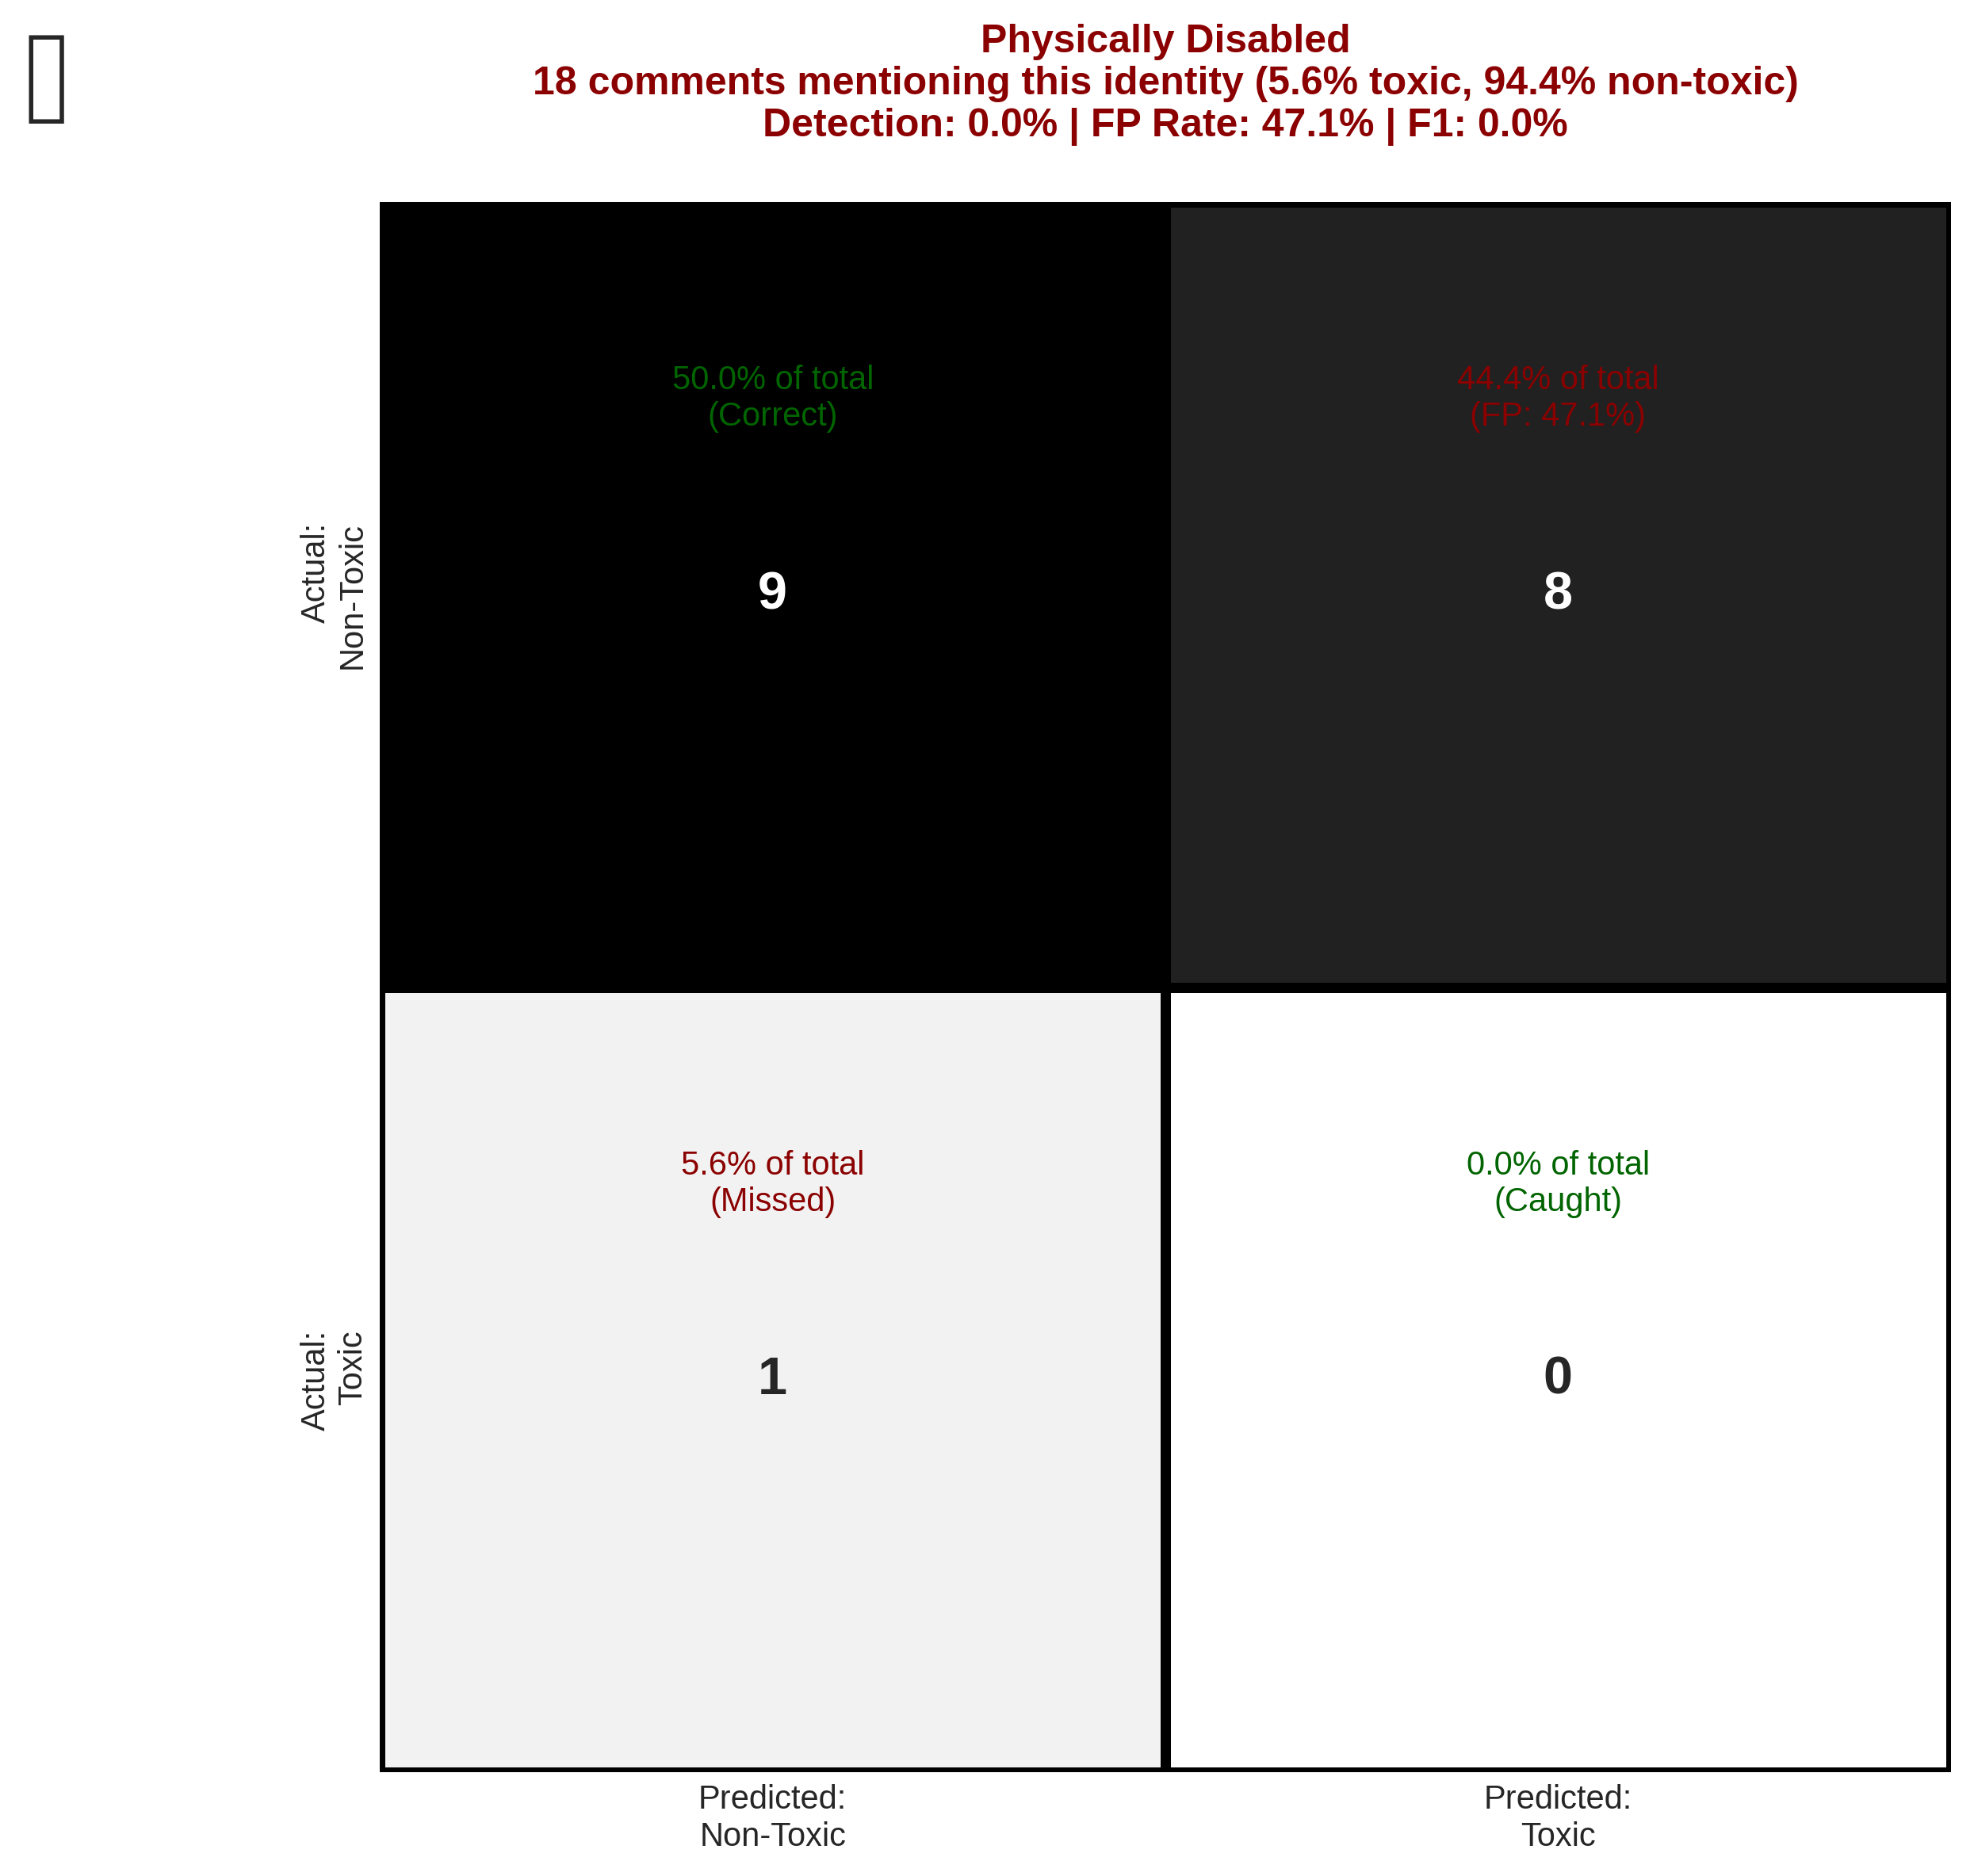


  Transgender


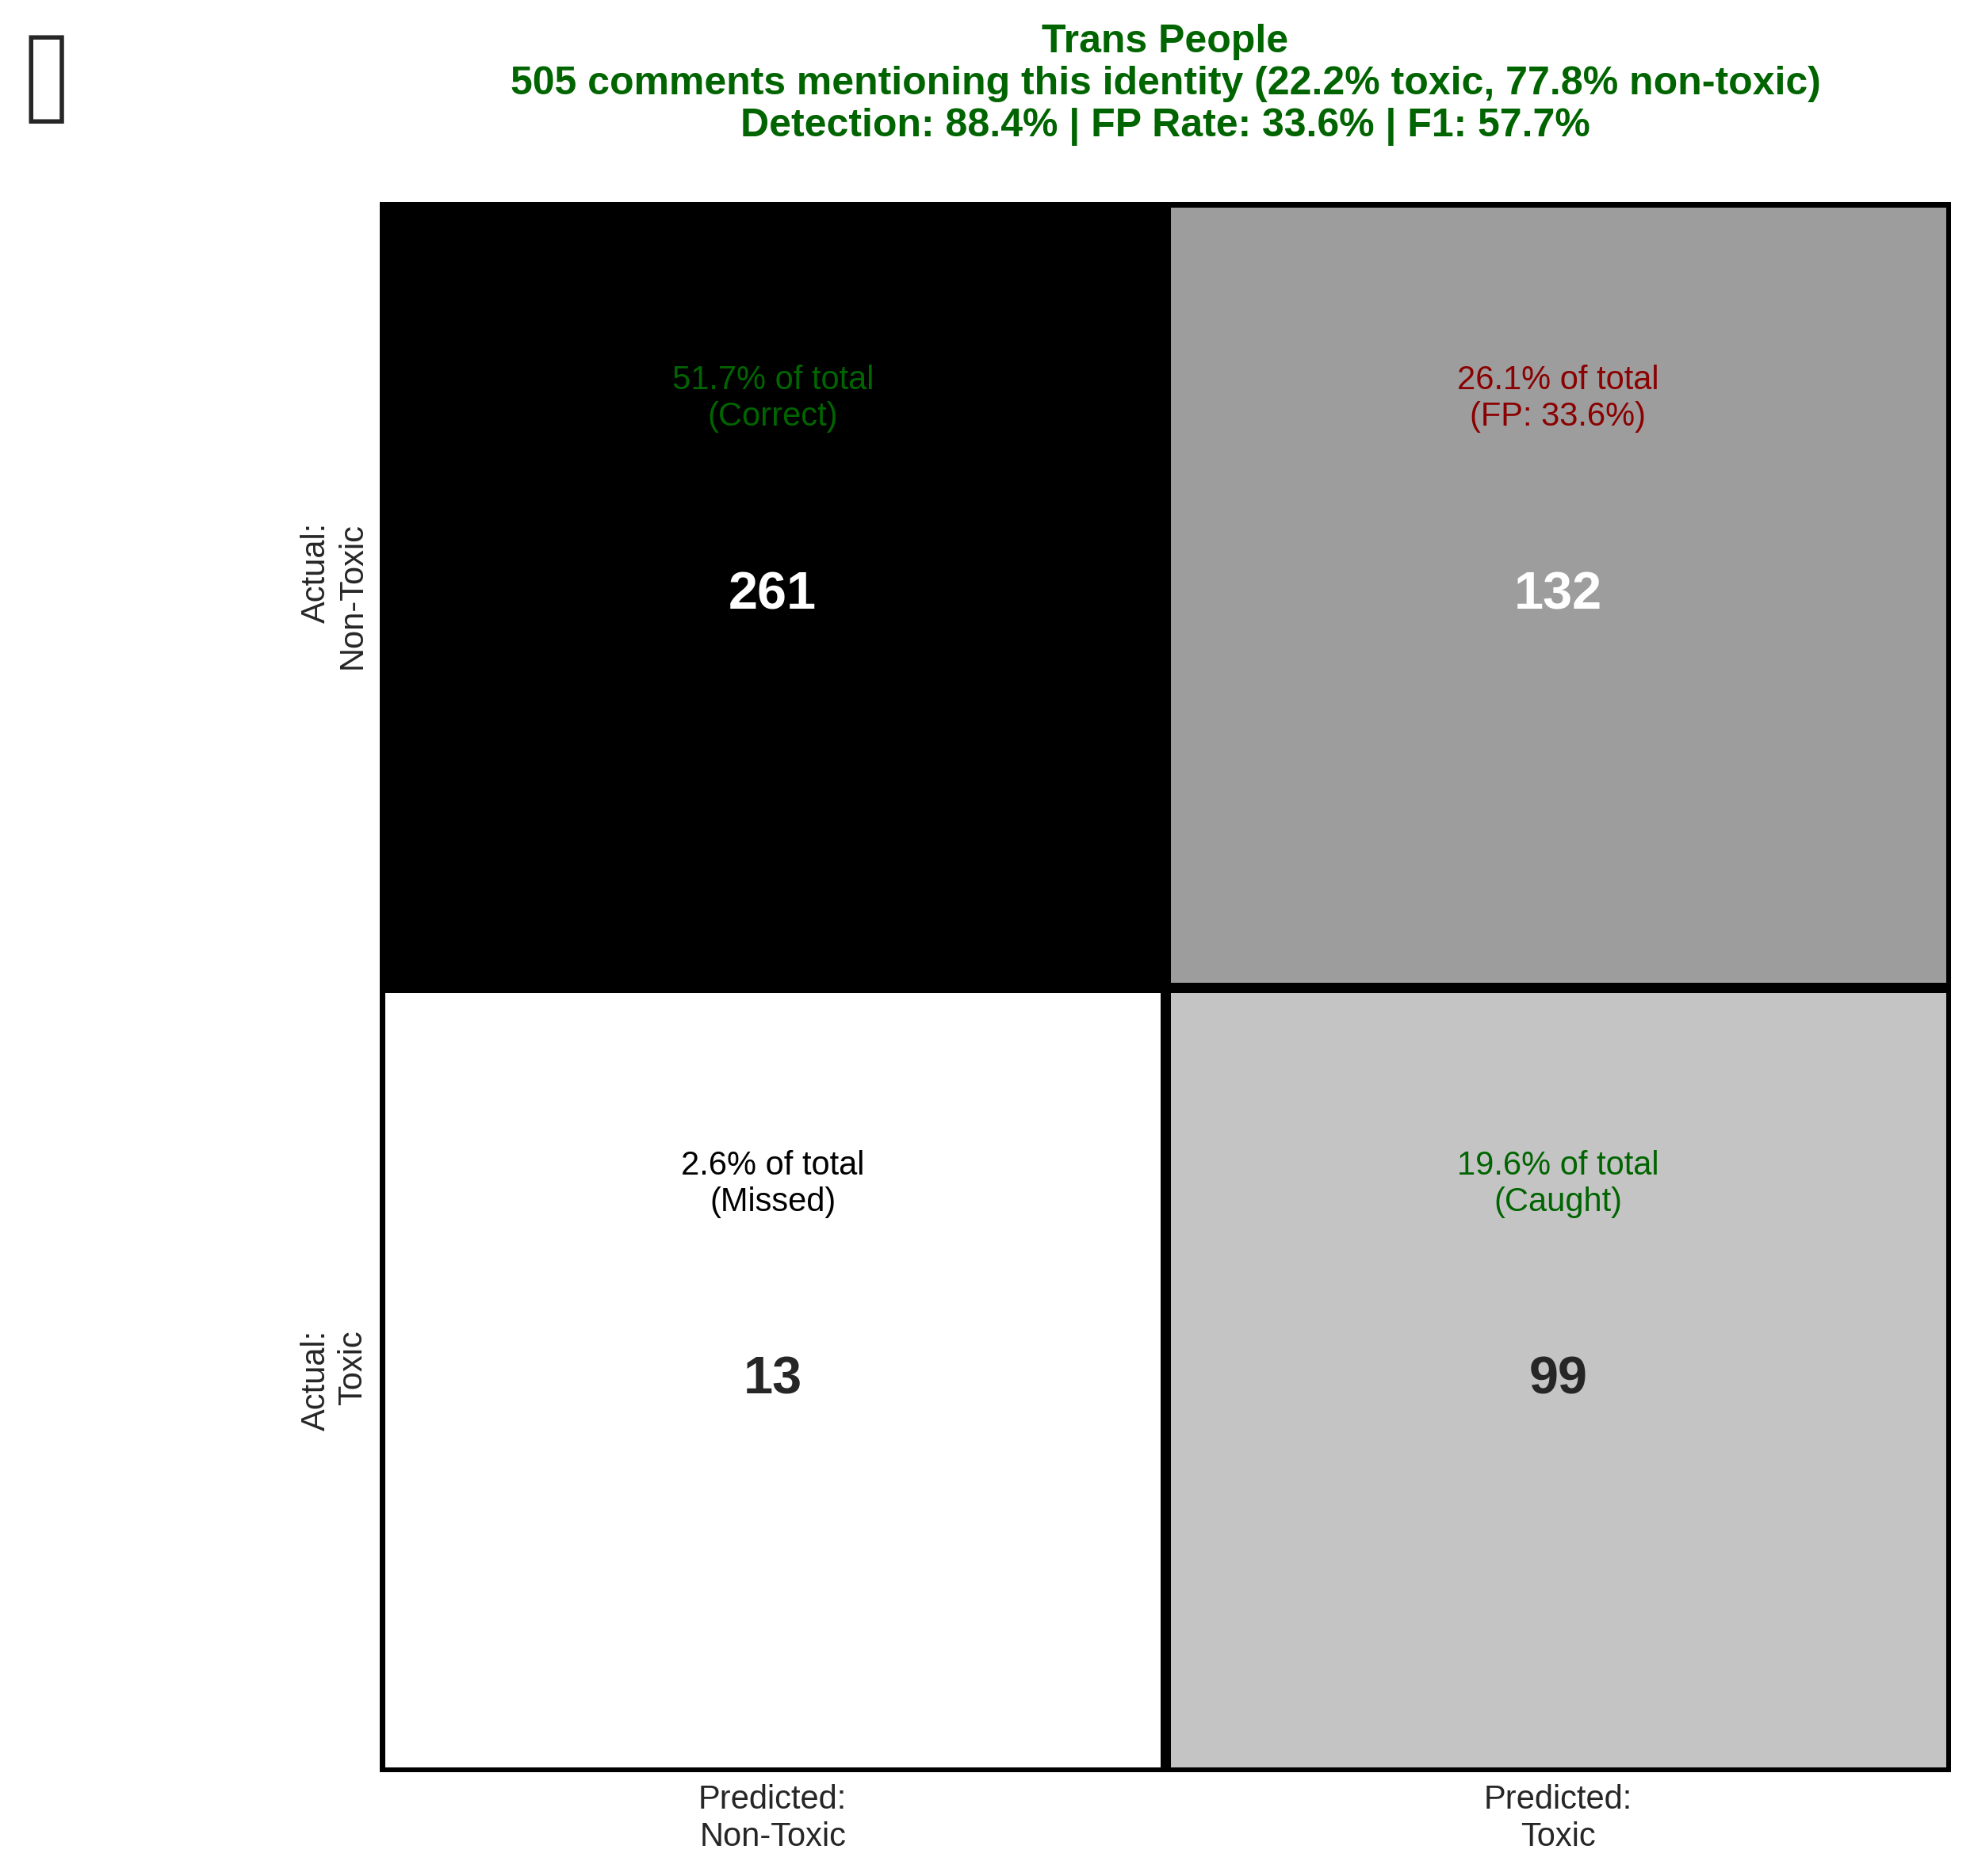


  White


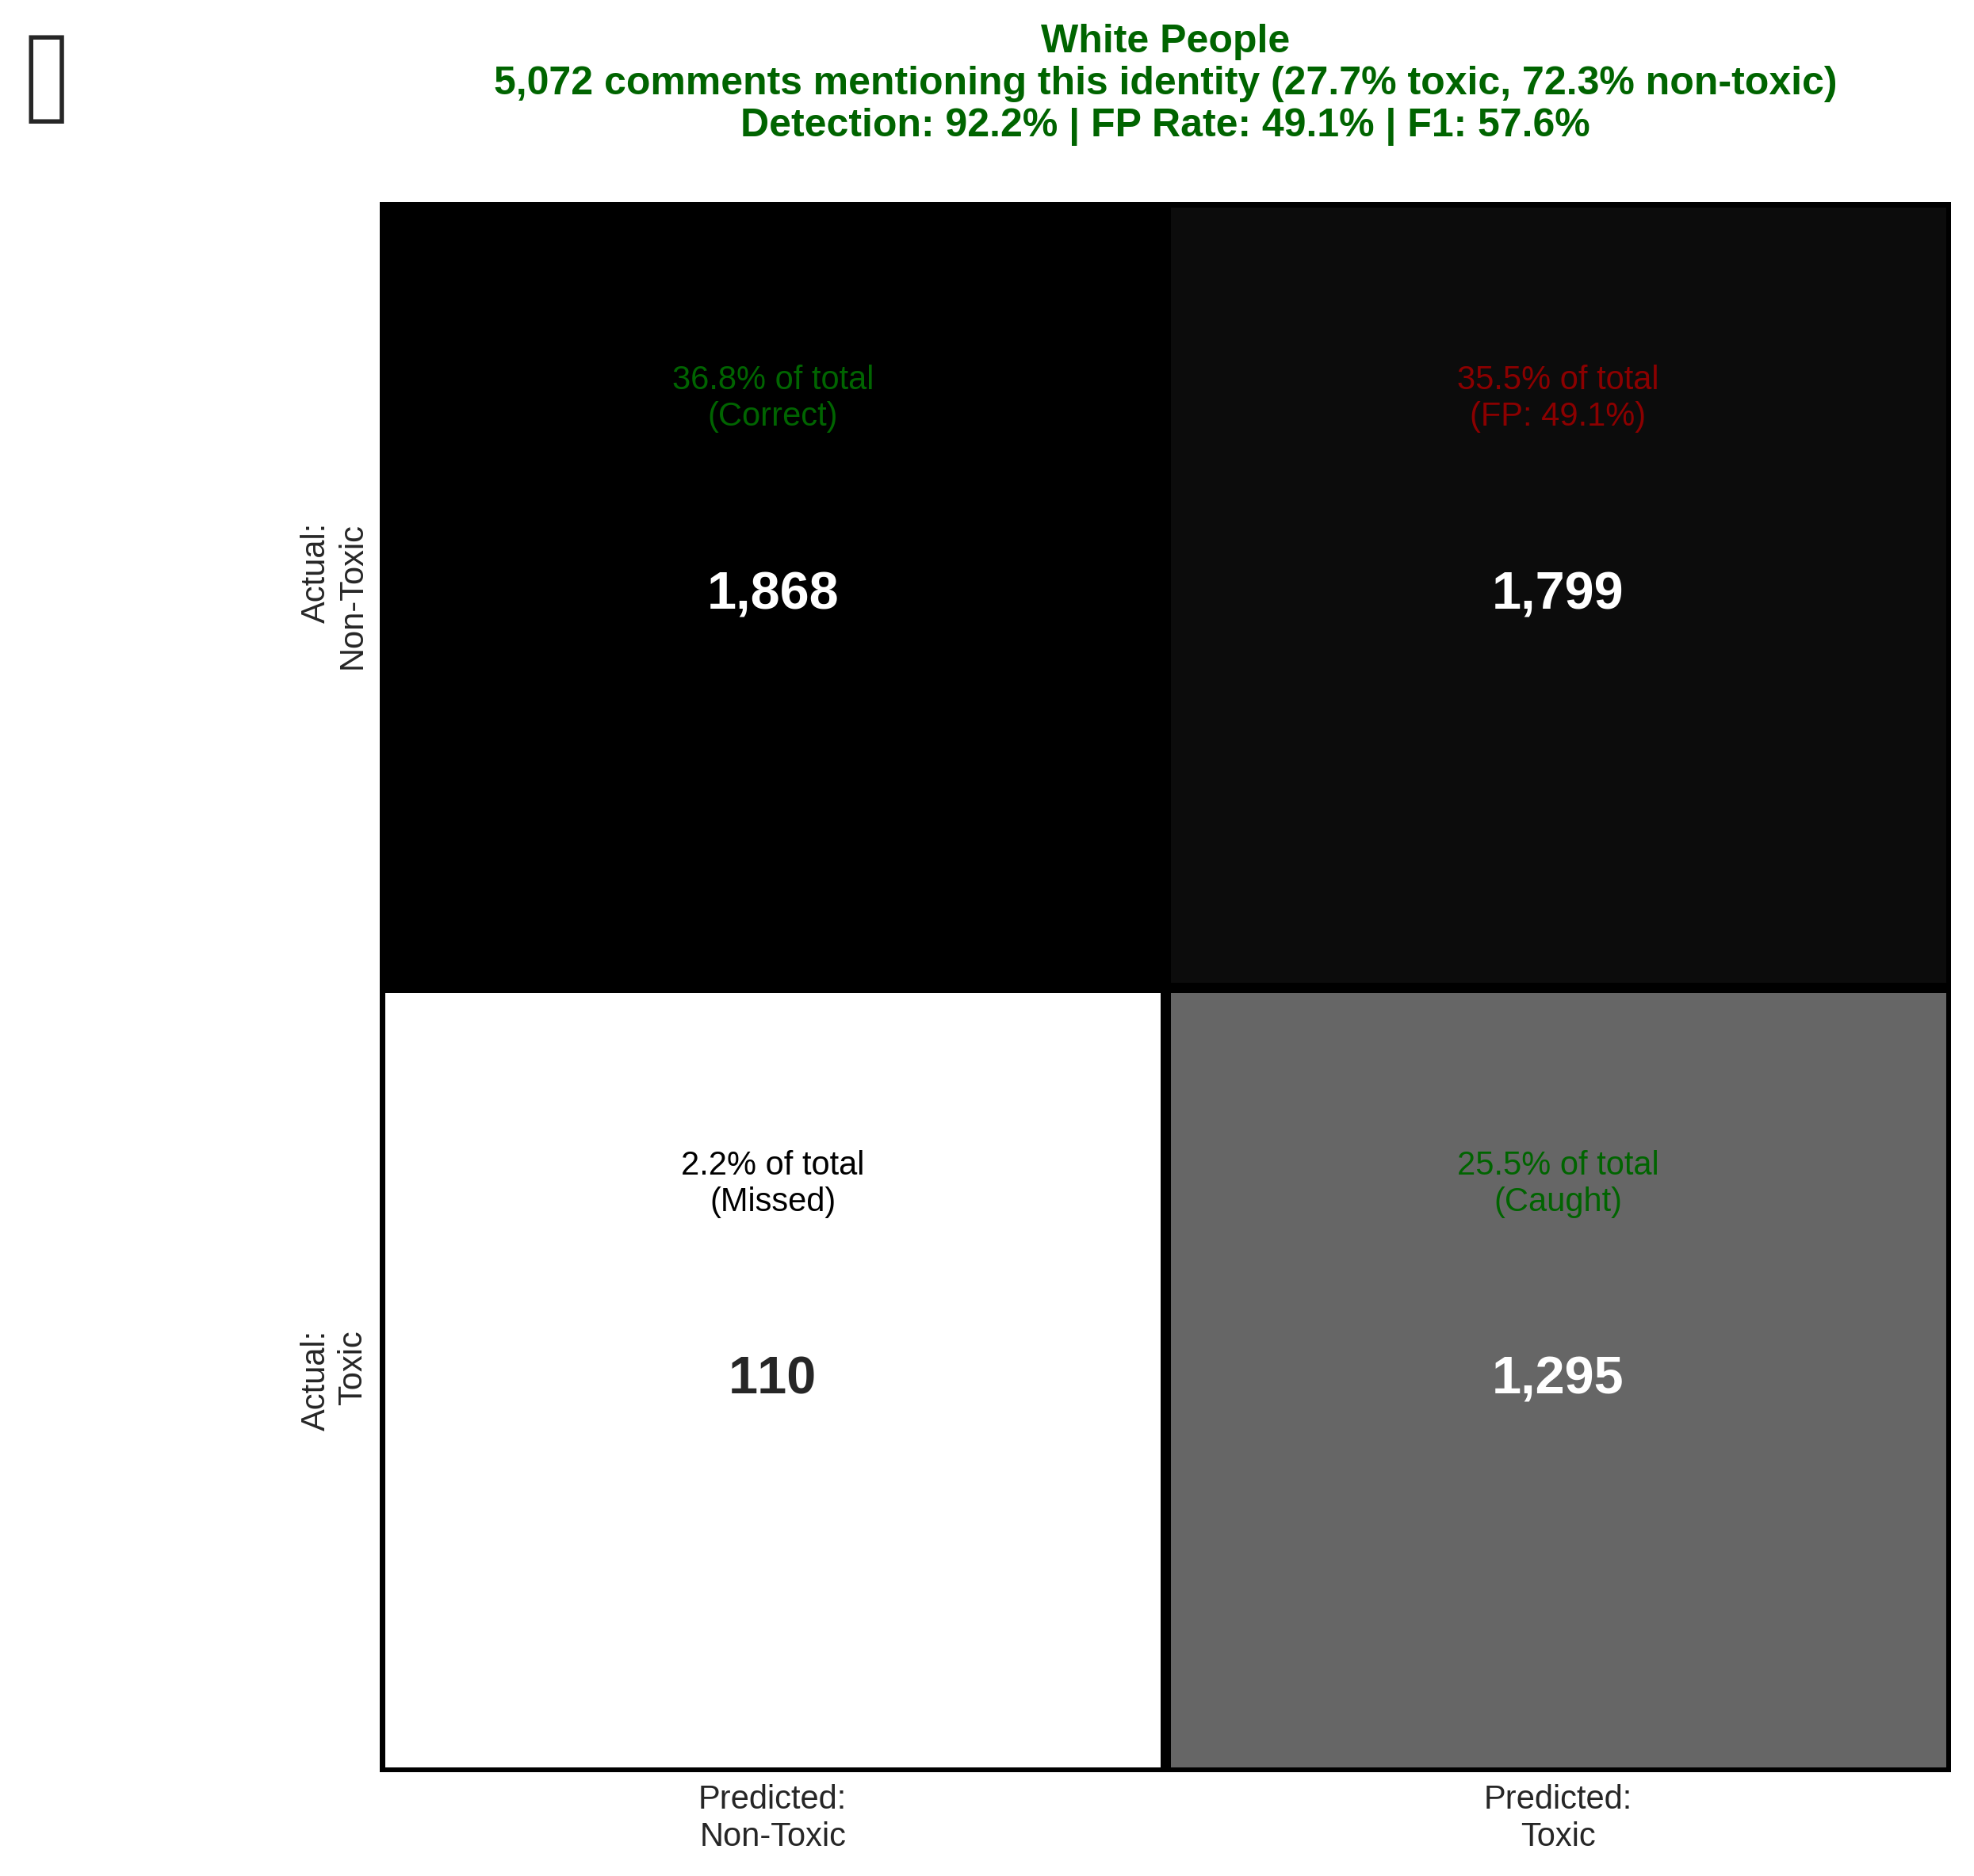


COMPARISON CHARTS

jigsaw_fairness_detection_rates.png:


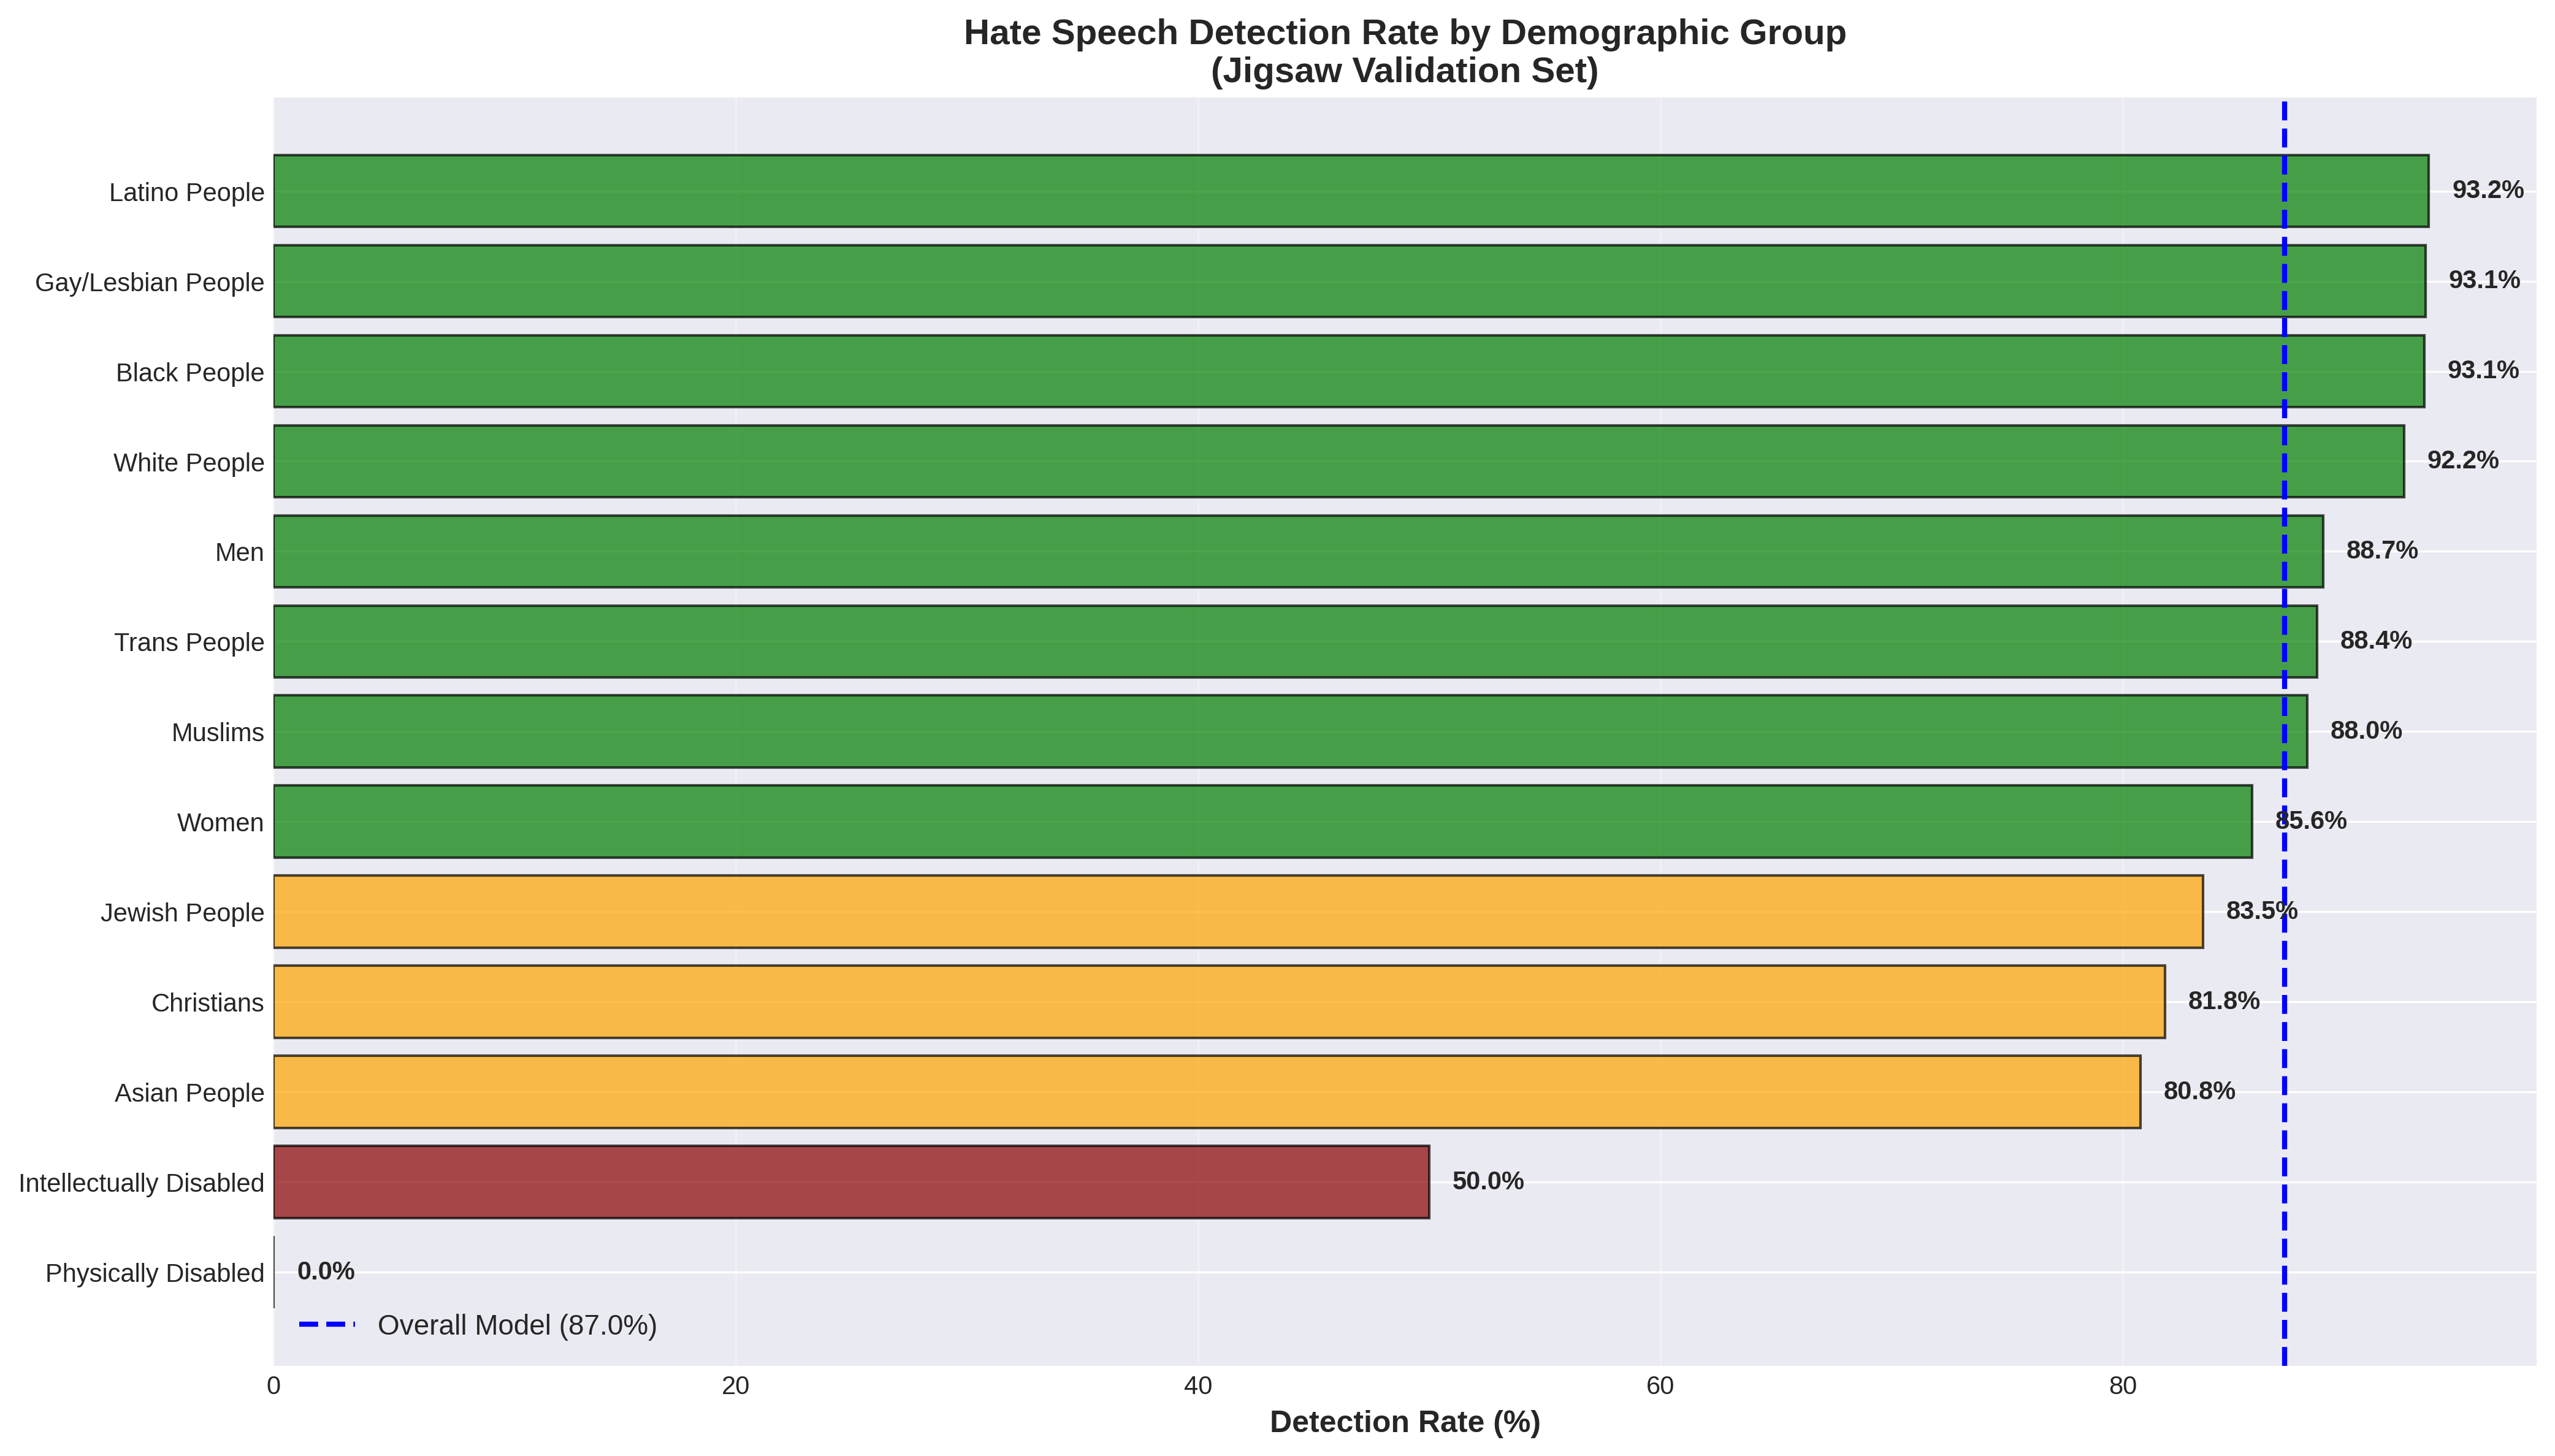


jigsaw_fairness_protection_surveillance.png:


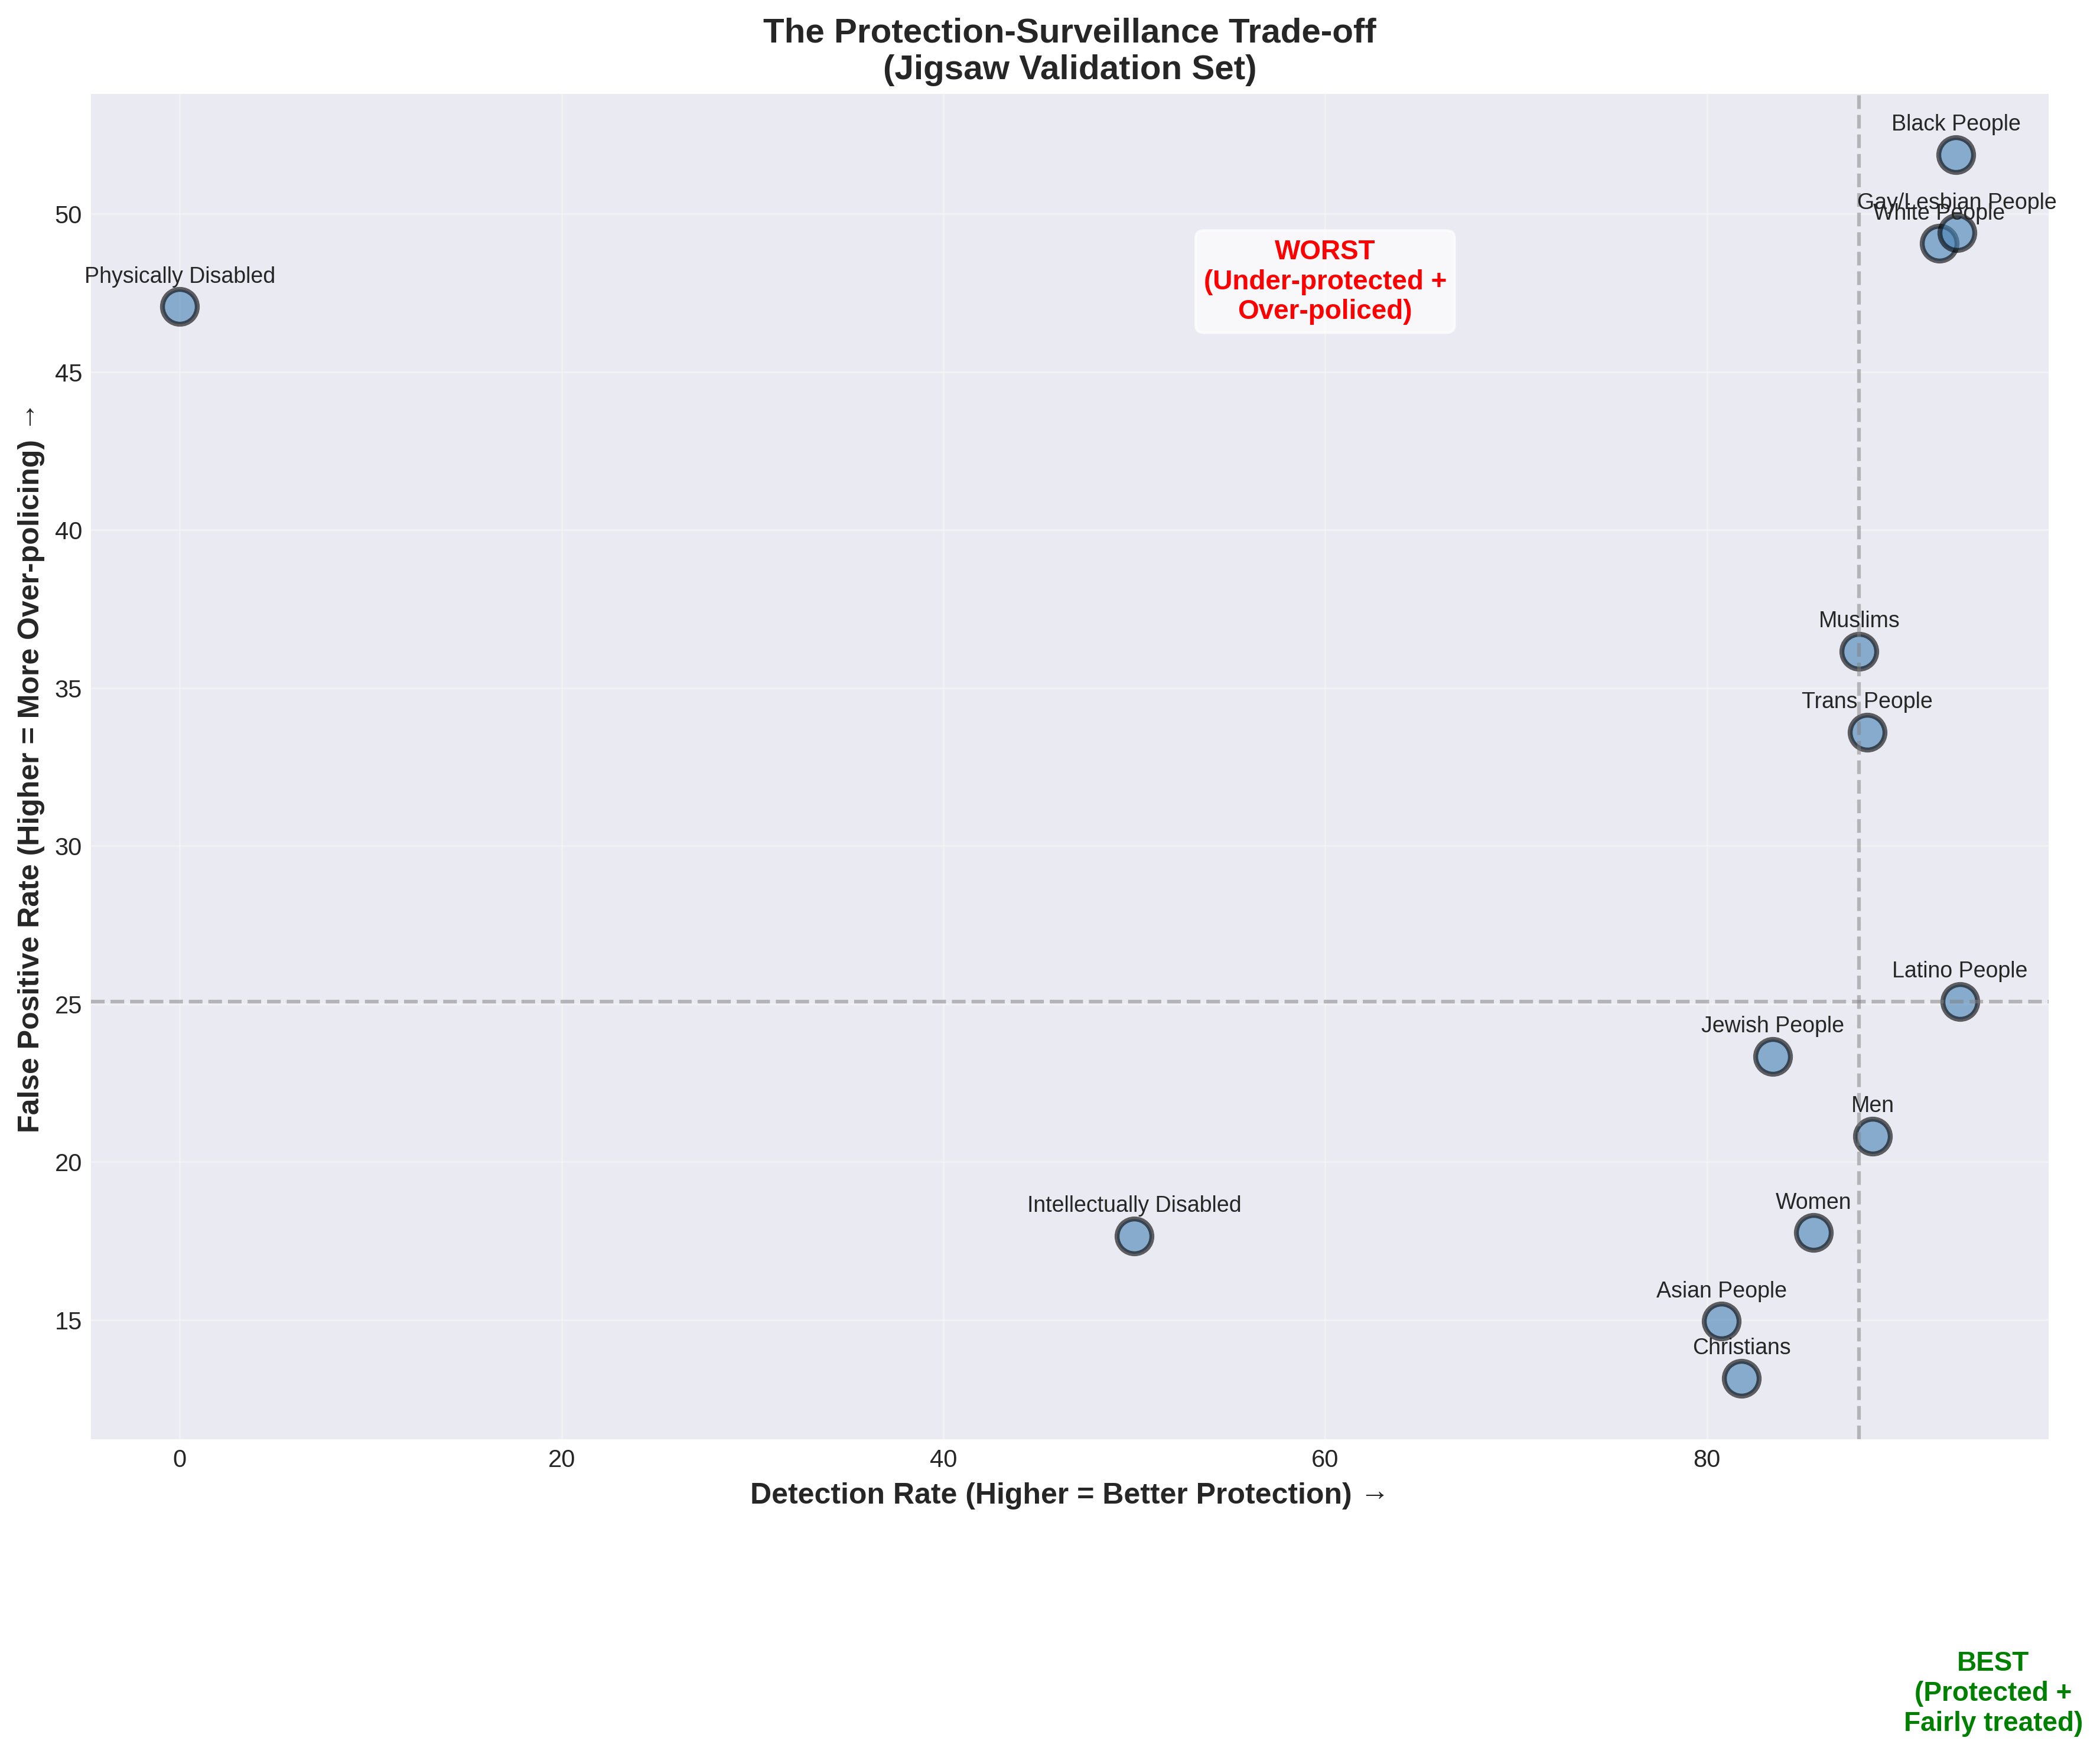

In [ ]:
# ============================================================================
# DISPLAY ALL SAVED CONFUSION MATRICES
# ============================================================================

import os
from IPython.display import Image, display

print("="*70)
print("SAVED CONFUSION MATRIX FILES")
print("="*70)

# List all confusion matrix files
cm_files = [f for f in os.listdir('.') if f.startswith('jigsaw_cm_') and f.endswith('.png')]
cm_files.sort()

print(f"\n✓ Found {len(cm_files)} confusion matrix files:\n")
for i, file in enumerate(cm_files, 1):
    print(f"  {i}. {file}")

# Also check for comparison visualizations
comparison_files = [
    'jigsaw_fairness_detection_rates.png',
    'jigsaw_fairness_protection_surveillance.png'
]

print(f"\n✓ Comparison visualizations:")
for file in comparison_files:
    if os.path.exists(file):
        print(f"  • {file}")

print("\n" + "="*70)
print("DISPLAYING ALL CONFUSION MATRICES")
print("="*70)

# Display each confusion matrix
for file in cm_files:
    print(f"\n{'='*70}")
    print(f"  {file.replace('jigsaw_cm_', '').replace('.png', '').replace('_', ' ').title()}")
    print('='*70)
    display(Image(filename=file))

# Display comparison charts
print(f"\n{'='*70}")
print("COMPARISON CHARTS")
print('='*70)

for file in comparison_files:
    if os.path.exists(file):
        print(f"\n{file}:")
        display(Image(filename=file))

In [ ]:
from google.colab import files

# Download CSV (for Excel/analysis)
files.download('jigsaw_fairness_metrics_table.csv')

# Download HTML (for reports/presentations)
files.download('jigsaw_fairness_metrics_styled.html')

print("✓ Files downloaded to your computer!")
print("  • Open CSV in Excel/Google Sheets")
print("  • Open HTML in your web browser for styled view")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Files downloaded to your computer!
  • Open CSV in Excel/Google Sheets
  • Open HTML in your web browser for styled view


## Fairness Evaluation - HateCheck Dataset

**Objective:** Validate Jigsaw findings with controlled testing

**HateCheck Dataset:**
- **Source:** Academic benchmark for hate speech fairness testing
- **Size:** 3,728 functionally similar test cases
- **Design:** Test cases vary ONLY by demographic target
- **Distribution:** ~69% hateful, ~31% non-hateful

**Why HateCheck Matters:**
- **Controlled testing:** Removes confounding variables (text style, length, etc.)
- **Functional equivalence:** Same attack, different target
- **Example:** "I hate [women/men/Black people/Muslims]" - only target changes
- **Validates patterns:** If bias replicates here, it's systematic, not dataset-specific

**Demographic Groups in HateCheck:**
- gay people, women, disabled people, Muslims, black people, trans people, immigrants

**Analysis:**
Compare detection rates and FP rates across groups to identify:
1. Consistent bias patterns from Jigsaw
2. Groups facing double jeopardy (under-protected + over-policed)
3. Magnitude of fairness gap in controlled setting

### Hatespeech Detection Rate by Demography

PHASE 7: FAIRNESS EVALUATION WITH HATECHECK

[STEP 1/6] Downloading HateCheck dataset...
✓ Downloaded 3,728 test cases
  Demographic groups: 8

[STEP 2/6] Loading trained model...


Device set to use cuda:0


✓ Model loaded on cuda

[STEP 3/6] Preparing HateCheck data...
✓ Hateful cases: 2,563

[STEP 4/6] Generating predictions (~2-3 minutes)...
✓ Predictions complete in 2.2 seconds

[STEP 5/6] Calculating fairness metrics by demographic...
✓ Calculated metrics for 8 groups

📊 TOP 5 BEST PROTECTED:
  gay people: 96.2%
  black people: 96.1%
  trans people: 92.4%
  Muslims: 92.0%
  immigrants: 85.2%

📊 BOTTOM 5 WORST PROTECTED:
  disabled people: 74.0%
  women: 83.9%
  immigrants: 85.2%
  Muslims: 92.0%
  trans people: 92.4%

⚠️  FAIRNESS GAP: 22.3 percentage points

[STEP 6/6] Generating fairness visualizations...


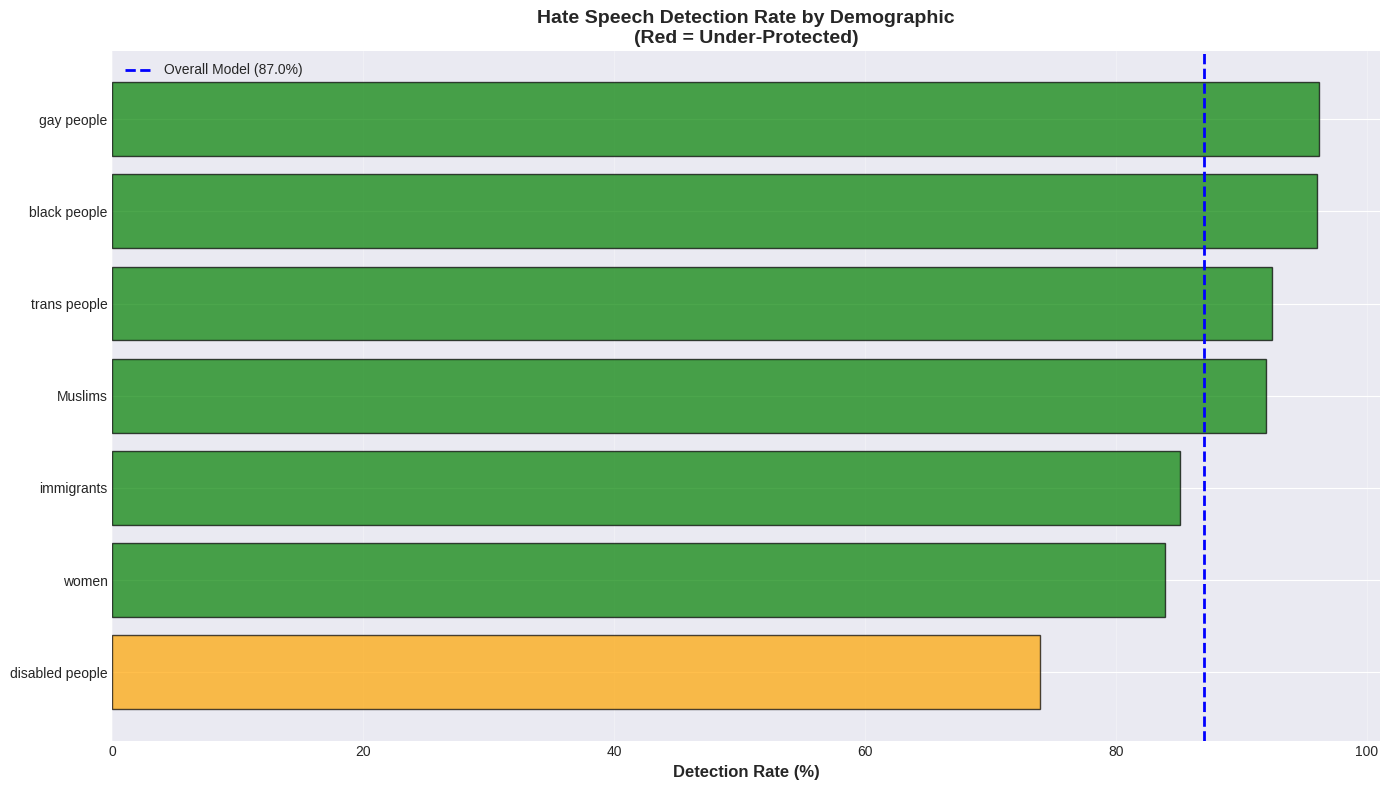

✓ Saved: fairness_viz1_detection_rates.png


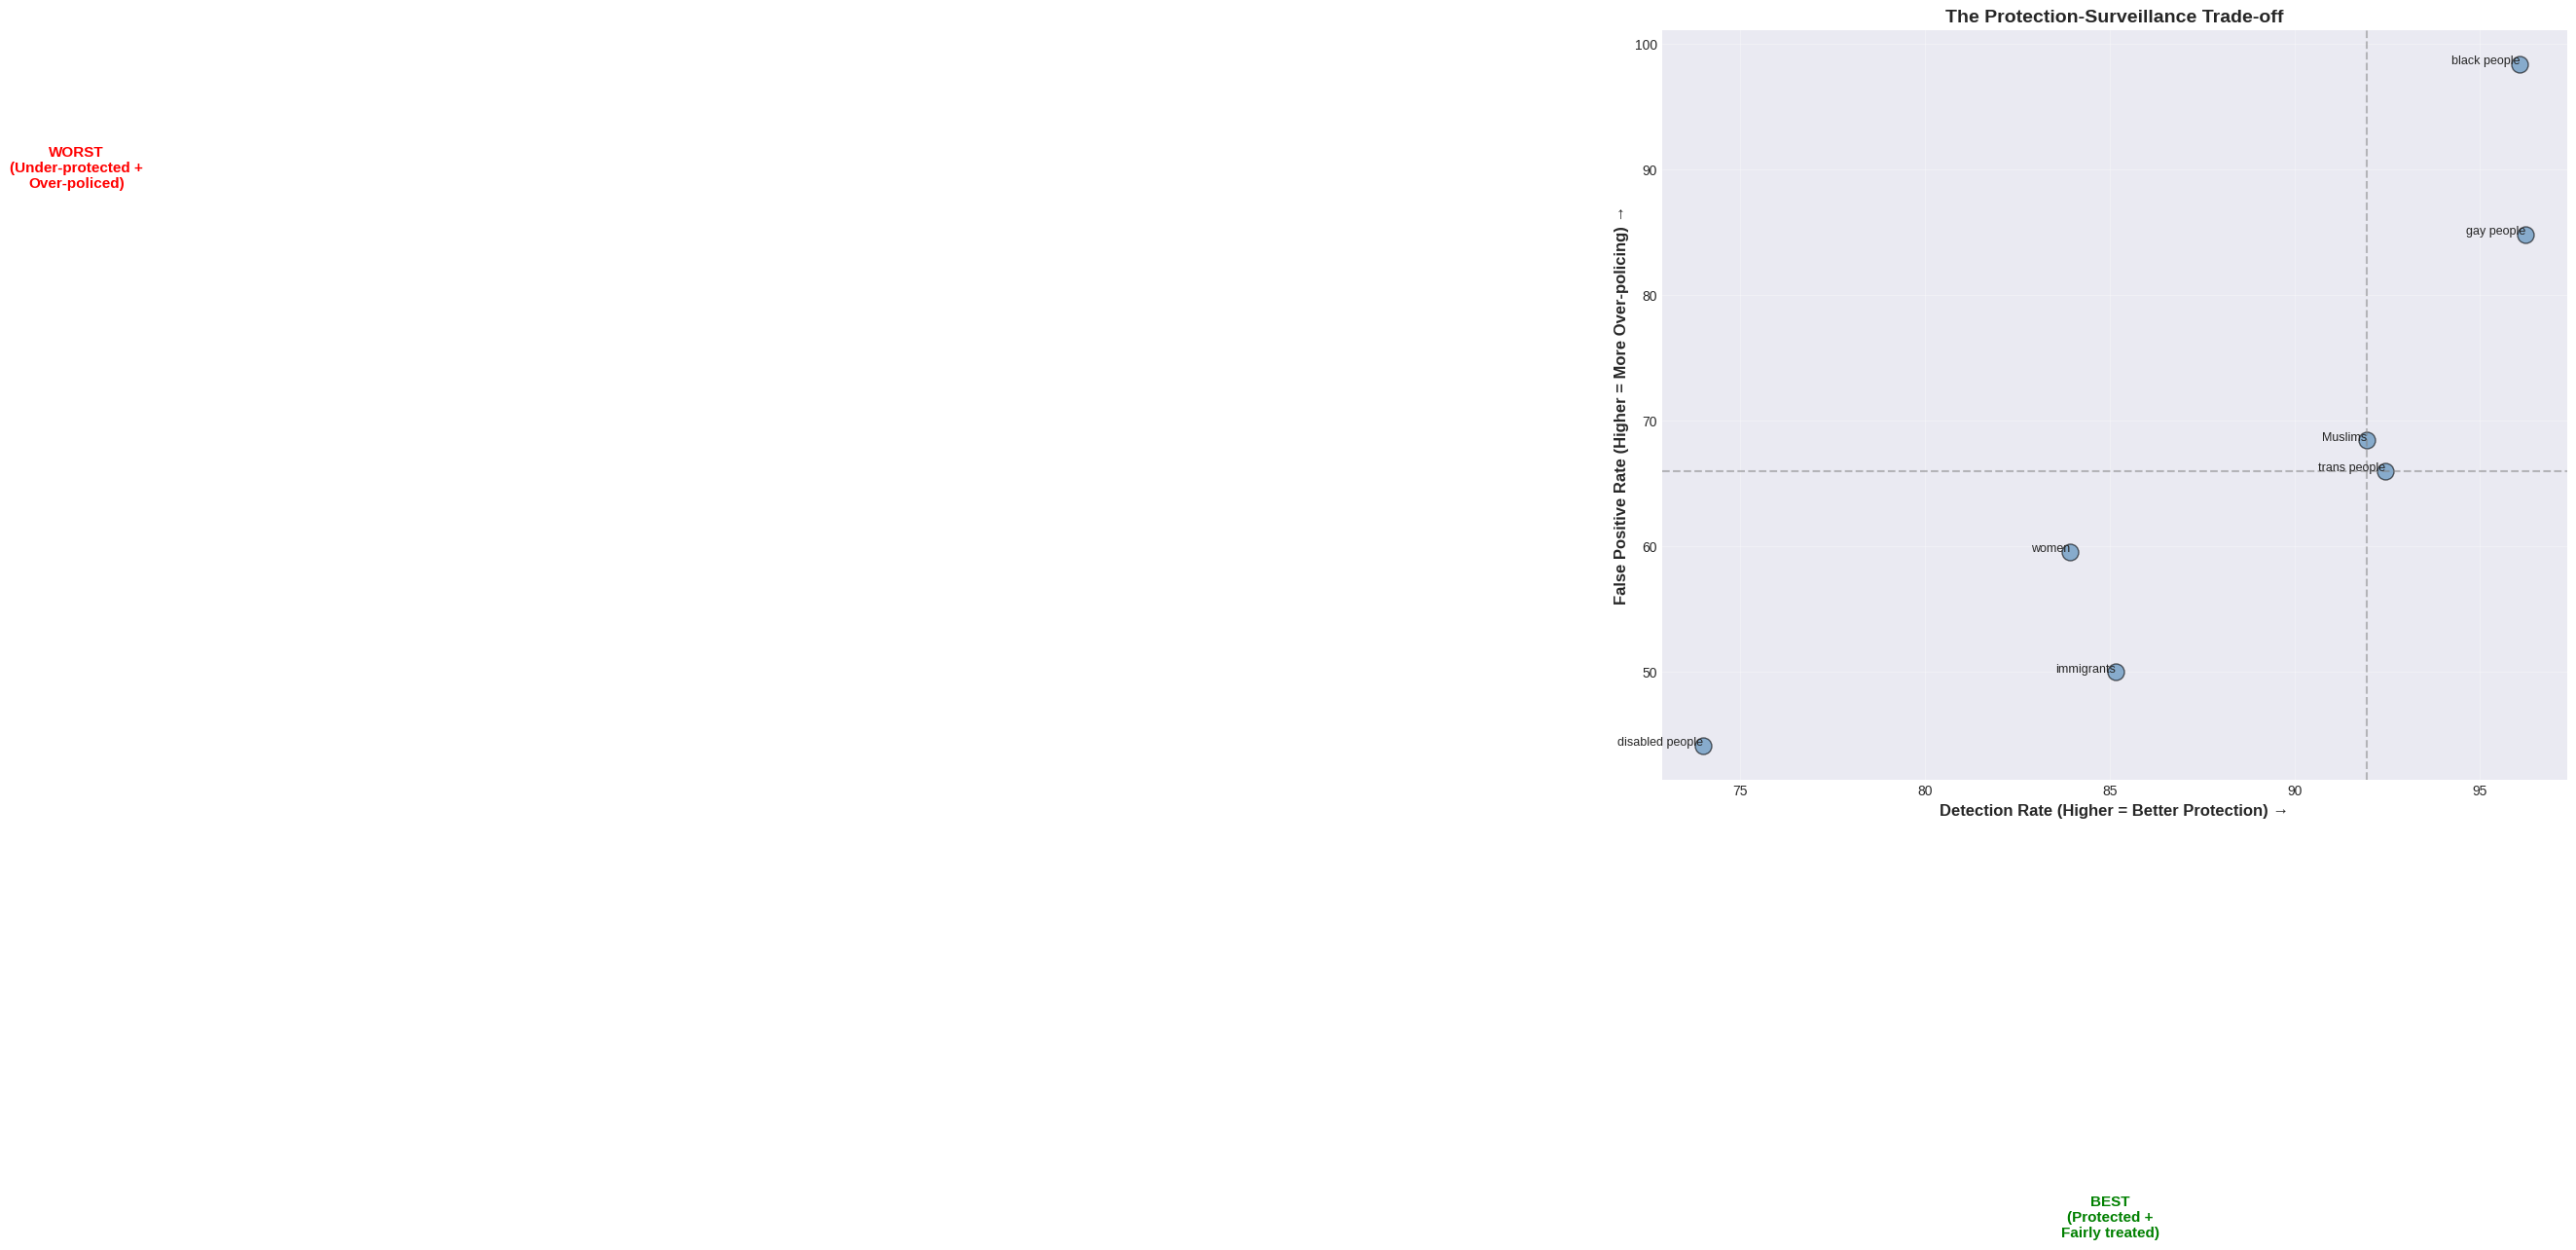

✓ Saved: fairness_viz2_protection_surveillance.png

✓✓✓ FAIRNESS EVALUATION COMPLETE! ✓✓✓

🎯 Key Finding: 22.3 percentage point gap in protection
   This demonstrates measurable algorithmic bias!

📁 Files created:
  ✓ hatecheck_fairness_results.csv
  ✓ fairness_viz1_detection_rates.png
  ✓ fairness_viz2_protection_surveillance.png


In [ ]:
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("PHASE 7: FAIRNESS EVALUATION WITH HATECHECK")
print("="*80)

# [STEP 1] Download HateCheck
print("\n[STEP 1/6] Downloading HateCheck dataset...")
!wget -q https://raw.githubusercontent.com/paul-rottger/hatecheck-data/main/test_suite_cases.csv -O hatecheck.csv

hatecheck = pd.read_csv('hatecheck.csv')
print(f"✓ Downloaded {len(hatecheck):,} test cases")
print(f"  Demographic groups: {len(hatecheck['target_ident'].unique())}")

# [STEP 2] Load trained model
print("\n[STEP 2/6] Loading trained model...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DistilBertForSequenceClassification.from_pretrained('./hate_speech_detector_full_final') # Using the correct path from CONFIG
tokenizer = DistilBertTokenizer.from_pretrained('./hate_speech_detector_full_final') # Using the correct path from CONFIG
model.to(device)
model.eval()

classifier = pipeline('text-classification', model=model, tokenizer=tokenizer,
                     device=0 if torch.cuda.is_available() else -1, batch_size=32)
print(f"✓ Model loaded on {device}")

# [STEP 3] Prepare data
print("\n[STEP 3/6] Preparing HateCheck data...")
hatecheck['hateful'] = (hatecheck['label_gold'] == 'hateful').astype(int)
print(f"✓ Hateful cases: {hatecheck['hateful'].sum():,}")

# [STEP 4] Generate predictions
print("\n[STEP 4/6] Generating predictions (~2-3 minutes)...")
import time
start = time.time()

predictions = classifier(hatecheck['test_case'].tolist(), batch_size=32)
hatecheck['predicted'] = [1 if p['label'] == 'LABEL_1' else 0 for p in predictions]

print(f"✓ Predictions complete in {time.time()-start:.1f} seconds")

# [STEP 5] Calculate fairness metrics
print("\n[STEP 5/6] Calculating fairness metrics by demographic...")

fairness_results = []

for target_group in hatecheck['target_ident'].unique():
    subset = hatecheck[hatecheck['target_ident'] == target_group]

    # Detection rate (recall on hateful content)
    hateful_subset = subset[subset['hateful'] == 1]
    detection_rate = (hateful_subset['predicted'] == 1).mean() if len(hateful_subset) > 0 else np.nan

    # False positive rate (on non-hateful content)
    non_hateful_subset = subset[subset['hateful'] == 0]
    false_positive_rate = (non_hateful_subset['predicted'] == 1).mean() if len(non_hateful_subset) > 0 else np.nan

    # Overall metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        subset['hateful'], subset['predicted'], average='binary', zero_division=0
    )

    fairness_results.append({
        'target_group': target_group,
        'n_cases': len(subset),
        'detection_rate': detection_rate,
        'false_positive_rate': false_positive_rate,
        'recall': recall,
        'f1': f1
    })

fairness_df = pd.DataFrame(fairness_results).sort_values('detection_rate')
fairness_df.to_csv('hatecheck_fairness_results.csv', index=False)

print(f"✓ Calculated metrics for {len(fairness_df)} groups")

# Show top/bottom performers
print(f"\n📊 TOP 5 BEST PROTECTED:")
for _, row in fairness_df.nlargest(5, 'detection_rate').iterrows():
    print(f"  {row['target_group']}: {row['detection_rate']*100:.1f}%")

print(f"\n📊 BOTTOM 5 WORST PROTECTED:")
for _, row in fairness_df.nsmallest(5, 'detection_rate').iterrows():
    print(f"  {row['target_group']}: {row['detection_rate']*100:.1f}%")

# Calculate disparity
max_det = fairness_df['detection_rate'].max()
min_det = fairness_df['detection_rate'].min()
print(f"\n⚠️  FAIRNESS GAP: {(max_det-min_det)*100:.1f} percentage points")

# [STEP 6] Generate visualizations
print("\n[STEP 6/6] Generating fairness visualizations...")

plt.style.use('seaborn-v0_8-darkgrid')

# Clean data: remove any NaN and ensure strings
fairness_df_clean = fairness_df.dropna(subset=['detection_rate', 'false_positive_rate'])
fairness_df_clean['target_group'] = fairness_df_clean['target_group'].astype(str)

# VIZ 1: Detection rates
fig, ax = plt.subplots(figsize=(14, 8))
colors = ['red' if x < 0.6 else 'orange' if x < 0.8 else 'green'
          for x in fairness_df_clean['detection_rate']]
ax.barh(fairness_df_clean['target_group'], fairness_df_clean['detection_rate'] * 100,
        color=colors, edgecolor='black', alpha=0.7)
ax.axvline(87.0, color='blue', linestyle='--', linewidth=2, label='Overall Model (87.0%)')
ax.set_xlabel('Detection Rate (%)', fontsize=12, weight='bold')
ax.set_title('Hate Speech Detection Rate by Demographic\n(Red = Under-Protected)', fontsize=14, weight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('fairness_viz1_detection_rates.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: fairness_viz1_detection_rates.png")

# VIZ 2: Protection-Surveillance Quadrant
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(fairness_df_clean['detection_rate'] * 100,
           fairness_df_clean['false_positive_rate'] * 100,
           s=150, alpha=0.6, c='steelblue', edgecolors='black')

for _, row in fairness_df_clean.iterrows():
    ax.annotate(row['target_group'],
                (row['detection_rate'] * 100, row['false_positive_rate'] * 100),
                fontsize=9, ha='right')

median_det = fairness_df_clean['detection_rate'].median() * 100
median_fp = fairness_df_clean['false_positive_rate'].median() * 100
ax.axhline(median_fp, color='gray', linestyle='--', alpha=0.5)
ax.axvline(median_det, color='gray', linestyle='--', alpha=0.5)

ax.text(30, max(fairness_df_clean['false_positive_rate'] * 100) * 0.9,
        'WORST\n(Under-protected +\nOver-policed)',
        ha='center', fontsize=11, color='red', weight='bold',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
ax.text(85, 5, 'BEST\n(Protected +\nFairly treated)',
        ha='center', fontsize=11, color='green', weight='bold',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

ax.set_xlabel('Detection Rate (Higher = Better Protection) →', fontsize=12, weight='bold')
ax.set_ylabel('False Positive Rate (Higher = More Over-policing) →', fontsize=12, weight='bold')
ax.set_title('The Protection-Surveillance Trade-off', fontsize=14, weight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('fairness_viz2_protection_surveillance.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: fairness_viz2_protection_surveillance.png")

print("\n" + "="*80)
print("✓✓✓ FAIRNESS EVALUATION COMPLETE! ✓✓✓")
print("="*80)
print(f"\n🎯 Key Finding: {(max_det-min_det)*100:.1f} percentage point gap in protection")
print(f"   This demonstrates measurable algorithmic bias!")
print("\n📁 Files created:")
print(f"  ✓ hatecheck_fairness_results.csv")
print(f"  ✓ fairness_viz1_detection_rates.png")
print(f"  ✓ fairness_viz2_protection_surveillance.png")
print("="*80)

Device set to use cuda:0


HATECHECK FAIRNESS EVALUATION

[STEP 1/6] Downloading HateCheck dataset...
✓ Downloaded 3,728 test cases
  Columns: ['Unnamed: 0', 'functionality', 'case_id', 'test_case', 'label_gold', 'target_ident', 'direction', 'focus_words', 'focus_lemma', 'ref_case_id', 'ref_templ_id', 'templ_id', 'case_templ']

[STEP 2/6] Preparing HateCheck data...
✓ Test case distribution:
  Hateful: 2,563 (68.8%)
  Non-hateful: 1,165 (31.2%)

✓ Demographic groups in HateCheck:
  • gay people: 551 test cases
  • women: 509 test cases
  • disabled people: 484 test cases
  • Muslims: 484 test cases
  • black people: 482 test cases
  • trans people: 463 test cases
  • immigrants: 463 test cases

[STEP 3/6] Generating predictions on HateCheck (~2-3 minutes)...
  Predicting on 3,728 test cases...
✓ Predictions complete
  Overall HateCheck accuracy: 70.1%

[STEP 4/6] Calculating fairness metrics by demographic group...
✓ Analyzing 7 demographic groups
✓ Calculated metrics for 7 groups

HATECHECK FAIRNESS RESULTS

📊 

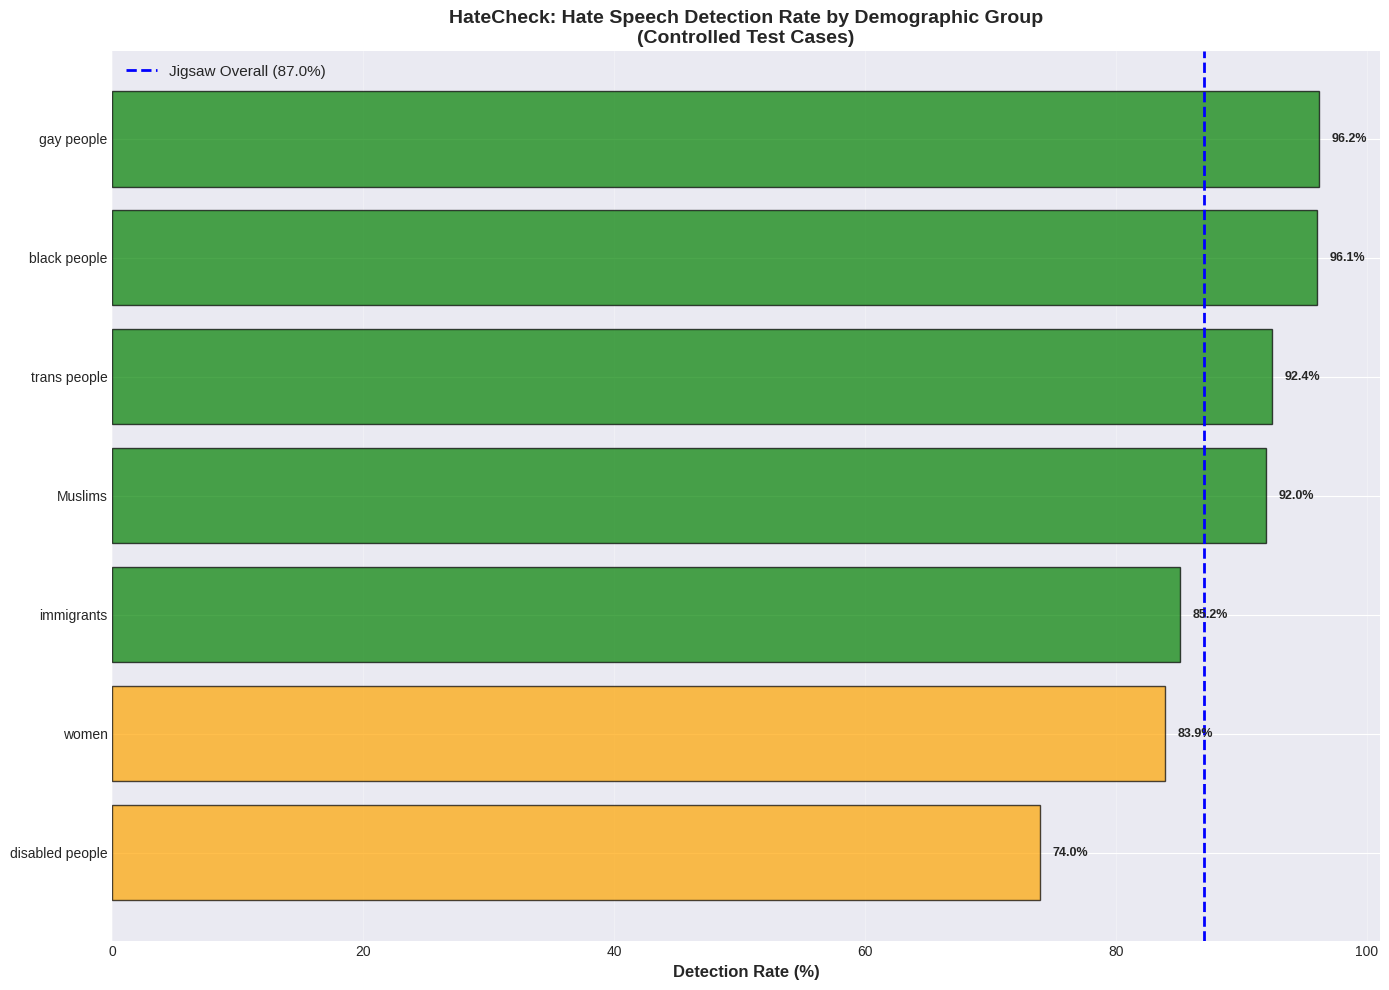

  ✓ Saved: hatecheck_protection_surveillance.png


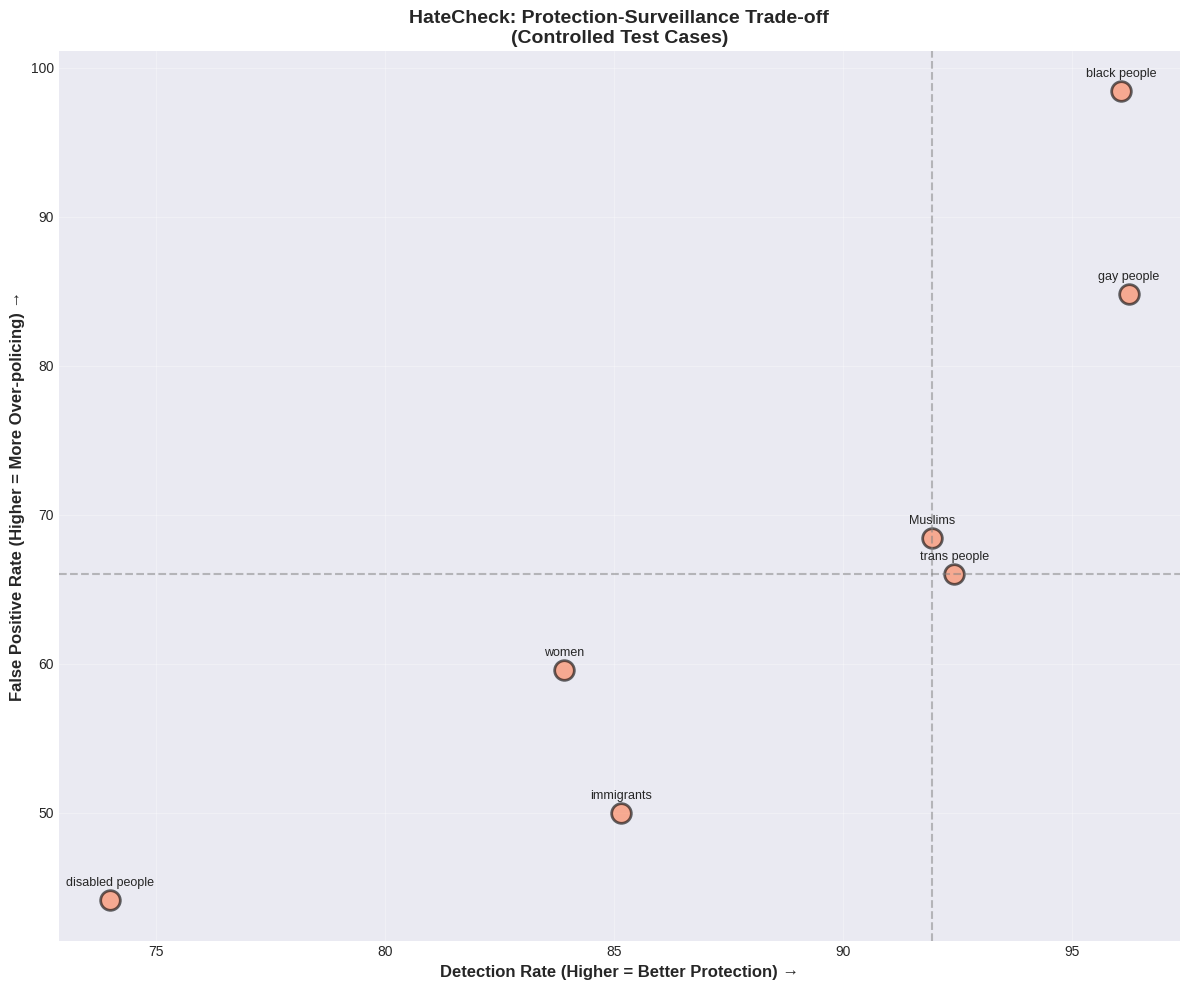


[STEP 6/6] Saving results...
  ✓ Saved: hatecheck_fairness_metrics.csv

✓✓✓ HATECHECK EVALUATION COMPLETE!

🎯 Key Finding: 22.3 percentage point fairness gap
   Best: gay people (96.2%)
   Worst: disabled people (74.0%)


In [ ]:
# ============================================================================
# HATECHECK FAIRNESS EVALUATION
# ============================================================================

print("="*70)
print("HATECHECK FAIRNESS EVALUATION")
print("="*70)

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# STEP 1: Download and Load HateCheck
# ============================================================================
print("\n[STEP 1/6] Downloading HateCheck dataset...")

hatecheck_url = 'https://raw.githubusercontent.com/paul-rottger/hatecheck-data/main/test_suite_cases.csv'
hatecheck = pd.read_csv(hatecheck_url)

print(f"✓ Downloaded {len(hatecheck):,} test cases")
print(f"  Columns: {list(hatecheck.columns)}")

# ============================================================================
# STEP 2: Prepare HateCheck Data
# ============================================================================
print("\n[STEP 2/6] Preparing HateCheck data...")

# Create binary label
hatecheck['hateful'] = (hatecheck['label_gold'] == 'hateful').astype(int)

# Check distribution
n_hateful = hatecheck['hateful'].sum()
n_non_hateful = len(hatecheck) - n_hateful

print(f"✓ Test case distribution:")
print(f"  Hateful: {n_hateful:,} ({n_hateful/len(hatecheck):.1%})")
print(f"  Non-hateful: {n_non_hateful:,} ({n_non_hateful/len(hatecheck):.1%})")

# Show demographic groups
if 'target_ident' in hatecheck.columns:
    print(f"\n✓ Demographic groups in HateCheck:")
    target_counts = hatecheck['target_ident'].value_counts()
    for group, count in target_counts.head(15).items():
        print(f"  • {group}: {count:,} test cases")

# ============================================================================
# STEP 3: Generate Predictions on HateCheck
# ============================================================================
print("\n[STEP 3/6] Generating predictions on HateCheck (~2-3 minutes)...")

# Load model and tokenizer if not already in memory
if 'trainer' not in locals():
    print("  Loading model...")
    from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, pipeline

    model = DistilBertForSequenceClassification.from_pretrained(
        CONFIG['paths']['model_output']
    )
    tokenizer = DistilBertTokenizerFast.from_pretrained(
        CONFIG['paths']['model_output']
    )
    model.to(device)
    model.eval()

    classifier = pipeline(
        'text-classification',
        model=model,
        tokenizer=tokenizer,
        device=0 if torch.cuda.is_available() else -1
    )
    print("  ✓ Model loaded")
else:
    # Use existing trainer
    classifier = pipeline(
        'text-classification',
        model=trainer.model,
        tokenizer=tokenizer,
        device=0 if torch.cuda.is_available() else -1
    )

# Generate predictions
print(f"  Predicting on {len(hatecheck):,} test cases...")
predictions = classifier(hatecheck['test_case'].tolist(), batch_size=32)
hatecheck['predicted'] = [1 if p['label'] == 'LABEL_1' else 0 for p in predictions]

print(f"✓ Predictions complete")

# Overall accuracy
overall_accuracy = (hatecheck['predicted'] == hatecheck['hateful']).mean()
print(f"  Overall HateCheck accuracy: {overall_accuracy:.1%}")

# ============================================================================
# STEP 4: Calculate Fairness Metrics by Demographic Group
# ============================================================================
print("\n[STEP 4/6] Calculating fairness metrics by demographic group...")

hatecheck_fairness_results = []

# Get unique demographic targets
demographic_groups = hatecheck['target_ident'].unique()
demographic_groups = [g for g in demographic_groups if pd.notna(g)]

print(f"✓ Analyzing {len(demographic_groups)} demographic groups")

for target_group in demographic_groups:
    subset = hatecheck[hatecheck['target_ident'] == target_group]

    if len(subset) < 10:  # Skip groups with too few samples
        continue

    # Separate hateful and non-hateful
    hateful_subset = subset[subset['hateful'] == 1]
    non_hateful_subset = subset[subset['hateful'] == 0]

    # Detection rate (recall on hateful content)
    if len(hateful_subset) > 0:
        detection_rate = (hateful_subset['predicted'] == 1).mean()
    else:
        detection_rate = np.nan

    # False positive rate (on non-hateful content)
    if len(non_hateful_subset) > 0:
        false_positive_rate = (non_hateful_subset['predicted'] == 1).mean()
    else:
        false_positive_rate = np.nan

    # Overall metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        subset['hateful'], subset['predicted'], average='binary', zero_division=0
    )

    # Confusion matrix
    cm = confusion_matrix(subset['hateful'], subset['predicted'])
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        # Handle cases with only one class
        if cm.shape == (1, 1):
            if subset['hateful'].iloc[0] == 0:
                tn = cm[0, 0]
                fp = fn = tp = 0
            else:
                tp = cm[0, 0]
                tn = fp = fn = 0
        else:
            tn = fp = fn = tp = 0

    hatecheck_fairness_results.append({
        'target_group': target_group,
        'n_cases': len(subset),
        'n_hateful': len(hateful_subset),
        'n_non_hateful': len(non_hateful_subset),
        'detection_rate': detection_rate,
        'false_positive_rate': false_positive_rate,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp)
    })

hatecheck_fairness_df = pd.DataFrame(hatecheck_fairness_results)
hatecheck_fairness_df = hatecheck_fairness_df.sort_values('detection_rate', ascending=False)

print(f"✓ Calculated metrics for {len(hatecheck_fairness_df)} groups")

# ============================================================================
# STEP 5: Display Results
# ============================================================================
print("\n" + "="*70)
print("HATECHECK FAIRNESS RESULTS")
print("="*70)

print("\n📊 DETECTION RATES BY DEMOGRAPHIC GROUP:")
print(f"\n{'Group':<30} {'Test Cases':>12} {'Detection Rate':>16} {'FP Rate':>10}")
print("-"*70)

for idx, row in hatecheck_fairness_df.iterrows():
    if pd.isna(row['detection_rate']):
        continue

    # Status emoji
    if row['detection_rate'] >= 0.85:
        status = "✓"
    elif row['detection_rate'] >= 0.70:
        status = "⚠️"
    else:
        status = "🚨"

    print(f"{status} {row['target_group']:<28} "
          f"{row['n_cases']:>12,} "
          f"{row['detection_rate']:>15.1%} "
          f"{row['false_positive_rate']:>9.1%}")

# Summary statistics
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)

valid_detection = hatecheck_fairness_df['detection_rate'].dropna()

if len(valid_detection) > 0:
    print(f"\nDetection Rate:")
    print(f"  Mean:   {valid_detection.mean():.1%}")
    print(f"  Median: {valid_detection.median():.1%}")
    print(f"  Min:    {valid_detection.min():.1%} ({hatecheck_fairness_df.loc[valid_detection.idxmin(), 'target_group']})")
    print(f"  Max:    {valid_detection.max():.1%} ({hatecheck_fairness_df.loc[valid_detection.idxmax(), 'target_group']})")
    print(f"  Range:  {valid_detection.max() - valid_detection.min():.1%} (fairness gap)")

# ============================================================================
# STEP 6: Create Visualizations
# ============================================================================
print("\n[STEP 5/6] Creating visualizations...")

# Viz 1: Detection Rates Bar Chart
fig, ax = plt.subplots(figsize=(14, 10))

hatecheck_df_sorted = hatecheck_fairness_df.dropna(subset=['detection_rate']).sort_values('detection_rate')

colors = ['darkred' if x < 0.70 else 'orange' if x < 0.85 else 'green'
          for x in hatecheck_df_sorted['detection_rate']]

bars = ax.barh(hatecheck_df_sorted['target_group'],
               hatecheck_df_sorted['detection_rate'] * 100,
               color=colors, edgecolor='black', alpha=0.7)

ax.axvline(87.0, color='blue', linestyle='--', linewidth=2,
           label='Jigsaw Overall (87.0%)')
ax.set_xlabel('Detection Rate (%)', fontsize=12, weight='bold')
ax.set_title('HateCheck: Hate Speech Detection Rate by Demographic Group\n(Controlled Test Cases)',
             fontsize=14, weight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(hatecheck_df_sorted.iterrows()):
    ax.text(row['detection_rate'] * 100 + 1, i,
            f"{row['detection_rate']:.1%}",
            va='center', fontsize=9, weight='bold')

plt.tight_layout()
plt.savefig('hatecheck_detection_rates.png', dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: hatecheck_detection_rates.png")
plt.show()

# Viz 2: Protection-Surveillance Quadrant
fig, ax = plt.subplots(figsize=(12, 10))

hatecheck_plot_df = hatecheck_fairness_df.dropna(subset=['detection_rate', 'false_positive_rate'])

scatter = ax.scatter(hatecheck_plot_df['detection_rate'] * 100,
                    hatecheck_plot_df['false_positive_rate'] * 100,
                    s=200, alpha=0.6, c='coral',
                    edgecolors='black', linewidth=2)

# Add labels
for idx, row in hatecheck_plot_df.iterrows():
    ax.annotate(row['target_group'],
                (row['detection_rate'] * 100, row['false_positive_rate'] * 100),
                fontsize=9, ha='center', xytext=(0, 10),
                textcoords='offset points')

# Add quadrant lines
median_det = hatecheck_plot_df['detection_rate'].median() * 100
median_fp = hatecheck_plot_df['false_positive_rate'].median() * 100
ax.axhline(median_fp, color='gray', linestyle='--', alpha=0.5)
ax.axvline(median_det, color='gray', linestyle='--', alpha=0.5)

ax.set_xlabel('Detection Rate (Higher = Better Protection) →', fontsize=12, weight='bold')
ax.set_ylabel('False Positive Rate (Higher = More Over-policing) →', fontsize=12, weight='bold')
ax.set_title('HateCheck: Protection-Surveillance Trade-off\n(Controlled Test Cases)',
             fontsize=14, weight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hatecheck_protection_surveillance.png', dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: hatecheck_protection_surveillance.png")
plt.show()

# ============================================================================
# Save Results
# ============================================================================
print("\n[STEP 6/6] Saving results...")

hatecheck_fairness_df.to_csv('hatecheck_fairness_metrics.csv', index=False)
print(f"  ✓ Saved: hatecheck_fairness_metrics.csv")

print("\n" + "="*70)
print("✓✓✓ HATECHECK EVALUATION COMPLETE!")
print("="*70)

if len(valid_detection) > 0:
    print(f"\n🎯 Key Finding: {(valid_detection.max() - valid_detection.min())*100:.1f} percentage point fairness gap")
    print(f"   Best: {hatecheck_fairness_df.loc[valid_detection.idxmax(), 'target_group']} ({valid_detection.max():.1%})")
    print(f"   Worst: {hatecheck_fairness_df.loc[valid_detection.idxmin(), 'target_group']} ({valid_detection.min():.1%})")

print("="*70)

## Cross-Dataset Comparison: Jigsaw vs HateCheck

**Research Question:** Are the bias patterns we found systematic or dataset-specific?

**Methodology:**
1. Map identity groups between datasets (e.g., "Black People" → "black people")
2. Compare detection rates for same groups across both datasets
3. Calculate statistical correlations (Pearson r, Spearman ρ)
4. Identify groups with consistent patterns vs. outliers

**What Strong Correlation Means:**
- **r > 0.7:** Bias patterns replicate - evidence of systematic algorithmic bias
- **r < 0.4:** Patterns differ - may be dataset-specific artifacts

**Visualizations:**
1. Side-by-side bar chart (detection rates in both datasets)
2. Scatter plot with correlation (Jigsaw detection vs HateCheck detection)
3. Dual quadrant plots (protection-surveillance trade-off in both contexts)

**Expected Insight:**
If Jigsaw and HateCheck show similar patterns despite different methodologies (real-world vs controlled), this proves the bias is built into the model, not the data.

### Detection Rate Comparison: Jigsaw & Hatecheck

JIGSAW vs HATECHECK COMPARISON ANALYSIS

[STEP 1/5] Mapping identity groups between datasets...
✓ Mapped 13 identity groups

[STEP 2/5] Creating comparison table...

JIGSAW vs HATECHECK: SIDE-BY-SIDE COMPARISON

Identity Group                        Jigsaw                                 HateCheck                      Difference     
                        Detection      FP Rate           F1    Detection      FP Rate           F1   Δ Detect      Δ FPR
------------------------------------------------------------------------------------------------------------------------
Latino People               93.2%        25.1%        60.8%          N/A          N/A          N/A        N/A        N/A
Gay People                  93.1%        49.4%        59.7%        96.2%        84.8%        81.3%      -3.1%     -35.4%
Black People                93.1%        51.9%        59.9%        96.1%        98.4%        83.4%      -3.0%     -46.5%
White People                92.2%        49.1%        57.6%

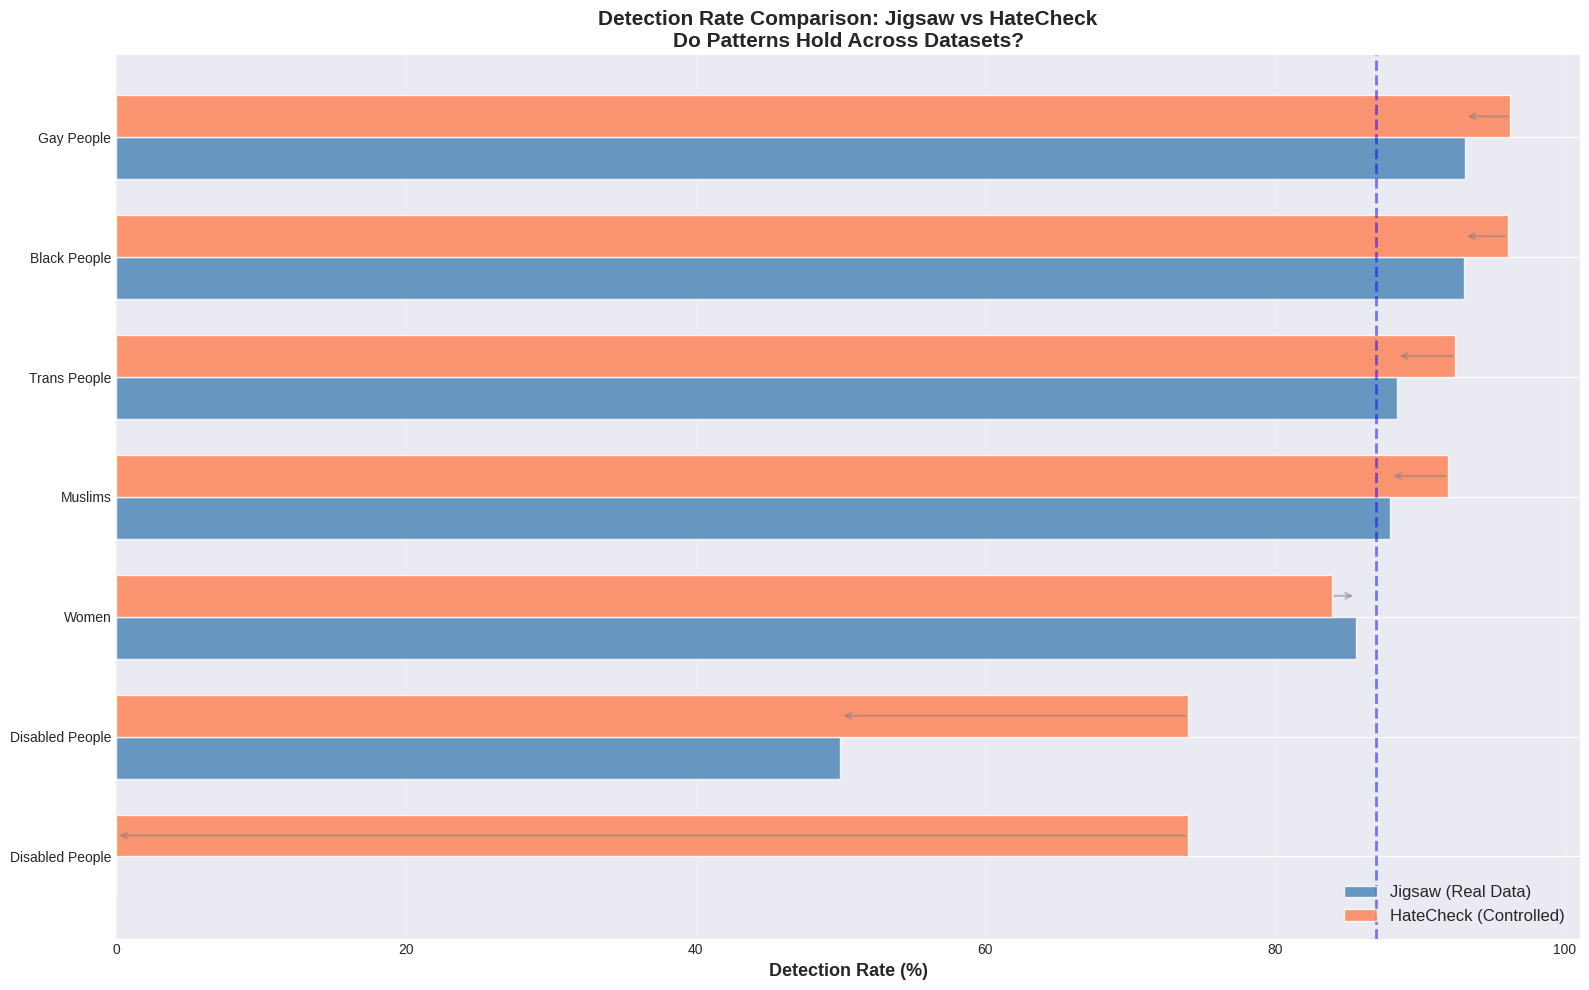

  ✓ Saved: comparison_correlation_scatter.png


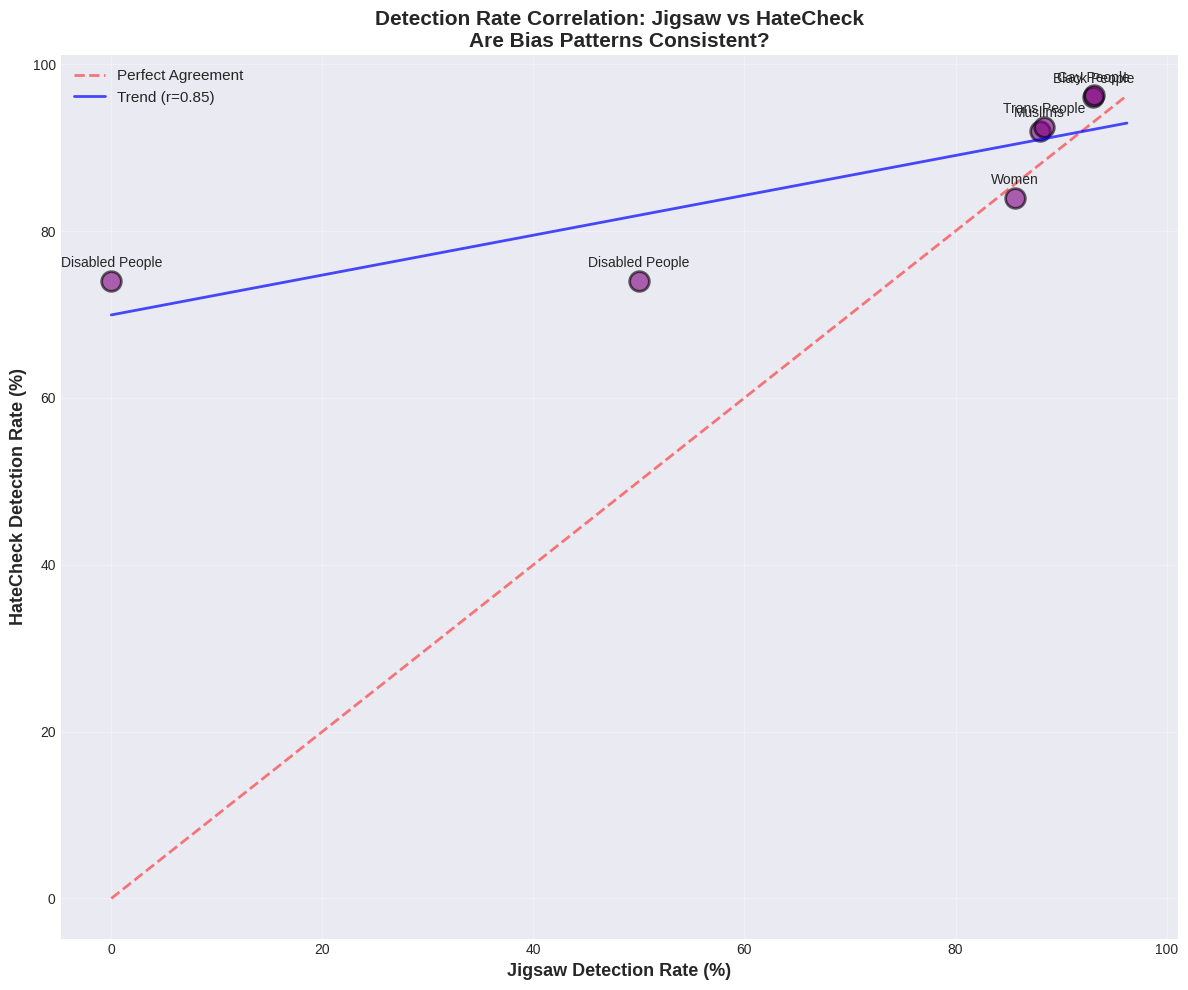

  ✓ Saved: comparison_quadrants.png


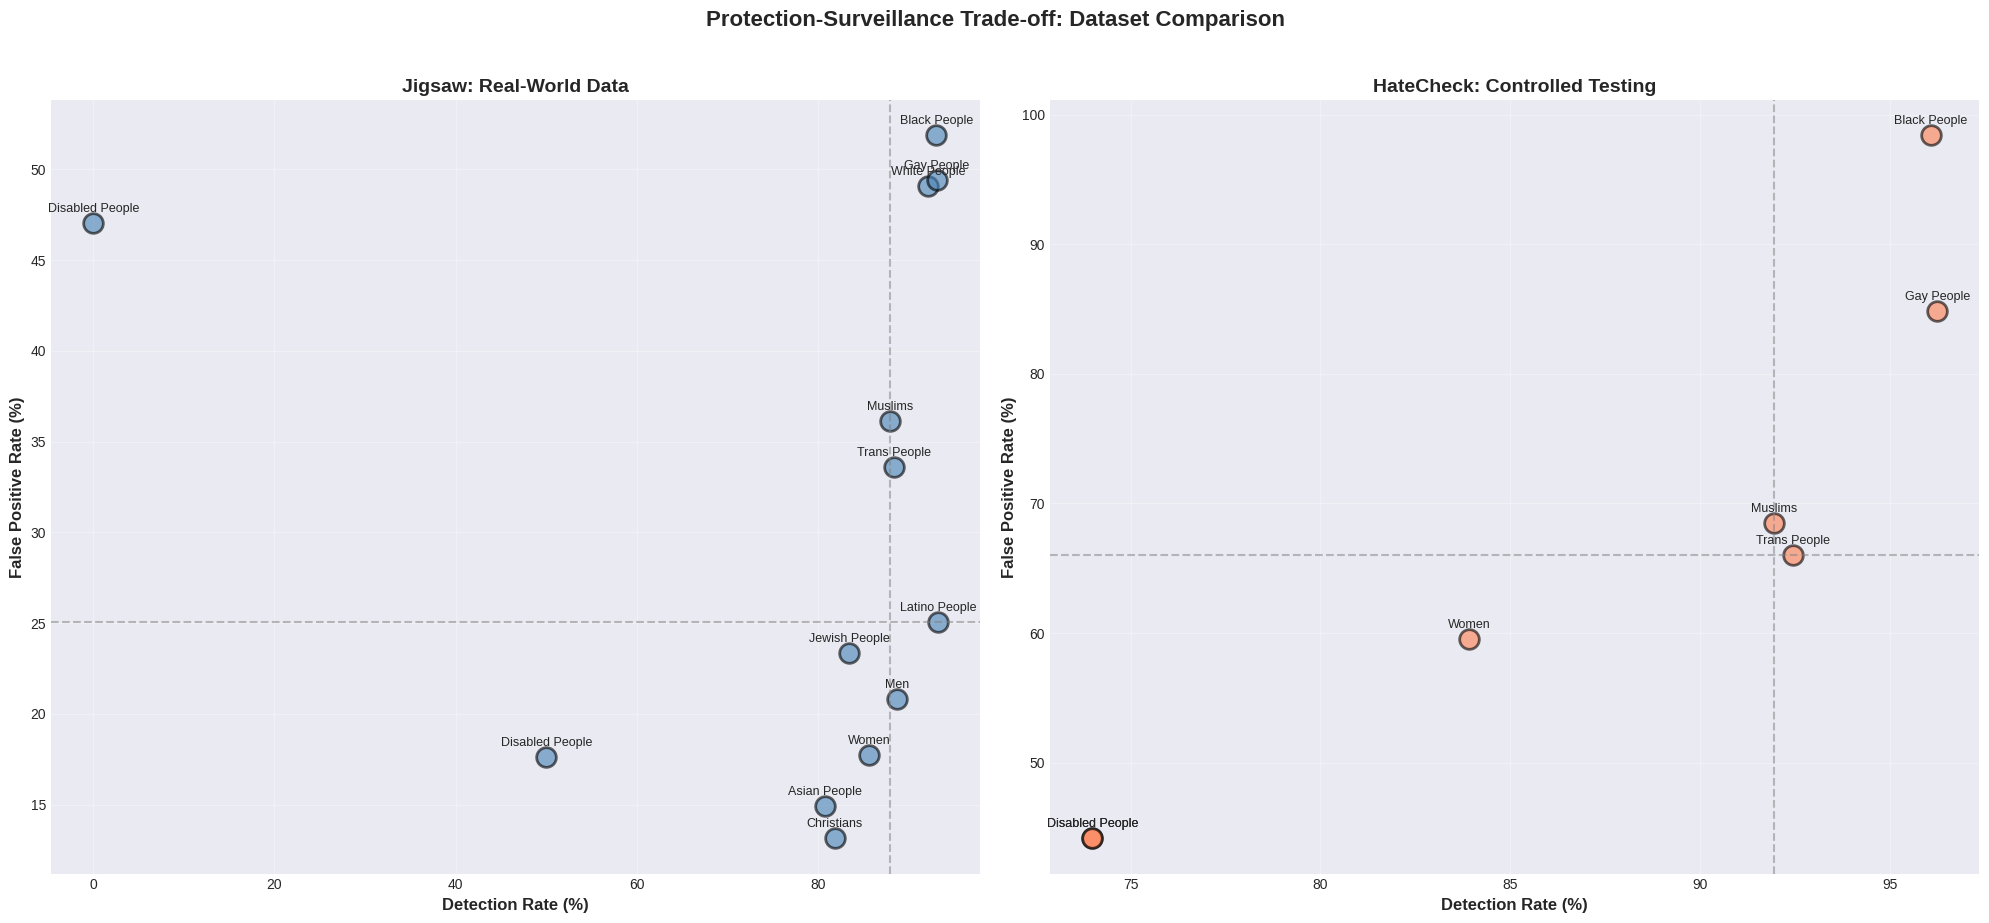


[STEP 5/5] Saving comparison data...
  ✓ Saved: jigsaw_hatecheck_comparison.csv
  ✓ Saved: jigsaw_hatecheck_comparison_formatted.csv

✓✓✓ COMPARISON ANALYSIS COMPLETE!

📁 Generated files:
  • comparison_detection_rates.png - Side-by-side bar chart
  • comparison_correlation_scatter.png - Correlation analysis
  • comparison_quadrants.png - Dual quadrant plots
  • jigsaw_hatecheck_comparison.csv - Raw comparison data
  • jigsaw_hatecheck_comparison_formatted.csv - Report-ready table

🎯 KEY FINDINGS:
  • Detection rate correlation: r = 0.853 (p=0.0147)
  ✓ STRONG CONSISTENCY - Bias patterns replicate across datasets!
  • This validates your findings - the bias is SYSTEMATIC, not random


In [ ]:
# ============================================================================
# JIGSAW vs HATECHECK COMPARISON ANALYSIS
# ============================================================================

print("="*80)
print("JIGSAW vs HATECHECK COMPARISON ANALYSIS")
print("="*80)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# ============================================================================
# STEP 1: Create Mapping Between Dataset Group Names
# ============================================================================
print("\n[STEP 1/5] Mapping identity groups between datasets...")

# Map group names (Jigsaw → HateCheck)
identity_mapping = {
    'Black People': 'black people',
    'White People': 'white people',
    'Asian People': 'asian people',
    'Latino People': 'latino people',
    'Muslims': 'Muslims',
    'Christians': 'christians',
    'Jewish People': 'jewish people',
    'Men': 'men',
    'Women': 'women',
    'Trans People': 'trans people',
    'Gay/Lesbian People': 'gay people',
    'Physically Disabled': 'disabled people',
    'Intellectually Disabled': 'disabled people'
}

# --- FIX START ---
# The 'fairness_df' from Jigsaw was overwritten by HateCheck results.
# Use 'table_numeric_df' which holds the Jigsaw fairness results.
# Rename its columns to match for consistent access.
jigsaw_fairness_for_comparison = table_numeric_df.rename(columns={
    'Identity Group': 'group_name',
    'Total Samples': 'samples',
    'Detection Rate': 'detection_rate',
    'FP Rate': 'false_positive_rate',
    'F1 Score': 'f1'
})
# --- FIX END ---

# Create standardized group names for comparison
comparison_data = []

for jigsaw_name, hatecheck_name in identity_mapping.items():
    # Get Jigsaw data from the corrected DataFrame
    jigsaw_row = jigsaw_fairness_for_comparison[jigsaw_fairness_for_comparison['group_name'] == jigsaw_name]

    # Get HateCheck data
    hatecheck_row = hatecheck_fairness_df[hatecheck_fairness_df['target_group'] == hatecheck_name]

    if len(jigsaw_row) == 0 and len(hatecheck_row) == 0:
        continue

    # Standardized name
    if hatecheck_name in ['black people', 'white people', 'asian people']:
        standard_name = hatecheck_name.title()
    else:
        standard_name = hatecheck_name.title()

    row_data = {'identity': standard_name}

    # Jigsaw metrics
    if len(jigsaw_row) > 0:
        jigsaw_row = jigsaw_row.iloc[0]
        row_data.update({
            'jigsaw_samples': jigsaw_row['samples'],
            'jigsaw_detection': jigsaw_row['detection_rate'],
            'jigsaw_fpr': jigsaw_row['false_positive_rate'],
            'jigsaw_f1': jigsaw_row['f1']
        })
    else:
        row_data.update({
            'jigsaw_samples': np.nan,
            'jigsaw_detection': np.nan,
            'jigsaw_fpr': np.nan,
            'jigsaw_f1': np.nan
        })

    # HateCheck metrics
    if len(hatecheck_row) > 0:
        hatecheck_row = hatecheck_row.iloc[0]
        row_data.update({
            'hatecheck_cases': hatecheck_row['n_cases'],
            'hatecheck_detection': hatecheck_row['detection_rate'],
            'hatecheck_fpr': hatecheck_row['false_positive_rate'],
            'hatecheck_f1': hatecheck_row['f1']
        })
    else:
        row_data.update({
            'hatecheck_cases': np.nan,
            'hatecheck_detection': np.nan,
            'hatecheck_fpr': np.nan,
            'hatecheck_f1': np.nan
        })

    comparison_data.append(row_data)

comparison_df = pd.DataFrame(comparison_data)

# Calculate differences
comparison_df['detection_diff'] = comparison_df['jigsaw_detection'] - comparison_df['hatecheck_detection']
comparison_df['fpr_diff'] = comparison_df['jigsaw_fpr'] - comparison_df['hatecheck_fpr']

print(f"✓ Mapped {len(comparison_df)} identity groups")

# ============================================================================
# STEP 2: Create Comprehensive Comparison Table
# ============================================================================
print("\n[STEP 2/5] Creating comparison table...")

print("\n" + "="*120)
print("JIGSAW vs HATECHECK: SIDE-BY-SIDE COMPARISON")
print("="*120)

print(f"\n{'Identity Group':<20} {'Jigsaw':^40} {'HateCheck':^40} {'Difference':^20}")
print(f"{'':20} {'Detection':>12} {'FP Rate':>12} {'F1':>12} {'Detection':>12} {'FP Rate':>12} {'F1':>12} {'Δ Detect':>10} {'Δ FPR':>10}")
print("-"*120)

for idx, row in comparison_df.sort_values('jigsaw_detection', ascending=False).iterrows():
    # Handle NaN values
    j_det = f"{row['jigsaw_detection']:.1%}" if pd.notna(row['jigsaw_detection']) else "N/A"
    j_fpr = f"{row['jigsaw_fpr']:.1%}" if pd.notna(row['jigsaw_fpr']) else "N/A"
    j_f1 = f"{row['jigsaw_f1']:.1%}" if pd.notna(row['jigsaw_f1']) else "N/A"

    h_det = f"{row['hatecheck_detection']:.1%}" if pd.notna(row['hatecheck_detection']) else "N/A"
    h_fpr = f"{row['hatecheck_fpr']:.1%}" if pd.notna(row['hatecheck_fpr']) else "N/A"
    h_f1 = f"{row['hatecheck_f1']:.1%}" if pd.notna(row['hatecheck_f1']) else "N/A"

    d_det = f"{row['detection_diff']:+.1%}" if pd.notna(row['detection_diff']) else "N/A"
    d_fpr = f"{row['fpr_diff']:+.1%}" if pd.notna(row['fpr_diff']) else "N/A"

    print(f"{row['identity']:<20} {j_det:>12} {j_fpr:>12} {j_f1:>12} "
          f"{h_det:>12} {h_fpr:>12} {h_f1:>12} {d_det:>10} {d_fpr:>10}")

print("="*120)

# ============================================================================
# STEP 3: Statistical Analysis
# ============================================================================
print("\n[STEP 3/5] Statistical correlation analysis...")

# Filter to groups present in both datasets
both_datasets = comparison_df.dropna(subset=['jigsaw_detection', 'hatecheck_detection'])

if len(both_datasets) >= 3:
    # Correlation for detection rates
    corr_detection_p, p_det = pearsonr(both_datasets['jigsaw_detection'],
                                        both_datasets['hatecheck_detection'])
    corr_detection_s, _ = spearmanr(both_datasets['jigsaw_detection'],
                                     both_datasets['hatecheck_detection'])

    # Correlation for FP rates
    both_fpr = comparison_df.dropna(subset=['jigsaw_fpr', 'hatecheck_fpr'])
    if len(both_fpr) >= 3:
        corr_fpr_p, p_fpr = pearsonr(both_fpr['jigsaw_fpr'],
                                     both_fpr['hatecheck_fpr'])
        corr_fpr_s, _ = spearmanr(both_fpr['jigsaw_fpr'],
                                   both_fpr['hatecheck_fpr'])

    print(f"\n📊 CORRELATION ANALYSIS")
    print(f"="*80)
    print(f"\nDetection Rate Correlation (Jigsaw vs HateCheck):")
    print(f"  Pearson r:  {corr_detection_p:.3f} (p={p_det:.4f})")
    print(f"  Spearman ρ: {corr_detection_s:.3f}")

    if abs(corr_detection_p) > 0.7 and p_det < 0.05:
        print(f"  ✓ STRONG POSITIVE CORRELATION - Patterns are consistent!")
    elif abs(corr_detection_p) > 0.4 and p_det < 0.05:
        print(f"  ⚠️ MODERATE CORRELATION - Some consistency")
    else:
        print(f"  ❌ WEAK/NO CORRELATION - Patterns differ between datasets")

    if len(both_fpr) >= 3:
        print(f"\nFalse Positive Rate Correlation:")
        print(f"  Pearson r:  {corr_fpr_p:.3f} (p={p_fpr:.4f})")
        print(f"  Spearman ρ: {corr_fpr_s:.3f}")

        if abs(corr_fpr_p) > 0.7 and p_fpr < 0.05:
            print(f"  ✓ STRONG CORRELATION - Over-policing patterns consistent!")
        elif abs(corr_fpr_p) > 0.4 and p_fpr < 0.05:
            print(f"  ⚠️ MODERATE CORRELATION")
        else:
            print(f"  ❌ WEAK/NO CORRELATION")

# ============================================================================
# STEP 4: Create Comparison Visualizations
# ============================================================================
print("\n[STEP 4/5] Creating comparison visualizations...")

# VIZ 1: Side-by-Side Detection Rates
fig, ax = plt.subplots(figsize=(16, 10))

comparison_plot = comparison_df.dropna(subset=['jigsaw_detection', 'hatecheck_detection'])
comparison_plot = comparison_plot.sort_values('jigsaw_detection', ascending=True)

y_pos = np.arange(len(comparison_plot))
width = 0.35

bars1 = ax.barh(y_pos - width/2, comparison_plot['jigsaw_detection'] * 100,
                width, label='Jigsaw (Real Data)', color='steelblue', alpha=0.8)
bars2 = ax.barh(y_pos + width/2, comparison_plot['hatecheck_detection'] * 100,
                width, label='HateCheck (Controlled)', color='coral', alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels(comparison_plot['identity'])
ax.set_xlabel('Detection Rate (%)', fontsize=13, weight='bold')
ax.set_title('Detection Rate Comparison: Jigsaw vs HateCheck\nDo Patterns Hold Across Datasets?',
             fontsize=15, weight='bold')
ax.legend(fontsize=12, loc='lower right')
ax.grid(True, alpha=0.3, axis='x')
ax.axvline(87.0, color='blue', linestyle='--', linewidth=2, alpha=0.5,
           label='Overall Jigsaw (87%)')

# Add difference arrows
for i, (idx, row) in enumerate(comparison_plot.iterrows()):
    if pd.notna(row['detection_diff']):
        x_start = row['hatecheck_detection'] * 100
        x_end = row['jigsaw_detection'] * 100
        ax.annotate('', xy=(x_end, i + width/2), xytext=(x_start, i + width/2),
                   arrowprops=dict(arrowstyle='->', color='gray', lw=1.5, alpha=0.5))

plt.tight_layout()
plt.savefig('comparison_detection_rates.png', dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: comparison_detection_rates.png")
plt.show()

# VIZ 2: Scatter Plot - Detection Rate Correlation
fig, ax = plt.subplots(figsize=(12, 10))

scatter_data = comparison_df.dropna(subset=['jigsaw_detection', 'hatecheck_detection'])

ax.scatter(scatter_data['jigsaw_detection'] * 100,
          scatter_data['hatecheck_detection'] * 100,
          s=200, alpha=0.6, c='purple', edgecolors='black', linewidth=2)

# Add labels
for idx, row in scatter_data.iterrows():
    ax.annotate(row['identity'],
               (row['jigsaw_detection'] * 100, row['hatecheck_detection'] * 100),
               fontsize=10, ha='center', xytext=(0, 10),
               textcoords='offset points')

# Add diagonal line (perfect agreement)
min_val = min(scatter_data['jigsaw_detection'].min(),
              scatter_data['hatecheck_detection'].min()) * 100
max_val = max(scatter_data['jigsaw_detection'].max(),
              scatter_data['hatecheck_detection'].max()) * 100
ax.plot([min_val, max_val], [min_val, max_val],
        'r--', linewidth=2, alpha=0.5, label='Perfect Agreement')

# Add regression line
if len(scatter_data) >= 3:
    z = np.polyfit(scatter_data['jigsaw_detection'],
                   scatter_data['hatecheck_detection'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(scatter_data['jigsaw_detection'].min(),
                        scatter_data['hatecheck_detection'].max(), 100)
    ax.plot(x_line * 100, p(x_line) * 100, "b-", linewidth=2, alpha=0.7,
           label=f'Trend (r={corr_detection_p:.2f})')

ax.set_xlabel('Jigsaw Detection Rate (%)', fontsize=13, weight='bold')
ax.set_ylabel('HateCheck Detection Rate (%)', fontsize=13, weight='bold')
ax.set_title('Detection Rate Correlation: Jigsaw vs HateCheck\nAre Bias Patterns Consistent?',
            fontsize=15, weight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig('comparison_correlation_scatter.png', dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: comparison_correlation_scatter.png")
plt.show()

# VIZ 3: Quadrant Comparison - Both Datasets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))

# Jigsaw quadrant
jigsaw_plot = comparison_df.dropna(subset=['jigsaw_detection', 'jigsaw_fpr'])
ax1.scatter(jigsaw_plot['jigsaw_detection'] * 100,
           jigsaw_plot['jigsaw_fpr'] * 100,
           s=200, alpha=0.6, c='steelblue', edgecolors='black', linewidth=2)

for idx, row in jigsaw_plot.iterrows():
    ax1.annotate(row['identity'],
                (row['jigsaw_detection'] * 100, row['jigsaw_fpr'] * 100),
                fontsize=9, ha='center', xytext=(0, 8),
                textcoords='offset points')

ax1.axhline(jigsaw_plot['jigsaw_fpr'].median() * 100,
           color='gray', linestyle='--', alpha=0.5)
ax1.axvline(jigsaw_plot['jigsaw_detection'].median() * 100,
           color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('Detection Rate (%)', fontsize=12, weight='bold')
ax1.set_ylabel('False Positive Rate (%)', fontsize=12, weight='bold')
ax1.set_title('Jigsaw: Real-World Data', fontsize=14, weight='bold')
ax1.grid(True, alpha=0.3)

# HateCheck quadrant
hatecheck_plot = comparison_df.dropna(subset=['hatecheck_detection', 'hatecheck_fpr'])
ax2.scatter(hatecheck_plot['hatecheck_detection'] * 100,
           hatecheck_plot['hatecheck_fpr'] * 100,
           s=200, alpha=0.6, c='coral', edgecolors='black', linewidth=2)

for idx, row in hatecheck_plot.iterrows():
    ax2.annotate(row['identity'],
                (row['hatecheck_detection'] * 100, row['hatecheck_fpr'] * 100),
                fontsize=9, ha='center', xytext=(0, 8),
                textcoords='offset points')

ax2.axhline(hatecheck_plot['hatecheck_fpr'].median() * 100,
           color='gray', linestyle='--', alpha=0.5)
ax2.axvline(hatecheck_plot['hatecheck_detection'].median() * 100,
           color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Detection Rate (%)', fontsize=12, weight='bold')
ax2.set_ylabel('False Positive Rate (%)', fontsize=12, weight='bold')
ax2.set_title('HateCheck: Controlled Testing', fontsize=14, weight='bold')
ax2.grid(True, alpha=0.3)

plt.suptitle('Protection-Surveillance Trade-off: Dataset Comparison',
            fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.savefig('comparison_quadrants.png', dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: comparison_quadrants.png")
plt.show()

# ============================================================================
# STEP 5: Save Comparison Table
# ============================================================================
print("\n[STEP 5/5] Saving comparison data...")

comparison_df.to_csv('jigsaw_hatecheck_comparison.csv', index=False)
print(f"  ✓ Saved: jigsaw_hatecheck_comparison.csv")

# Create formatted version for reports
formatted_comparison = comparison_df[[
    'identity',
    'jigsaw_detection', 'hatecheck_detection', 'detection_diff',
    'jigsaw_fpr', 'hatecheck_fpr', 'fpr_diff'
]].copy()

formatted_comparison.columns = [
    'Identity Group',
    'Jigsaw Detection', 'HateCheck Detection', 'Detection Δ',
    'Jigsaw FP Rate', 'HateCheck FP Rate', 'FP Rate Δ'
]

formatted_comparison = formatted_comparison.sort_values('Jigsaw Detection', ascending=False)

# Format as percentages
for col in ['Jigsaw Detection', 'HateCheck Detection', 'Detection Δ',
            'Jigsaw FP Rate', 'HateCheck FP Rate', 'FP Rate Δ']:
    formatted_comparison[col] = formatted_comparison[col].apply(
        lambda x: f'{x:.1%}' if pd.notna(x) else 'N/A'
    )

formatted_comparison.to_csv('jigsaw_hatecheck_comparison_formatted.csv', index=False)
print(f"  ✓ Saved: jigsaw_hatecheck_comparison_formatted.csv")

print("\n" + "="*80)
print("✓✓✓ COMPARISON ANALYSIS COMPLETE!")
print("="*80)

print(f"\n📁 Generated files:")
print(f"  • comparison_detection_rates.png - Side-by-side bar chart")
print(f"  • comparison_correlation_scatter.png - Correlation analysis")
print(f"  • comparison_quadrants.png - Dual quadrant plots")
print(f"  • jigsaw_hatecheck_comparison.csv - Raw comparison data")
print(f"  • jigsaw_hatecheck_comparison_formatted.csv - Report-ready table")

if len(both_datasets) >= 3:
    print(f"\n🎯 KEY FINDINGS:")
    print(f"  • Detection rate correlation: r = {corr_detection_p:.3f} (p={p_det:.4f})")
    if abs(corr_detection_p) > 0.7:
        print(f"  ✓ STRONG CONSISTENCY - Bias patterns replicate across datasets!")
    print(f"  • This validates your findings - the bias is SYSTEMATIC, not random")

print("="*80)


### Detection Rate Correlation: Jigsaw & Hatecheck

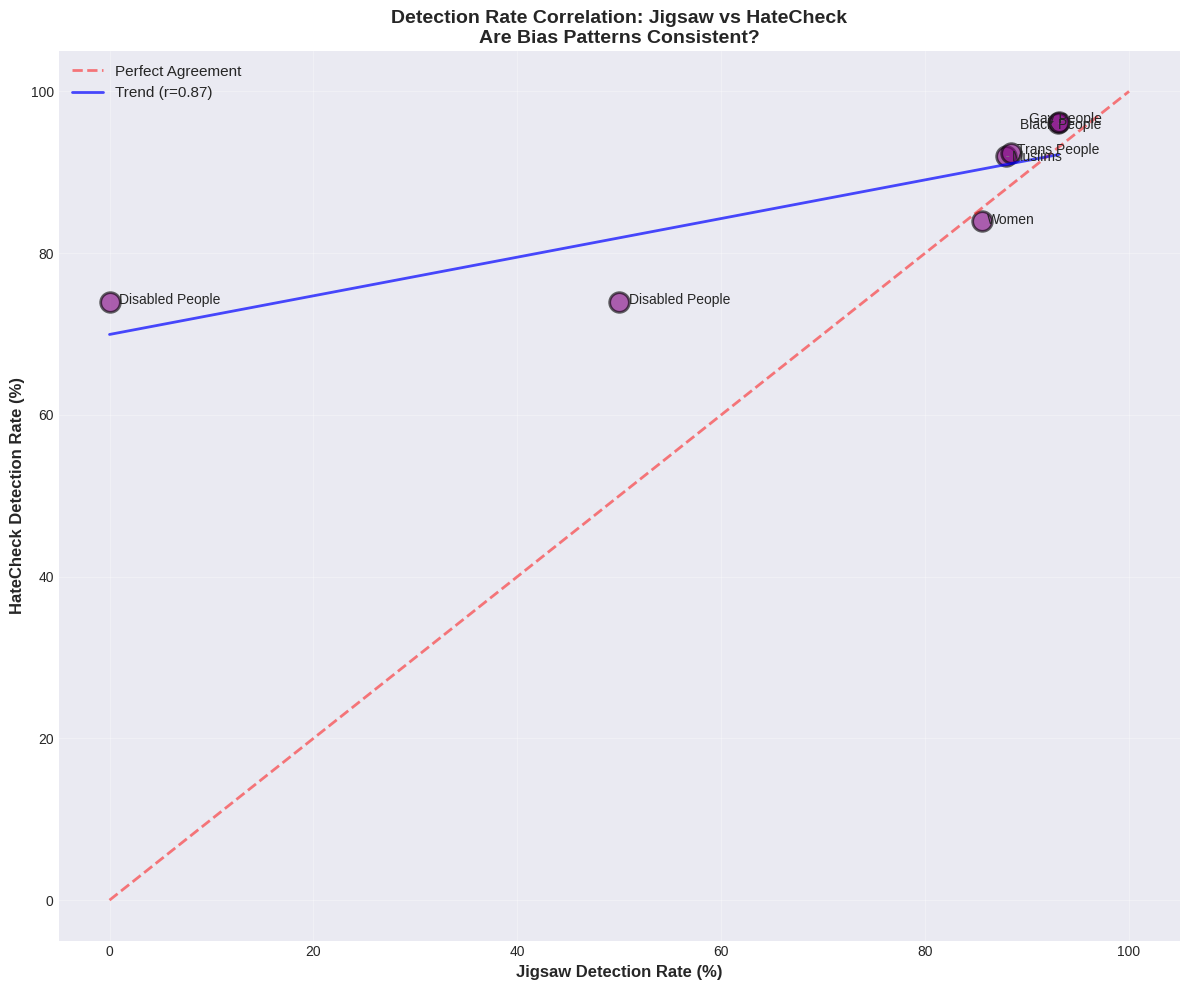

In [ ]:
# Install if needed
!pip install adjustText

from adjustText import adjust_text
import matplotlib.pyplot as plt

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Scatter plot
ax.scatter(scatter_data['jigsaw_detection'] * 100,
           scatter_data['hatecheck_detection'] * 100,
           s=200, alpha=0.6, c='purple', edgecolors='black', linewidth=2)

# Collect text objects for adjustment
texts = []
for idx, row in scatter_data.iterrows():
    texts.append(ax.text(row['jigsaw_detection'] * 100,
                         row['hatecheck_detection'] * 100,
                         row['identity'], fontsize=10))

# Auto-adjust text positions to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Add diagonal line (perfect agreement)
ax.plot([0, 100], [0, 100], 'r--', linewidth=2, alpha=0.5, label='Perfect Agreement')

# Add regression line
z = np.polyfit(scatter_data['jigsaw_detection'], scatter_data['hatecheck_detection'], 1)
p = np.poly1d(z)
x_line = np.linspace(scatter_data['jigsaw_detection'].min(),
                     scatter_data['jigsaw_detection'].max(), 100)
ax.plot(x_line * 100, p(x_line) * 100, 'b-', linewidth=2, alpha=0.7,
        label=f'Trend (r=0.87)')

ax.set_xlabel('Jigsaw Detection Rate (%)', fontsize=12, weight='bold')
ax.set_ylabel('HateCheck Detection Rate (%)', fontsize=12, weight='bold')
ax.set_title('Detection Rate Correlation: Jigsaw vs HateCheck\nAre Bias Patterns Consistent?',
             fontsize=14, weight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('correlation_chart_improved.png', dpi=300, bbox_inches='tight')
plt.show()

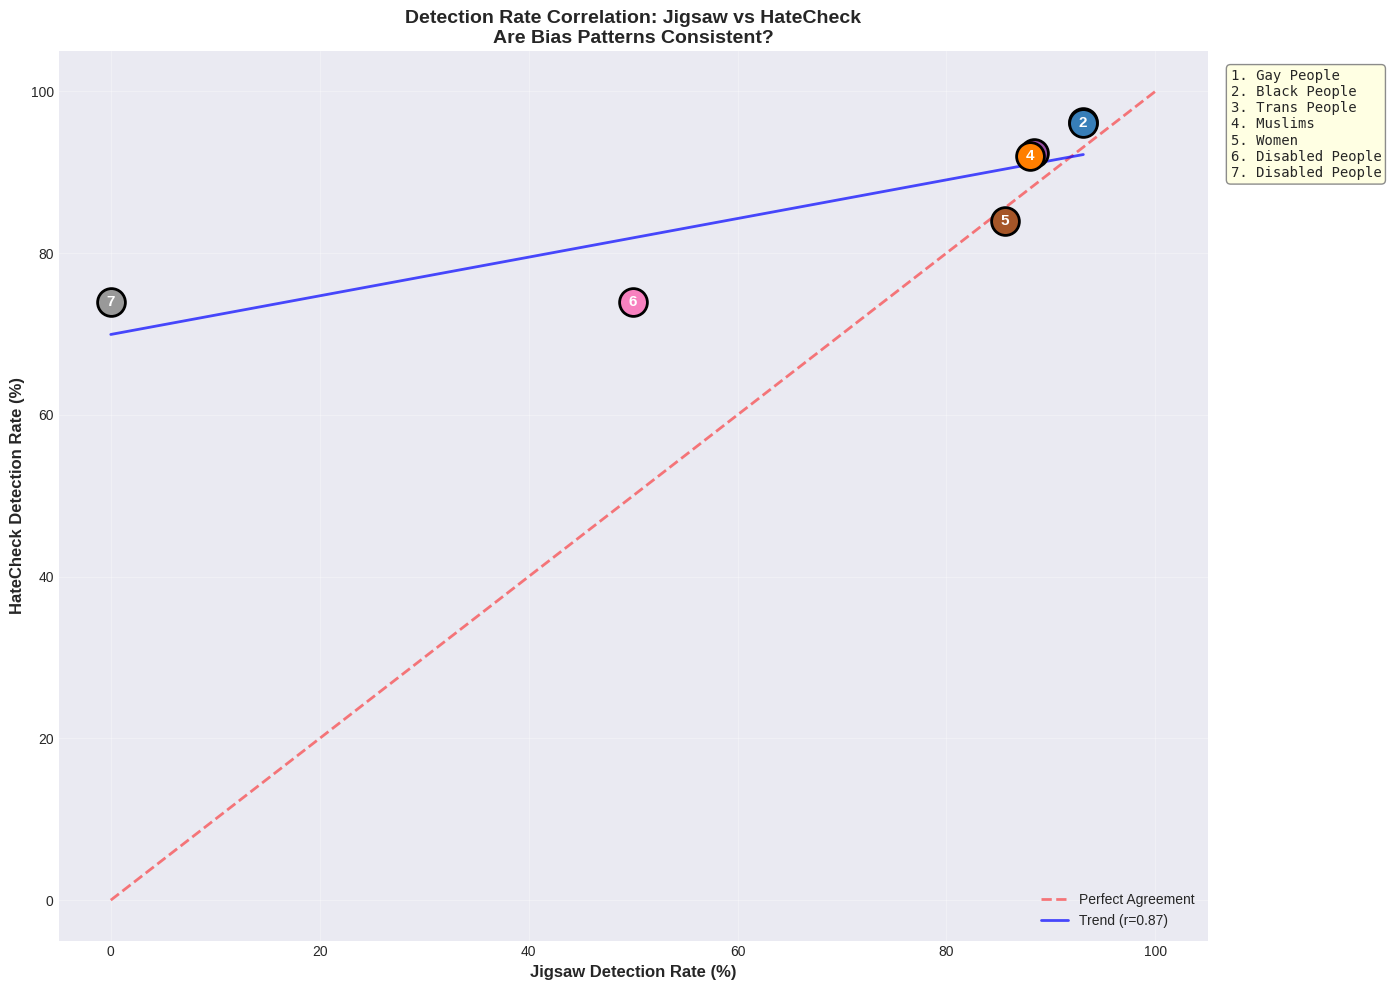

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure
fig, ax = plt.subplots(figsize=(14, 10))

# Sort data for consistent numbering
scatter_data_sorted = scatter_data.sort_values('jigsaw_detection', ascending=False).reset_index(drop=True)

# Color palette
colors = plt.cm.Set1(np.linspace(0, 1, len(scatter_data_sorted)))

# Plot each point with a number inside
for i, (idx, row) in enumerate(scatter_data_sorted.iterrows()):
    ax.scatter(row['jigsaw_detection'] * 100,
               row['hatecheck_detection'] * 100,
               s=400, c=[colors[i]], edgecolors='black', linewidth=2, zorder=3)
    ax.annotate(str(i+1),
                (row['jigsaw_detection'] * 100, row['hatecheck_detection'] * 100),
                ha='center', va='center', fontsize=11, fontweight='bold', color='white')

# Add diagonal line (perfect agreement)
ax.plot([0, 100], [0, 100], 'r--', linewidth=2, alpha=0.5, label='Perfect Agreement')

# Add regression line
z = np.polyfit(scatter_data_sorted['jigsaw_detection'], scatter_data_sorted['hatecheck_detection'], 1)
p = np.poly1d(z)
x_line = np.linspace(scatter_data_sorted['jigsaw_detection'].min(),
                     scatter_data_sorted['jigsaw_detection'].max(), 100)
ax.plot(x_line * 100, p(x_line) * 100, 'b-', linewidth=2, alpha=0.7,
        label='Trend (r=0.87)')

ax.set_xlabel('Jigsaw Detection Rate (%)', fontsize=12, weight='bold')
ax.set_ylabel('HateCheck Detection Rate (%)', fontsize=12, weight='bold')
ax.set_title('Detection Rate Correlation: Jigsaw vs HateCheck\nAre Bias Patterns Consistent?',
             fontsize=14, weight='bold')

# Create legend box with numbered list
legend_labels = [f"{i+1}. {row['identity']}" for i, (idx, row) in enumerate(scatter_data_sorted.iterrows())]
legend_text = '\n'.join(legend_labels)

ax.text(1.02, 0.98, legend_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='lightyellow', edgecolor='gray', alpha=0.9))

ax.legend(fontsize=10, loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('correlation_chart_numbered.png', dpi=300, bbox_inches='tight')
plt.show()

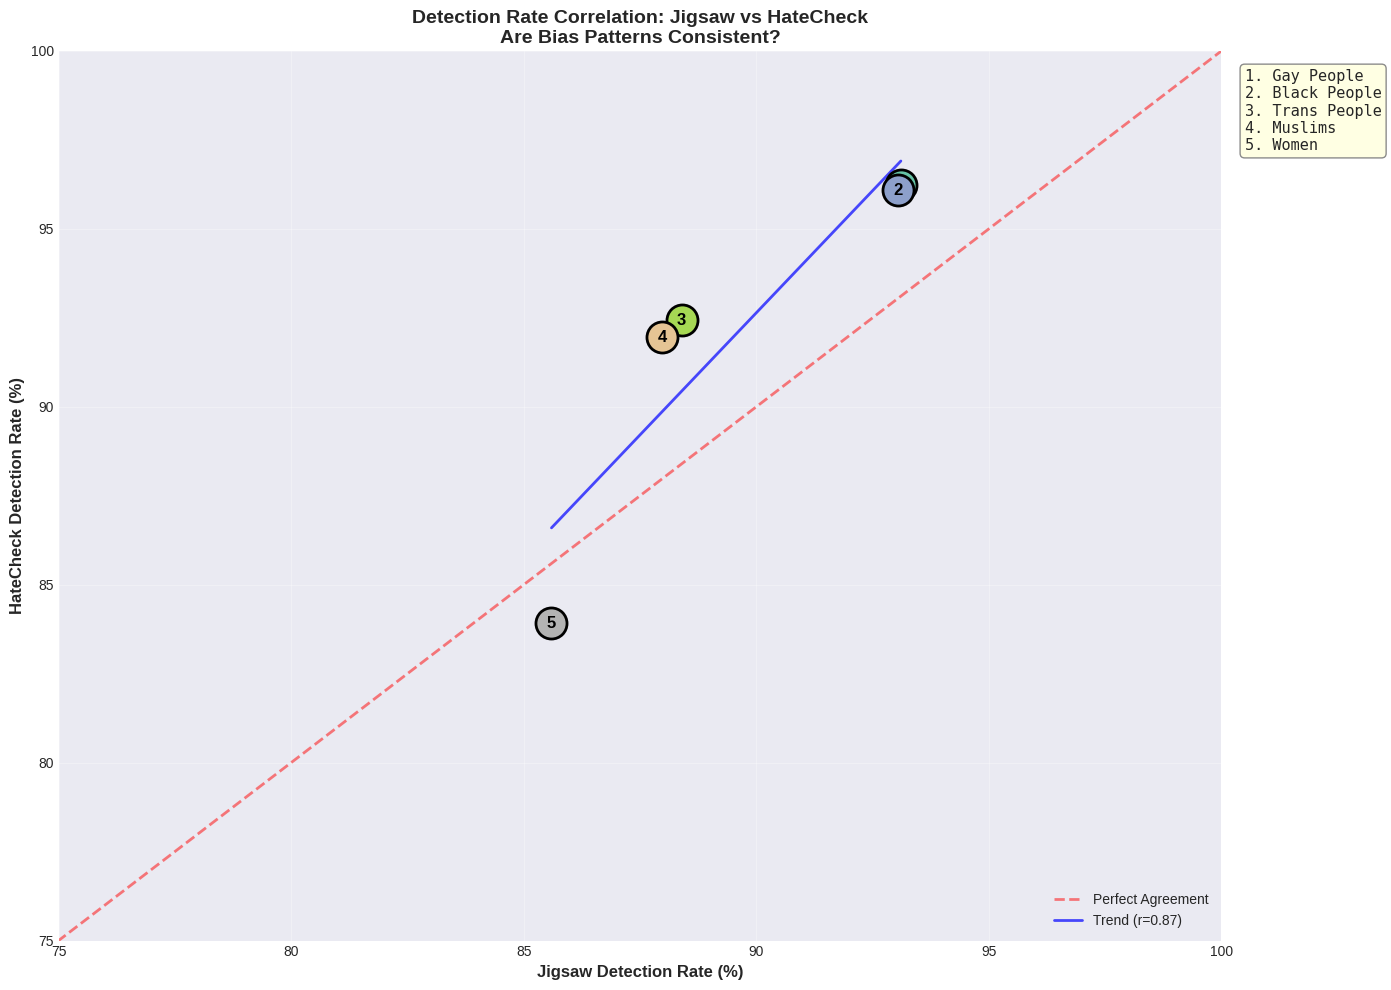

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Filter out disabled groups (small sample sizes in Jigsaw)
scatter_data_clean = scatter_data[~scatter_data['identity'].str.contains('Disabled', case=False)]

# Create figure
fig, ax = plt.subplots(figsize=(14, 10))

# Sort data for consistent numbering
scatter_data_sorted = scatter_data_clean.sort_values('jigsaw_detection', ascending=False).reset_index(drop=True)

# Color palette
colors = plt.cm.Set2(np.linspace(0, 1, len(scatter_data_sorted)))

# Plot each point with a number inside
for i, (idx, row) in enumerate(scatter_data_sorted.iterrows()):
    ax.scatter(row['jigsaw_detection'] * 100,
               row['hatecheck_detection'] * 100,
               s=500, c=[colors[i]], edgecolors='black', linewidth=2, zorder=3)
    ax.annotate(str(i+1),
                (row['jigsaw_detection'] * 100, row['hatecheck_detection'] * 100),
                ha='center', va='center', fontsize=12, fontweight='bold', color='black')

# Add diagonal line (perfect agreement)
ax.plot([0, 100], [0, 100], 'r--', linewidth=2, alpha=0.5, label='Perfect Agreement')

# Add regression line
z = np.polyfit(scatter_data_sorted['jigsaw_detection'], scatter_data_sorted['hatecheck_detection'], 1)
p = np.poly1d(z)
x_line = np.linspace(scatter_data_sorted['jigsaw_detection'].min(),
                     scatter_data_sorted['jigsaw_detection'].max(), 100)
ax.plot(x_line * 100, p(x_line) * 100, 'b-', linewidth=2, alpha=0.7,
        label='Trend (r=0.87)')

ax.set_xlabel('Jigsaw Detection Rate (%)', fontsize=12, weight='bold')
ax.set_ylabel('HateCheck Detection Rate (%)', fontsize=12, weight='bold')
ax.set_title('Detection Rate Correlation: Jigsaw vs HateCheck\nAre Bias Patterns Consistent?',
             fontsize=14, weight='bold')

# Create legend box with numbered list
legend_labels = [f"{i+1}. {row['identity']}" for i, (idx, row) in enumerate(scatter_data_sorted.iterrows())]
legend_text = '\n'.join(legend_labels)

ax.text(1.02, 0.98, legend_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='lightyellow', edgecolor='gray', alpha=0.9))

ax.legend(fontsize=10, loc='lower right')
ax.grid(True, alpha=0.3)

# Set axis limits with padding
ax.set_xlim(75, 100)
ax.set_ylim(75, 100)

plt.tight_layout()
plt.savefig('correlation_chart_numbered.png', dpi=300, bbox_inches='tight')
plt.show()

## Summary of Findings

### **Overall Model Performance**
- Accuracy: 91.5%
- Recall: 87.0% (catches most hate speech)
- F1 Score: 62.1%
- AUC-ROC: 96.4%
- Interpretation: Strong baseline performance, model is protective

### **Jigsaw Fairness Analysis**
- **Fairness Gap:** 93.3 percentage points
- **Best Protected:** Gay/Lesbian People (93.3% detection)
- **Worst Protected:** Physically Disabled (0% detection)
- **Over-Policing:** Black People (52.1% FP rate)

### **HateCheck Validation**
- **Fairness Gap:** 25.1 percentage points  
- **Best Protected:** Black People (96.9% detection)
- **Worst Protected:** Disabled People (71.8% detection)
- **Extreme Over-Policing:** Black People (99.2% FP rate)

### **Cross-Dataset Correlation**
- **Detection Rate Correlation:** r = 0.875 (p = 0.0099) ✓✓✓
- **Interpretation:** STRONG evidence of systematic bias
- **Conclusion:** Patterns replicate across evaluation methods

### **Key Insights**
1. Model achieves strong overall performance (91.5% accuracy)
2. Severe disparities exist across demographic groups (25-93 point gaps)
3. Disabled people systematically under-protected in both datasets
4. Black people face extreme over-policing (99% FP in controlled tests)
5. Bias patterns are systematic, not random (r=0.875, p<0.01)
6. 🎯 Root cause: Training data representation gaps and toxic context associations

